<a href="https://colab.research.google.com/github/MarcCampmanyGar/Nuclio_DS_Projects/blob/main/Malware_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Canvas

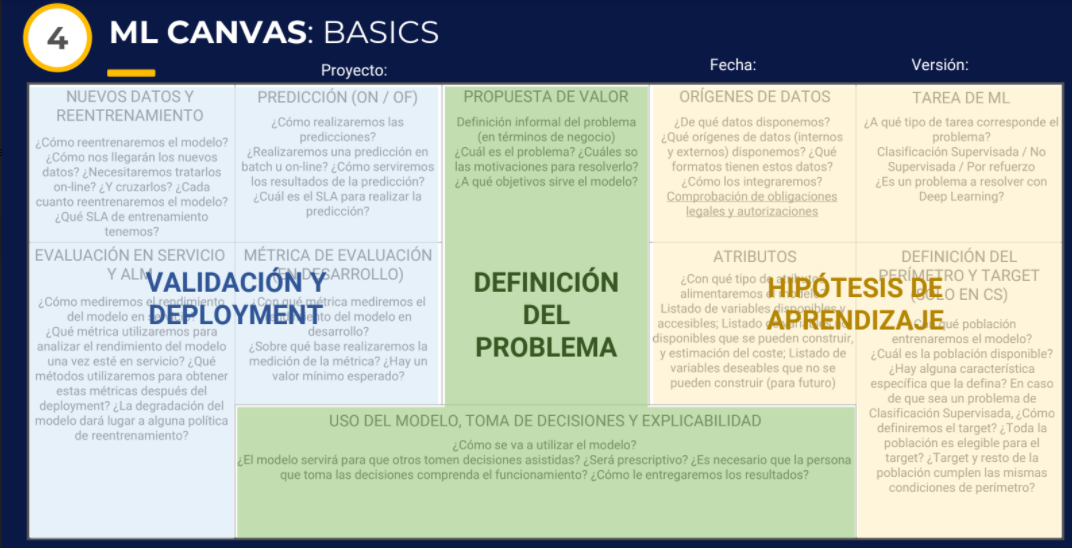

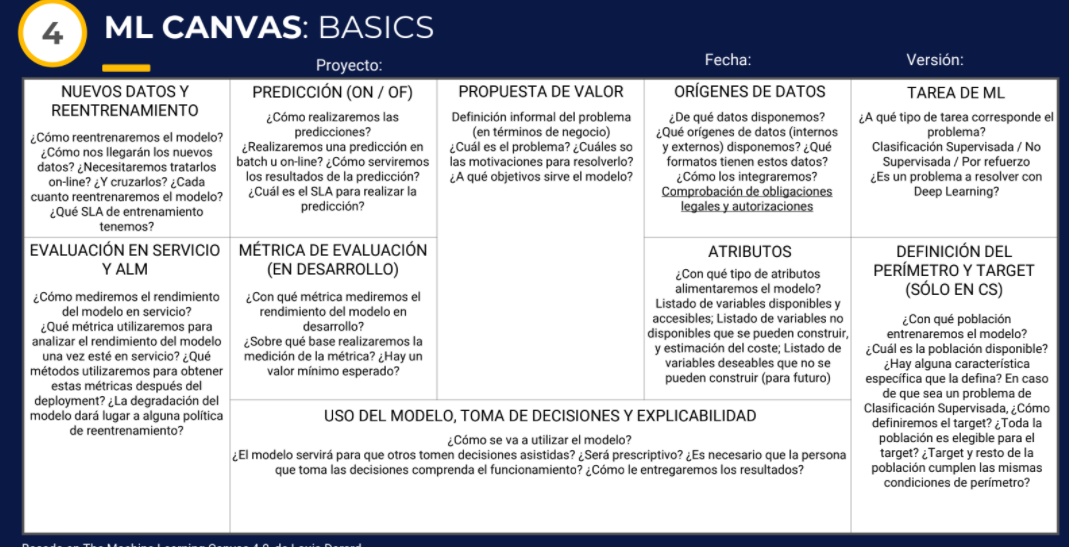

Definición del problema:
- Propuesta de valor: El problema engloba la detección de malware en los dispositivos informáticos. Analizando las variables relacionadas con los dispositivos y determinando si tienen malware, se trata de modelizar una solución para predecir si un dispositivo con sistema Operativo Windows, dadas sus características, puede tener malware o no.
- Uso del modelo, toma decisiones y explicabilidad: El modelo se implementará en Windows Defender para alertar al usuario de si su dispositivo es posible que tenga malware cuando éste supere un cierto umbral de probabilidad de ser infectado. Dependiendo de las características del dispositivo y la explicabilidad de cada variable.

Hipótesis de aprendizaje:
- Tarea ML: El problema es de clasificación supervisada. Clasificar en si el dispositivo puede tener virus o no.
- Origen datos: Disponemos de muchos datos del dispositivo, sobretodo a nivel de software. Programas instalados, configuraciones, sistema operativo, etc. Todos los datos son proporcionados por Microsoft y no tiene información personal por lo que cumplen GDPR
- Atributos: Se utilzarán la gran mayoría de variables para alimentar el modelo. Se dejarán fuera las que estén altamente correlacionadas con otras o los atributos que no aporten información diferencial respecto al target, es decir, que que estén presentes en el modelo no sirvan para aumentar el % de detección. Se podría trabajar en mapear los atributos relacionados con países y zonas ya que son numéricos. Y asegurar que todos los atributos de versiones están correctamente ordenados.
- Definición del problema: Sedispone de 500.000 registros como población. Para el problema de clasificación 1= tiene virus y 0= no tiene virus. El detaset está perfectamente balanceado y toda la población es elegible para el target.

Validación y deployment:
- Nuevos datos y reentrenamiento: El reentreno del modelo se hará cada medio año para aportar todas los nuevos registros al modelo. Los datos los recogería Microsoft para los dispositivos. El SLA de entrenamiento sería igualar o mejorar el rendimiento del modelo previo.
- Predicción (on/off): Las predicciones se harán online para cada usuario. Los resultados de la predicción se servirán como notificación + mail alertando al usuario, que se habrá registrado previamente al servicio de Microsoft.
- Métrica evaluación: mediremos el rendimiento del modelo con la métrica AUc y con la accuracy ya que el dataset está perfectamente balanceado y por tanto no existiría la "accuracy paradox". El valor mínimo esperado es el 50% de detección, ya que es el valor del dataset sin tratar.
- Evaluación en servicio: Una vez el modelo esté en servicio, se puede utilizar el feedback (en formato de encuesta) de los usuarios para ver si las predicciones hechas por el modelo son correctas. O si Microsoft tiene acceso a los datos de virus detectado de su antivirus, comprovar el rendimiento del modelo. Se utilizará el error medio de la predicción versus el resultado real. Los casos mal predecidos, se guardarán para realimentar el modelo.

# Imports

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import graphviz
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)

In [ ]:
# Para cuando aparece el error de "Transport endpoint is not connected" al intentar read_csv

# !fusermount -u drive
# !google-drive-ocamlfuse drive

# Data

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
file_dir = '/content/gdrive/MyDrive/DATA SCIENCE/Nuclio DS/Machine Learning/Supervisado/E2E _Project_Malware_Prediction/'
file_name = 'sample_mmp.csv'

# DATA Understanding (EDA)

1. Tamaño del Dataset (tamaño en memoria, número de registros y atributos, etc.)
2. Visualización directa de los datos (head)
3. Tipo de atributos disponibles (numéricos, categóricos)
4. Estadísticos descriptivos (valores medios, dispersión, percentiles, etc.)
5. Número de valores nulos
6. Distribución / rango de valores del target (sólo en clasificación supervisada)
7. Identificación de outliers
8. Identificación de datos erróneos
9. Correlación de variables con el target
10. Correlación de las variables con la clase (unidimensional)
11. Visualización gráfica de las distribuciones:
   * Numéricas: histogramas, box plots , violin plots , vista por deciles ,etc
   * Categóricas: bar charts, conteo directo, etc.
12. Distribución de variables 2 a 2 ( scatter plots
13. Correlación de las variables 2 a 2 (correlación lineal)
14. Crosstabs (categóricas)
15. Correlación de combinaciones de variables con la clase

In [ ]:
df = pd.read_csv(file_dir + file_name)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (29,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.head()

Unnamed: 0  ... HasDetections
0     8427007  ...             1
1     8829090  ...             0
2     2731904  ...             0
3     1359513  ...             1
4      236059  ...             1

[5 rows x 84 columns]

In [ ]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 84 entries, Unnamed: 0 to HasDetections
dtypes: float64(36), int64(18), object(30)
memory usage: 320.4+ MB


Se puede observar que el dataset tiene 84 columnas y 500000 filas de datos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 84 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Unnamed: 0                                         500000 non-null  int64  
 1   MachineIdentifier                                  500000 non-null  object 
 2   ProductName                                        500000 non-null  object 
 3   EngineVersion                                      500000 non-null  object 
 4   AppVersion                                         500000 non-null  object 
 5   AvSigVersion                                       500000 non-null  object 
 6   IsBeta                                             500000 non-null  int64  
 7   RtpStateBitfield                                   498168 non-null  float64
 8   IsSxsPassiveMode                                   500000 non-null  int64 

In [ ]:
# Eliminamos la columna "unnamed: 0" ya que es simplemente por cómo se ha leído el csv, se podría hacer dentro del mismo comando de lectura también
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
stats = []
for col in df.columns:
    stats.append((
        col, df[col].nunique(dropna = False), 
        df[col].isnull().sum() * 100 / df.shape[0], 
        df[col].value_counts(normalize=True, dropna=False).values[0] * 100, 
        df[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', '% of missing values', '% of values biggest category', 'type'])
stats_df.sort_values('% of missing values', ascending=False).head()

Feature  ...     type
28                     PuaMode  ...   object
41       Census_ProcessorClass  ...   object
8    DefaultBrowsersIdentifier  ...  float64
68  Census_IsFlightingInternal  ...  float64
52  Census_InternalBatteryType  ...   object

[5 rows x 5 columns]

Hay atributos donde la mayoría de valores son nulos, se deberán investigar

In [ ]:
# merge del descriptivo del df y del resumen de nulos, % de nulos, etc.
describe_df = df.describe(include = 'all').T

stats = stats_df.merge(describe_df, right_index=True, left_on='Feature')

In [ ]:
stats.head()

Feature  Unique_values  % of missing values  ...  50%  75%  max
0  MachineIdentifier         500000                  0.0  ...  NaN  NaN  NaN
1        ProductName              3                  0.0  ...  NaN  NaN  NaN
2      EngineVersion             53                  0.0  ...  NaN  NaN  NaN
3         AppVersion             95                  0.0  ...  NaN  NaN  NaN
4       AvSigVersion           6455                  0.0  ...  NaN  NaN  NaN

[5 rows x 16 columns]

In [ ]:
# lo pasamos a un excel para poder hacer el seguimiento de cada variable

# stats.to_excel(file_dir + 'stats.xlsx')

In [ ]:
def obtener_lista_variables(dataset):
  lista_numerica = []
  lista_boolean = []
  lista_categoricas = []

  for i in dataset:
    if (dataset[i].dtype == 'float64' or dataset[i].dtype == 'int64') and (len(dataset[i].unique())!= 2) and i not in target:
      lista_numerica.append(i)
    elif (dataset[i].dtype == 'float64' or dataset[i].dtype == 'int64') and (len(dataset[i].unique())== 2) and i not in target:
      lista_boolean.append(i)
    elif (dataset[i].dtype == 'object') and i not in target:
      lista_categoricas.append(i)
  return lista_numerica, lista_boolean, lista_categoricas

In [ ]:
target = ['HasDetections']
l_numerica, l_boolean, l_categorica = obtener_lista_variables(df)

In [ ]:
l_numerica

['RtpStateBitfield',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsBuild',
 'OsSuite',
 'IsProtected',
 'SMode',
 'IeVerIdentifier',
 'Firewall',
 'UacLuaenable',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_IsFlightingInternal',
 'Census_IsFlightsDisabled

In [ ]:
l_boolean

['IsBeta',
 'IsSxsPassiveMode',
 'HasTpm',
 'AutoSampleOptIn',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsSecureBootEnabled',
 'Census_IsWIMBootEnabled',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable']

In [ ]:
l_categorica

['MachineIdentifier',
 'ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'Platform',
 'Processor',
 'OsVer',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'PuaMode',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_InternalBatteryType',
 'Census_OSVersion',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_FlightRing']

In [ ]:
# variables numéricas + booleanas
df.describe(include=np.number).T

count  ...           max
IsBeta                                             500000.0  ...  1.000000e+00
RtpStateBitfield                                   498168.0  ...  3.500000e+01
IsSxsPassiveMode                                   500000.0  ...  1.000000e+00
DefaultBrowsersIdentifier                           24061.0  ...  3.209000e+03
AVProductStatesIdentifier                          498062.0  ...  7.049200e+04
AVProductsInstalled                                498062.0  ...  5.000000e+00
AVProductsEnabled                                  498062.0  ...  4.000000e+00
HasTpm                                             500000.0  ...  1.000000e+00
CountryIdentifier                                  500000.0  ...  2.220000e+02
CityIdentifier                                     481760.0  ...  1.679580e+05
OrganizationIdentifier                             345437.0  ...  5.200000e+01
GeoNameIdentifier                                  499984.0  ...  2.960000e+02
LocaleEnglishNameIdentifier                        500000.0  ...  2.830000e+02
OsBuild                                            500000.0  ...  1.824200e+04
OsSuite                                            500000.0  ...  7.840000e+02
IsProtected                                        498074.0  ...  1.000000e+00
AutoSampleOptIn                                    500000.0  ...  1.000000e+00
SMode                                              470152.0  ...  1.000000e+00
IeVerIdentifier                                    496791.0  ...  4.290000e+02
Firewall                                           494838.0  ...  1.000000e+00
UacLuaenable                                       499377.0  ...  6.357062e+06
Census_OEMNameIdentifier                           494619.0  ...  6.143000e+03
Census_OEMModelIdentifier                          494236.0  ...  3.454930e+05
Census_ProcessorCoreCount                          497653.0  ...  8.800000e+01
Census_ProcessorManufacturerIdentifier             497653.0  ...  1.000000e+01
Census_ProcessorModelIdentifier                    497651.0  ...  4.472000e+03
Census_PrimaryDiskTotalCapacity                    497024.0  ...  4.768767e+07
Census_SystemVolumeTotalCapacity                   497024.0  ...  4.768710e+07
Census_HasOpticalDiskDrive                         500000.0  ...  1.000000e+00
Census_TotalPhysicalRAM                            495444.0  ...  3.932160e+05
Census_InternalPrimaryDiagonalDisplaySizeInInches  497346.0  ...  1.420000e+02
Census_InternalPrimaryDisplayResolutionHorizontal  497350.0  ...  1.152000e+04
Census_InternalPrimaryDisplayResolutionVertical    497350.0  ...  4.320000e+03
Census_InternalBatteryNumberOfCharges              484962.0  ...  4.294967e+09
Census_OSBuildNumber                               500000.0  ...  1.824200e+04
Census_OSBuildRevision                             500000.0  ...  1.906900e+04
Census_OSInstallLanguageIdentifier                 496668.0  ...  3.900000e+01
Census_OSUILocaleIdentifier                        500000.0  ...  1.620000e+02
Census_IsPortableOperatingSystem                   500000.0  ...  1.000000e+00
Census_IsFlightingInternal                          84775.0  ...  1.000000e+00
Census_IsFlightsDisabled                           491067.0  ...  1.000000e+00
Census_ThresholdOptIn                              181896.0  ...  1.000000e+00
Census_FirmwareManufacturerIdentifier              489651.0  ...  1.084000e+03
Census_FirmwareVersionIdentifier                   490939.0  ...  7.209100e+04
Census_IsSecureBootEnabled                         500000.0  ...  1.000000e+00
Census_IsWIMBootEnabled                            182334.0  ...  0.000000e+00
Census_IsVirtualDevice                             499099.0  ...  1.000000e+00
Census_IsTouchEnabled                              500000.0  ...  1.000000e+00
Census_IsPenCapable                                500000.0  ...  1.000000e+00
Census_IsAlwaysOnAlwaysConnectedCapable            495960.0  ...  1.000000e+00
Wdft_IsGamer             

In [ ]:
# vemos unas cuantas variables que parecen booleanas ('IsBeta', 'HasTpm', etc.)
# no parece que existan fechas a priori
# hay muchos identifiers, al ser id los deberíamos tratar como object para posterior encoding

In [ ]:
# variables categóricas
df.describe(exclude=np.number).T

count  ...    freq
MachineIdentifier                 500000  ...       1
ProductName                       500000  ...  494604
EngineVersion                     500000  ...  216491
AppVersion                        500000  ...  288809
AvSigVersion                      500000  ...    5771
Platform                          500000  ...  483048
Processor                         500000  ...  454423
OsVer                             500000  ...  483830
OsPlatformSubRelease              500000  ...  220779
OsBuildLab                        499999  ...  206436
SkuEdition                        500000  ...  308567
PuaMode                              126  ...     126
SmartScreen                       321404  ...  241594
Census_MDC2FormFactor             500000  ...  320948
Census_DeviceFamily               500000  ...  499183
Census_ProcessorClass               2082  ...    1196
Census_PrimaryDiskTypeName        499291  ...  325429
Census_ChassisTypeName            499963  ...  294232
Census_PowerPlatformRoleName      499998  ...  346378
Census_InternalBatteryType        144397  ...  113500
Census_OSVersion                  500000  ...   79975
Census_OSArchitecture             500000  ...  454435
Census_OSBranch                   500000  ...  226001
Census_OSEdition                  500000  ...  194469
Census_OSSkuName                  500000  ...  194464
Census_OSInstallTypeName          500000  ...  146780
Census_OSWUAutoUpdateOptionsName  500000  ...  222482
Census_GenuineStateName           500000  ...  441402
Census_ActivationChannel          500000  ...  264932
Census_FlightRing                 500000  ...  468299

[30 rows x 4 columns]

In [ ]:
[column for column in df.columns if df[column].nunique(dropna = False) == 1]

# vemos que no hay columnas con un solo valor, por tanto sin varianza, que podamos eliminar.

[]

In [ ]:
# Analizamos la correlación entre variables para ver si hay atributos estrechamente parecidos
corr = df.corr()

In [ ]:
corr.style.background_gradient(cmap='coolwarm')

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


In [ ]:
# Existe correlación entre:
  # - Census_ProcessorModelIdentifier y Census_ProcessorManufacturerIdentifier                                  (0,799110)  Analizar
  # - Census_SystemVolumeTotalCapacity y Census_PrimaryDiskTotalCapacity                                        (0.778407)  Analizar
  # - Census_InternalPrimaryDisplayResolutionVertical y Census_InternalPrimaryDisplayResolutionHorizontal       (0.898250)  se podría calcular el ratio de display
  # - Census_OSUILocaleIdentifier y Census_OSInstallLanguageIdentifier                                          (0.988488)  eliminar alguna de las dos
  # - OsBuild y Census_OSBuildNumber                                                                            (0.937660)  por nombre parecen lo mismo, investigar y tal vez eliminar alguna

## Target

In [ ]:
TARGET = 'HasDetections'

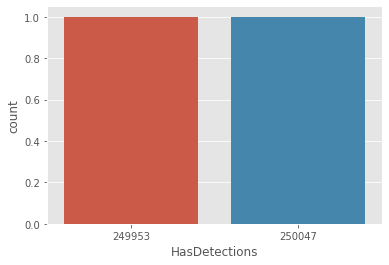

In [ ]:
sns.countplot(x=df[TARGET].value_counts(dropna=False))
verbose=0

# Se puede observar que el Target está muy balanceado, por lo que es bueno. Además no tiene ningún valor nulo.

In [ ]:
df[TARGET].mean()   # el 49.99 de los usuarios tienen virus detectados en su device

0.499906

In [ ]:
df[TARGET].dtype

dtype('int64')

## Variable Fecha

In [ ]:
# no hay a priori un atributo que sea una fecha directamente. Vamos a revisar si se puede sacar una fecha de alguna columna
# debería ser alguna columna que muestre un atributo incremental como versiones, OS, etc.

In [ ]:
dates = []
for col in df.columns:
  for substring in ['Version', 'Os', 'Build']:
    if substring in col:
      dates.append(col)

list(set(dates))

['OsPlatformSubRelease',
 'EngineVersion',
 'OsSuite',
 'OsBuild',
 'Census_FirmwareVersionIdentifier',
 'AppVersion',
 'AvSigVersion',
 'Census_OSBuildRevision',
 'OsVer',
 'Census_OSVersion',
 'OsBuildLab',
 'Census_OSBuildNumber']

In [ ]:
df.head()[list(set(dates))]

OsPlatformSubRelease  ... Census_OSBuildNumber
0                  rs4  ...                17134
1                  rs4  ...                17134
2                  th2  ...                10586
3                  rs4  ...                17134
4                  rs4  ...                17134

[5 rows x 12 columns]

In [ ]:
# la más clara parece el string final de "OsBuildLab". Sacamos el año
'20' + ('10586.1176.amd64fre.th2_release_sec.170913-1848	').strip()[-11:][:-9]

'2017'

In [ ]:
#saacamos el mes
('10586.1176.amd64fre.th2_release_sec.170913-1848	').strip()[-11:][2:4]

'09'

In [ ]:
# sacamos el día
('10586.1176.amd64fre.th2_release_sec.170913-1848	').strip()[-11:][4:6]

'13'

In [ ]:
# creamos columnas par año, mes y día a partir de la fecha del atributo OsBuildLab

In [ ]:
df['OsBuildLab'] = df['OsBuildLab'].astype(str)

In [ ]:
df['Build_year'] = df['OsBuildLab'].apply(lambda x: '20' + x.strip()[-11:][:-9])

In [ ]:
df['Build_month'] = df['OsBuildLab'].apply(lambda x: x.strip()[-11:][2:4])

In [ ]:
df['Build_day'] = df['OsBuildLab'].apply(lambda x: x.strip()[-11:][4:6])

In [ ]:
df['Build_year'].value_counts()

2018    327813
2017    149114
2016     17853
2015      5085
2014        90
2013        16
2011        11
2009        10
2010         5
2012         2
20           1
Name: Build_year, dtype: int64

In [ ]:
df['Build_month'].value_counts()

04    226864
09     82867
05     72007
03     60791
06     18942
07     12481
08      8461
10      5461
12      4368
11      3885
02      2654
01      1218
n          1
Name: Build_month, dtype: int64

In [ ]:
df['Build_day'].value_counts()

10    222262
02     86885
28     68459
17     45308
29     16267
13     10656
08      5949
15      4006
27      3874
19      3832
06      3581
18      3553
31      3034
09      2913
01      2525
04      2364
20      2263
22      1956
12      1548
03      1532
14      1514
24      1234
23      1171
30      1084
26       622
07       369
21       365
25       360
11       227
05       198
16        88
           1
Name: Build_day, dtype: int64

In [ ]:
df[df['Build_day'] == '']

MachineIdentifier   ProductName  ... Build_month Build_day
84027  bd5f382e3f36b1277b1d7d6cab352c23  win8defender  ...           n          

[1 rows x 86 columns]

In [ ]:
# al ser solo un registro y tener más de un nan en diferentes columnas, eliminamos fila

df.drop(84027, inplace=True)

In [ ]:
df['Build_year'] = df['Build_year'].astype(int)
df['Build_month'] = df['Build_month'].astype(int)
df['Build_day'] = df['Build_day'].astype(int)

In [ ]:
# al haber extraído la info, eliminamos la columna inicial

In [ ]:
df.drop('OsBuildLab', axis=1, inplace=True)

## MachineIdentifier

In [ ]:
df['MachineIdentifier'].describe()

count                               499999
unique                              499999
top       dd9cd08a68fd3880b942abd00d368d5f
freq                                     1
Name: MachineIdentifier, dtype: object

In [ ]:
df['MachineIdentifier'].head()

0    f1cd864e97bae82bdf96523e1a539121
1    fd5ba6f5b75325ec0423a6c67cc75942
2    4e628391e7cc7c482fb3286f486dbd25
3    270a2e9d028144a4df12a9e3da79fba5
4    06ca8fa8d32c2abdc5b3577d676b3269
Name: MachineIdentifier, dtype: object

In [ ]:
# Esta variable tiene todos los valores diferentes y no tiene nulos, por lo que parece un candidato perfecto para ser el índice y no una variable predictora

df.set_index('MachineIdentifier', inplace=True)

In [ ]:
df.head()

ProductName  ... Build_day
MachineIdentifier                               ...          
f1cd864e97bae82bdf96523e1a539121  win8defender  ...        10
fd5ba6f5b75325ec0423a6c67cc75942  win8defender  ...        10
4e628391e7cc7c482fb3286f486dbd25  win8defender  ...        13
270a2e9d028144a4df12a9e3da79fba5  win8defender  ...        10
06ca8fa8d32c2abdc5b3577d676b3269  win8defender  ...        10

[5 rows x 84 columns]

## Funciones categóricas

### Función EXPLORE

In [ ]:
# para ver a alto nivel la distribución de clases de un atributo y su relación con el target, creamos función de análisis

In [ ]:
def explore_cat_values(dataframe, column):
  results_df = dataframe.pivot_table(index = column, values = TARGET, dropna=False, aggfunc= [len, sum, np.mean]).sort_values(by= (('mean', 'HasDetections')), ascending=False)
  results_df.columns = ['n_rows', '1-HasDet', 'pct_detected']
  results_df['0-HasDet'] = results_df['n_rows'] - results_df['1-HasDet']
  results_df = results_df[['n_rows','1-HasDet','0-HasDet','pct_detected']]
  return results_df

In [ ]:
expl = explore_cat_values(df, 'Platform')
expl

n_rows  1-HasDet  0-HasDet  pct_detected
Platform                                             
windows8      10825      5614      5211      0.518614
windows10    483047    241476    241571      0.499902
windows7       5314      2562      2752      0.482123
windows2016     813       301       512      0.370234

### Función PLOT

In [ ]:
# función para pintar el balance del Target ("HasDetections") 0 o 1 para cada unaa de las clases de un atributo y su
# % de pct_detected en orden descendente

In [ ]:
def plot_cat_values(dataframe, column):
  expl = explore_cat_values(dataframe, column) 
  plt.figure(figsize = [20,10])
  plt.xticks(rotation=45)

  ax1 = plt.subplot(2,1,1)        # 2 filas, 1 columna, pintarlo en la 1a posición
  sns.set_style(style = 'ticks')
  sns.countplot(data = dataframe, x = column, hue = TARGET, order=expl.index)
  plt.xticks(rotation=45)
  ax2 = ax1.twinx()
  sns.lineplot(x=expl.index, y=expl['pct_detected'], marker = 'o', color = 'black')
  plt.legend(['pct detected'], loc='lower right')
  plt.xticks(rotation=45)

  plt.show()

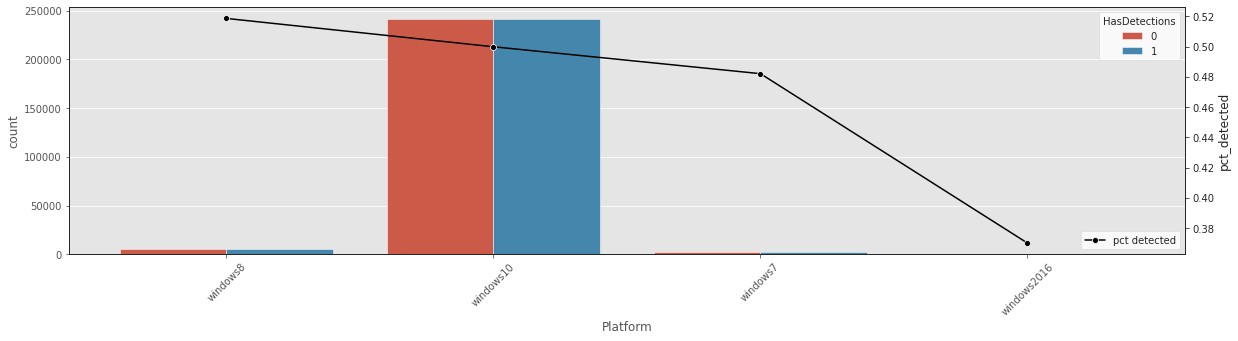

In [ ]:
plot_cat_values(df, 'Platform')

In [ ]:
# windows7 se lanzó en 2009, windows8 se lanzó en 2012, windows10 en 2015 . Las versiones más antiguas y más nueva son las que tienen menos % virus detectados
# "Microsoft Windows Server 2016 is an operating system built by Microsoft and is the successor of Windows Server 2012. It is the server-edition of Windows 10 and is available since September 2016."
# Esta variable categórica muestra que a medida que la versión es más nueva (excepto win7), tiene menos % de virus detectados, así que podemos utilizar encoding por jerarquia, label encoding

### Función LABEL ENCODING

#### Platform

In [ ]:
df['Platform'].value_counts()

windows10      483047
windows8        10825
windows7         5314
windows2016       813
Name: Platform, dtype: int64

In [ ]:
# prueba con el label encoding de sklearn

# df['Platform'] = df['Platform'].astype('category')

In [ ]:
# le = LabelEncoder()
# df['Platform_2'] = le.fit_transform(df['Platform'])

In [ ]:
# df['Platform_2'].value_counts()

In [ ]:
# vemos que el LableEncoder de Sklearn aplica solo alfabéticamente a-z y de 0-9 así que crearemos nuestra función adaptada para estos casos y la función con sklearn por separado

In [ ]:
def LE_list(dataframe, column, order_list):
  x = range(dataframe[column].nunique())
  dataframe['class_'+column] = dataframe[column]
  for i in x:
    dataframe['class_'+column] = dataframe['class_'+column].replace(order_list[i], i)
  
  return dataframe.drop(column, axis=1)

In [ ]:
l = ['windows7', 'windows8', 'windows10', 'windows2016']

In [ ]:
df = LE_list(df, 'Platform', l)

In [ ]:
df['class_Platform'].value_counts()

2    483047
1     10825
0      5314
3       813
Name: class_Platform, dtype: int64

In [ ]:
# Función Label Encoding mediante Sklearn

In [ ]:
def LE_sk(dataframe, column):
  dataframe[column] = dataframe[column].astype('category')
  le = LabelEncoder()
  dataframe[column+'_LE'] = le.fit_transform(df[column])
  return dataframe.drop(column, index=1)

### Función SET OTHERS

In [ ]:
# Función para agregación de clases + creación de clase Others para agrupar clases restantes
# nos quedaremos con el n=num_values de clases, ordenadas por nº de registros descendente (head) + la clase Others donde se agruparan todo el resto de clases
# Esta función servirá para un posterior OHE y pasar a tener atributos numéricos

In [ ]:
def setOthers(dataframe, column, num_values):
    top_categories_list = dataframe[column].value_counts().head(num_values).index.to_list()
    top_categories_list.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories = top_categories_list)
    return dataframe[column].fillna('Others')

In [ ]:
# SetOtherHeadTail hace lo mismo que la función anterior pero no coge las clases por nº de registros sino por % de aportación al target
# el nº de registros es simplemente un filtro para indicar el nº mínimo de filas que puede tener una clase
# esta función escoge del head y del tail las top_n clases, es decir, las que mayor y menor % de virus detectado tienen, dejando en Others las que son cercanas al 50% y que no aportan valor predictivo

In [ ]:
def setOthersHeadTail(dataframe, column, num_rows_min, top_n):

    results_by_category = explore_cat_values(dataframe, column)
    last_categories = results_by_category[results_by_category['n_rows'] > num_rows_min].sort_values(by='pct_detected').head(top_n).index.to_list()
    first_categories = results_by_category[results_by_category['n_rows'] > num_rows_min].sort_values(by='pct_detected').tail(top_n).index.to_list()
    top_categories_list = list(set(first_categories + last_categories))   #para tener lista de distincts hago el set, y lo paso a lista para seguir igual
    top_categories_list.append('Others')    # así me quedo con los más relevante + una nieva categoría de other con todos los otros

    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    return dataframe[column].fillna('Others')

### Función Freq Encoding

In [ ]:
# def frequency_encoding(variable):
#     t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
#     t = t.reset_index()
#     t.loc[t[variable] == 1, 'level_0'] = np.nan
#     t.set_index('index', inplace=True)
#     max_label = t['level_0'].max() + 1
#     t.fillna(max_label, inplace=True)
#     return t.to_dict()['level_0']

In [ ]:
# frequency_encoded_variables = [
#     'Census_OEMModelIdentifier',
#     'CityIdentifier',
#     'Census_FirmwareVersionIdentifier',
#     'AvSigVersion',
#     'Census_ProcessorModelIdentifier',
#     'Census_OEMNameIdentifier',
#     'DefaultBrowsersIdentifier'
# ]

## Booleanas

In [ ]:
# creamos función para filtrar las posibles booleanas, para ver si aportan algo o se deben eliminar

### Función CHECK BOOLEANAS

In [ ]:
def check_bool(dataframe, pct_dif_filter, pct_top_filter, pct_low_filter):

  list_bool = {}
  list_drop = {}

  for col in dataframe.columns[:-5]:
    
      if ((dataframe[col].nunique() == 2) & (dataframe[col].nunique(dropna=False) == 2)):                      # tienen dos valores únicos y no tienen nulos
          pct_0, pct_1 = explore_cat_values(dataframe, col)['pct_detected']
          dataframe[col] = dataframe[col].replace('dummy', np.nan)
        
          if abs(pct_0 - pct_1) > pct_dif_filter:                                                          # filtramos pq haya más de un 5% de diferencia entre clases
              list_bool[col] = [pct_0, pct_1, dataframe[col].dtype]
          else:
              list_drop[col] = [pct_0, pct_1]
      
      elif ((dataframe[col].nunique(dropna = False) == 2) & (dataframe[col].isnull().sum() > 0)):              # tiene dos valores y uno es un nulo
          dataframe[col] = dataframe[col].fillna('dummy')                                                      # pasamos los nulls a 'dummy' para poder ejecutar la función explore
          pct_0, pct_1 = explore_cat_values(dataframe, col)['pct_detected']
          dataframe[col] = dataframe[col].replace('dummy', np.nan)          

          if abs(pct_0 - pct_1) > pct_dif_filter:                                                          # filtramos pq haya más de un 5% de diferencia entre clases
              list_bool[col] = [pct_0, pct_1, dataframe[col].dtype]
          else:
              list_drop[col] = [pct_0, pct_1]  
      elif (dataframe[col].nunique(dropna = False) == 3) & ((dataframe[col].isnull().sum() > 0)):              # tiene 3 valores, uno de los cuales es nulo
          dataframe[col] = dataframe[col].fillna('dummy')                                                      # pasamos los nulls a 'dummy' para poder ejecutar la función explore
          pct_0, pct_1, pct_2 = explore_cat_values(dataframe, col)['pct_detected']                             # sacamos los porcentajes
          dataframe[col] = dataframe[col].replace('dummy', np.nan)                                             # volvemos a dejar la clase como estaba

          if ((max([pct_0, pct_1, pct_2])> pct_top_filter) | (min([pct_0, pct_1, pct_2])< pct_low_filter)):       # filtramos para que almenos una de las clase sea >pct_top% virus o <pct_low% virus
              list_bool[col] = [pct_0, pct_1, pct_2, dataframe[col].dtype]
          else:
              list_drop[col] = [pct_0, pct_1, pct_2]

  return list_bool, list_drop

In [ ]:
list_bool, list_drop = check_bool(df, 0.05, 0.55, 0.45)

In [ ]:
explore_cat_values(df, 'Firewall')['pct_detected']    # al volver a dejar los 'dummy' como nulos, la función explore no los coge

Firewall
1.0    0.500146
0.0    0.493034
Name: pct_detected, dtype: float64

In [ ]:
df['Firewall'].value_counts(dropna=False)     # pero sí que existen

1.0    484071
0.0     10766
NaN      5162
Name: Firewall, dtype: int64

In [ ]:
list_bool

{'Census_IsAlwaysOnAlwaysConnectedCapable': [0.5155940594059406,
  0.5075561201793108,
  0.3717023000246557,
  dtype('float64')],
 'Census_IsFlightsDisabled': [0.5072204186723385,
  0.4997810853685606,
  0.0,
  dtype('float64')],
 'Census_IsTouchEnabled': [0.5075992151517785,
  0.4462745348151219,
  dtype('int64')],
 'Census_IsVirtualDevice': [0.5238623751387348,
  0.5019845794043638,
  0.20187127870711652,
  dtype('float64')],
 'IsBeta': [0.4999079996319985, 0.0, dtype('int64')],
 'IsProtected': [0.5070923340805652,
  0.38298581534017256,
  0.38161993769470404,
  dtype('float64')],
 'IsSxsPassiveMode': [0.5021612689212785, 0.37141862892935856, dtype('int64')],
 'PuaMode': [0.753968253968254, 0.4998429601118684, dtype('O')],
 'SMode': [0.5052740214280395,
  0.41761592066470116,
  0.1796116504854369,
  dtype('float64')]}

In [ ]:
# Estos atributos los analizaremos en detalle para ver las distribuciones de las clases

In [ ]:
list_drop

{'AutoSampleOptIn': [0.5, 0.49990699720991627],
 'Census_HasOpticalDiskDrive': [0.5346470389698056, 0.49700746724682654],
 'Census_IsFlightingInternal': [0.5029827202119332, 0.5, 0.48484169301184354],
 'Census_IsPenCapable': [0.501578585279978, 0.4572912250953794],
 'Census_IsPortableOperatingSystem': [0.5172413793103449, 0.49989794652397856],
 'Census_IsSecureBootEnabled': [0.5011155161691542, 0.49862598313275847],
 'Census_IsWIMBootEnabled': [0.5055278185263767, 0.4901142415251216],
 'Census_ThresholdOptIn': [0.5054730528380655,
  0.4901786107078439,
  0.46808510638297873],
 'Firewall': [0.5001456397925098, 0.49303362437302617, 0.4918636187524215],
 'HasTpm': [0.5003067379081487, 0.4674983585029547],
 'Wdft_IsGamer': [0.5442447563659685, 0.5226548672566371, 0.4812005725273613]}

In [ ]:
# Estos atributos pueden ser eliminados dado que la variabilidad aportada por cada clase no ayuda a la predicción del problema

In [ ]:
df.drop(list_drop.keys(), axis=1, inplace=True)

In [ ]:
# Ahora analizamos las variables de la lista list_bool

### Función RELLENAR BOOL

#### SMode

In [ ]:
explore_cat_values(df, 'SMode')

n_rows  1-HasDet  0-HasDet  pct_detected
SMode                                          
0.0    469945    237451    232494      0.505274
1.0       206        37       169      0.179612

In [ ]:
# tenemos que volver a replace los "dummy" por los nan para poder ver bien la función explore

df['SMode'] = df['SMode'].fillna('dummy')

In [ ]:
explore_cat_values(df, 'SMode')

n_rows  1-HasDet  0-HasDet  pct_detected
SMode                                          
0.0    469945    237451    232494      0.505274
dummy   29848     12465     17383      0.417616
1.0       206        37       169      0.179612

### Funciones nans/dummies

In [ ]:
# creamos una función pq lo tendremos que hacer para todos los atributos de la lista list_bool

def dummy_explore(dataframe, column):
  dataframe[column] = dataframe[column].fillna('dummy')
  return explore_cat_values(dataframe, column)

In [ ]:
# pasaremos las 'dummy' a la clase 1 ya que son muy pocas, y al ser un modo (SMode) en ppio solo puede tener modo 1 o modo 0.
# por lo que conservaremos el atributo ya que en 1 tiene menos malwares detectados

In [ ]:
def dummy2bool(dataframe, column, clase_final):
  dataframe[column] = dataframe[column].replace('dummy', clase_final)
  dataframe[column] = dataframe[column].astype(int)
  return explore_cat_values(df, column)

In [ ]:
dummy2bool(df, 'SMode', 1)

n_rows  1-HasDet  0-HasDet  pct_detected
SMode                                          
0      469945    237451    232494      0.505274
1       30054     12502     17552      0.415985

#### IsSxsPassiveMode

In [ ]:
explore_cat_values(df, 'IsSxsPassiveMode')

n_rows  1-HasDet  0-HasDet  pct_detected
IsSxsPassiveMode                                          
0                 491378    246751    244627      0.502161
1                   8621      3202      5419      0.371419

In [ ]:
# vemos que ser IsSxsPassiveMode=1 tiene un porcentaje muy menor de virus, por tanto nos quedamos el atributo ya que tiene 8k registros

In [ ]:
df['IsSxsPassiveMode'] = df['IsSxsPassiveMode'].astype(int)

#### IsProtected

In [ ]:
explore_cat_values(df, 'IsProtected')

n_rows  1-HasDet  0-HasDet  pct_detected
IsProtected                                          
1.0          471072    238877    232195      0.507092
0.0           27001     10341     16660      0.382986

In [ ]:
dummy_explore(df, 'IsProtected')

n_rows  1-HasDet  0-HasDet  pct_detected
IsProtected                                          
1.0          471072    238877    232195      0.507092
0.0           27001     10341     16660      0.382986
dummy          1926       735      1191      0.381620

In [ ]:
# vemos que los 'dummy' que antes eran nulos son de la clase 0 realmente

dummy2bool(df, 'IsProtected', 0)

n_rows  1-HasDet  0-HasDet  pct_detected
IsProtected                                          
1            471072    238877    232195      0.507092
0             28927     11076     17851      0.382895

#### PuaMode

In [ ]:
explore_cat_values(df, 'PuaMode')

n_rows  1-HasDet  0-HasDet  pct_detected
PuaMode                                          
on          126        95        31      0.753968

In [ ]:
dummy_explore(df, 'PuaMode')

n_rows  1-HasDet  0-HasDet  pct_detected
PuaMode                                          
on          126        95        31      0.753968
dummy    499873    249858    250015      0.499843

In [ ]:
# 'on' se refiera a que el PuaMode está encendido = 1
# pero solo tiene 126 registros, lo eliminamos pq los registros en esta clase son muy bajos

In [ ]:
df.drop('PuaMode', axis=1, inplace=True)

#### Census_IsFlightsDisabled

In [ ]:
explore_cat_values(df, 'Census_IsFlightsDisabled')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_IsFlightsDisabled                                          
0.0                       491059    245422    245637      0.499781
1.0                            7         0         7      0.000000

In [ ]:
dummy_explore(df, 'Census_IsFlightsDisabled')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_IsFlightsDisabled                                          
dummy                       8933      4531      4402      0.507220
0.0                       491059    245422    245637      0.499781
1.0                            7         0         7      0.000000

In [ ]:
# la eliminamos pq las clases no muestran una diferencia considerable. La función de booleanas no la ha colocado 
# en la lista para eliminar por el 0% de virus detectados de la clase 1

In [ ]:
df.drop('Census_IsFlightsDisabled', axis =1, inplace=True)

#### Census_IsVirtualDevice

In [ ]:
dummy_explore(df, 'Census_IsVirtualDevice')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_IsVirtualDevice                                          
dummy                      901       472       429      0.523862
0.0                     495571    248769    246802      0.501985
1.0                       3527       712      2815      0.201871

In [ ]:
# pasamos el dummy a 0 por asociación y parecido de clase
# la clase 1 tiene 3,5k registros así que bien

In [ ]:
dummy2bool(df, 'Census_IsVirtualDevice', 0)

n_rows  1-HasDet  0-HasDet  pct_detected
Census_IsVirtualDevice                                          
0                       496472    249241    247231      0.502024
1                         3527       712      2815      0.201871

#### Census_IsTouchEnabled

In [ ]:
dummy_explore(df, 'Census_IsTouchEnabled')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_IsTouchEnabled                                          
0                      437282    221964    215318      0.507599
1                       62717     27989     34728      0.446275

In [ ]:
# todo bien, la mantenemos

#### Census_IsAlwaysOnAlwaysConnectedCapable

In [ ]:
dummy_explore(df, 'Census_IsAlwaysOnAlwaysConnectedCapable')

n_rows  ...  pct_detected
Census_IsAlwaysOnAlwaysConnectedCapable          ...              
dummy                                      4040  ...      0.515594
0.0                                      467568  ...      0.507556
1.0                                       28391  ...      0.371702

[3 rows x 4 columns]

In [ ]:
# pasamos la clase dummy (antes nulos) a 0, por parecido y número de registros

In [ ]:
dummy2bool(df, 'Census_IsAlwaysOnAlwaysConnectedCapable', 0)

n_rows  ...  pct_detected
Census_IsAlwaysOnAlwaysConnectedCapable          ...              
0                                        471608  ...      0.507625
1                                         28391  ...      0.371702

[2 rows x 4 columns]

#### IsBeta

In [ ]:
dummy_explore(df, 'IsBeta')

n_rows  1-HasDet  0-HasDet  pct_detected
IsBeta                                          
0       499998    249953    250045      0.499908
1            1         0         1      0.000000

In [ ]:
# como se observa, todos los valores excepto uno son de IsBeta=0 así que la variable no tiene mucho sentido conservarla

In [ ]:
df.drop('IsBeta', axis=1, inplace=True)

## Categóricas

In [ ]:
l_categorica

['MachineIdentifier',
 'ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'Platform',
 'Processor',
 'OsVer',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'PuaMode',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_InternalBatteryType',
 'Census_OSVersion',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_FlightRing']

### Función PLOT SORTED

In [ ]:
explore_cat_values(df, 'EngineVersion')
# al ser versiones seguirán una jerarquía, pero ordenado por pct_detected no podemos observarla

n_rows  1-HasDet  0-HasDet  pct_detected
EngineVersion                                          
1.1.13102.0         1         1         0      1.000000
1.1.12400.0         1         1         0      1.000000
1.1.13406.0         1         1         0      1.000000
1.1.13802.0         4         3         1      0.750000
1.1.11701.0         3         2         1      0.666667
1.1.12101.0         7         4         3      0.571429
1.1.15100.1    205493    113557     91936      0.552608
1.1.15300.5      3883      2025      1858      0.521504
1.1.15200.1    216491    106453    110038      0.491720
1.1.15300.6      6769      3287      3482      0.485596
1.1.14201.0        11         5         6      0.454545
1.1.12805.0       115        51        64      0.443478
1.1.14600.4      9005      3986      5019      0.442643
1.1.13504.0      3876      1706      2170      0.440144
1.1.14104.0      5240      2298      2942      0.438550
1.1.14003.0       804       344       460      0.427861
1.1.14202.0       840       357       483      0.425000
1.1.14305.0       270       114       156      0.422222
1.1.13903.0       515       208       307      0.403883
1.1.14303.0        10         4         6      0.400000
1.1.12902.0       321       128       193      0.398754
1.1.14500.5      2591      1032      1559      0.398302
1.1.14405.2      1972       775      1197      0.393002
1.1.13704.0       255        99       156      0.388235
1.1.14306.0      1329       510       819      0.383747
1.1.13804.0       513       194       319      0.378168
1.1.14700.4        65        24        41      0.369231
1.1.13000.0       220        81       139      0.368182
1.1.13407.0       479       174       305      0.363257
1.1.13103.0       235        84       151      0.357447
1.1.13202.0       245        85       160      0.346939
1.1.14700.3        61        21        40      0.344262
1.1.15000.2     14752      5041      9711      0.341716
1.1.13701.0       255        86       169      0.337255
1.1.13601.0       420       140       280      0.333333
1.1.12603.0         3         1         2      0.333333
1.1.14700.5      2593       855      1738      0.329734
1.1.13303.0       516       169       347      0.327519
1.1.14901.4     11984      3670      8314      0.306242
1.1.14800.3      7548      2306      5242      0.305511
1.1.14500.2        19         5        14      0.263158
1.1.14800.1        51        13        38      0.254902
1.1.14901.3        71        18        53      0.253521
1.1.12804.0         4         1         3      0.250000
1.1.13902.0         4         1         3      0.250000
1.1.15000.1       138        33       105      0.239130
1.1.10401.0         1         0         1      0.000000
1.1.14103.0         5         0         5      0.000000
1.1.14102.0         2         0         2      0.000000
1.1.14001.0         2         0         2      0.000000
1.1.13803.0         3         0         3      0.000000
1.1.12706.0         1         0         1      0.000000
1.1.14002.0         2         0         2      0.000000

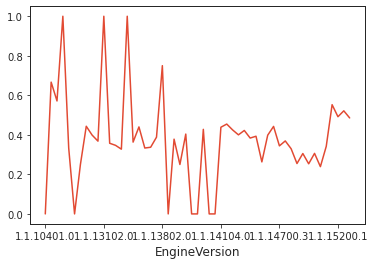

In [ ]:
(explore_cat_values(df, 'EngineVersion')).sort_values(by='EngineVersion')['pct_detected'].plot()

In [ ]:
# parece que ordenado por version, puede existir una cierta tendencia a disminuir, pero se tendrían que analizar los 100% y 0% ya que desvirtuan la tendencia
# podríamos agrupar o tener en cuenta solo las clases con un gran número de registros

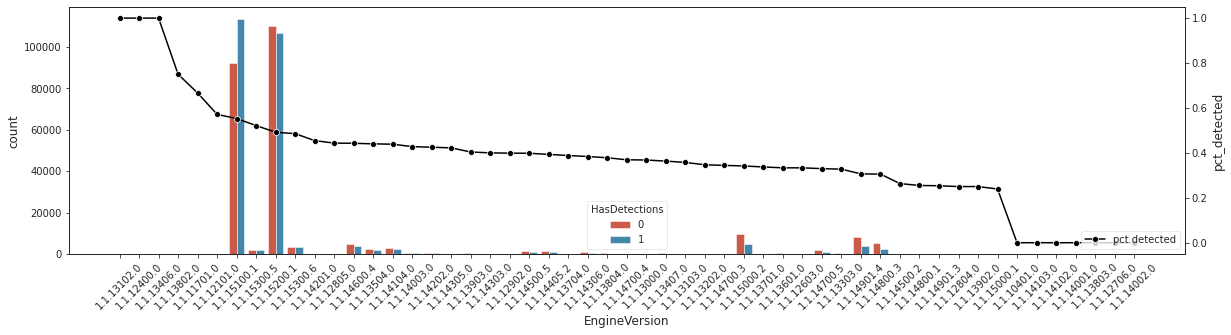

In [ ]:
plot_cat_values(df, 'EngineVersion')

In [ ]:
# Este plot no nos sirve para ver la tendencia, lo necesitaríamos ordenado por index

In [ ]:
# def plot_cat_values_sort(dataframe, column, colsortby):
#   results_df = dataframe.pivot_table(index = column, values = TARGET, dropna=False, aggfunc= [len, sum, np.mean])
#   results_df.columns = ['n_rows', '1-HasDet', 'pct_detected']
#   results_df['0-HasDet'] = results_df['n_rows'] - results_df['1-HasDet']
#   results_df = results_df[['n_rows','1-HasDet','0-HasDet','pct_detected']]
#   results_df = results_df.sort_values(by=colsortby)
#   plt.figure(figsize = [20,10])
#   plt.xticks(rotation=45)

#   ax1 = plt.subplot(2,1,1)        # 2 filas, 1 columna, pintarlo en la 1a posición
#   sns.set_style(style = 'ticks')
#   sns.countplot(data = dataframe, x = column, hue = TARGET, order=results_df.index)
#   plt.xticks(rotation=45)
#   ax2 = ax1.twinx()
#   sns.lineplot(x=results_df.index, y=results_df['pct_detected'], marker = 'o', color = 'black')
#   plt.legend(['pct detected'], loc='lower right')
#   plt.xticks(rotation=45)

#   plt.show()

In [ ]:
def plot_cat_values_sort(dataframe, column, colsortby):
  results_df = dataframe.pivot_table(index = column, values = TARGET, dropna=False, aggfunc= [len, sum, np.mean])
  results_df.columns = ['n_rows', '1-HasDet', 'pct_detected']
  results_df['0-HasDet'] = results_df['n_rows'] - results_df['1-HasDet']
  results_df = results_df[['n_rows','1-HasDet','0-HasDet','pct_detected']]
  results_df = results_df.sort_values(by=colsortby)
  plt.figure(figsize = [20,10])
  plt.xticks(rotation=45)

  ax1 = plt.subplot(2,1,1)        
  sns.set_style(style = 'ticks')
  sns.countplot(data = dataframe, x = column, hue = TARGET, order=results_df.index)
  plt.xticks(rotation=45)
  ax2 = ax1.twinx()
  sns.pointplot(data= results_df, x=results_df.index, y='pct_detected', marker = 'o', color = 'black', order=results_df.index, scale=0.5)
  plt.legend(['pct detected'], loc='lower right')
  plt.xticks(rotation=45)

  plt.show()

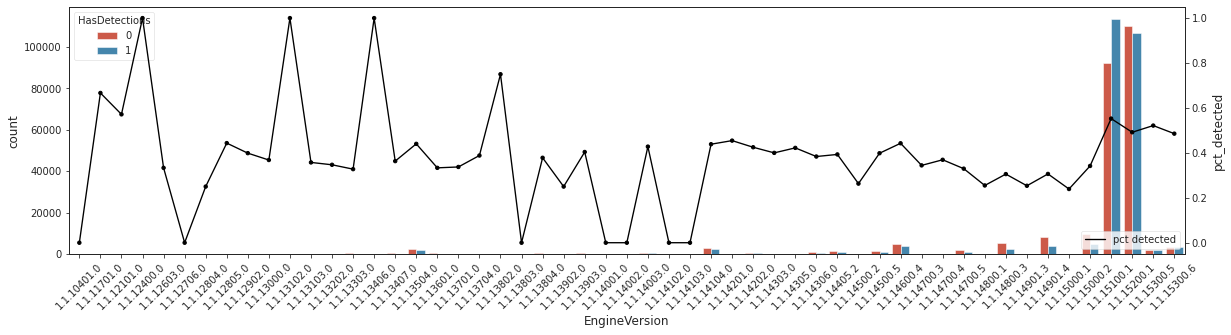

In [ ]:
plot_cat_values_sort(df, 'EngineVersion','EngineVersion' )

In [ ]:
# podemos ver que en las versiones antiguas no hay casi registros
# creamos función para agrupar clases por orden, para llegar a un mínimo de registros y así mantener jerarquía y eliminar 
# valores extremos como clases donde hay solo 1 valor de 100% o 0%

In [ ]:
df_eng_sorted = pd.DataFrame(df['EngineVersion'].value_counts()).sort_index()
df_eng_sorted.columns = ['rows']
df_eng_sorted['sumatorio'] = df_eng_sorted['rows'].cumsum()
df_eng_sorted.head(15)

rows  sumatorio
1.1.10401.0     1          1
1.1.11701.0     3          4
1.1.12101.0     7         11
1.1.12400.0     1         12
1.1.12603.0     3         15
1.1.12706.0     1         16
1.1.12804.0     4         20
1.1.12805.0   115        135
1.1.12902.0   321        456
1.1.13000.0   220        676
1.1.13102.0     1        677
1.1.13103.0   235        912
1.1.13202.0   245       1157
1.1.13303.0   516       1673
1.1.13406.0     1       1674

### Función ENCODE ORDERED GROUPS

In [ ]:
# Función para hacer label encoding pero agrupando clases, para mantener jerarquía pero asegurando un mínimo de registros y alisar valores unicos

In [ ]:
def encode_group_ordered(dataframe, column, min_rows):
  df_sorted = pd.DataFrame(dataframe[column].value_counts()).sort_index()
  df_sorted.columns = ['rows']
  df_sorted['class_'+ column] = 0

  class_counter = 0
  acum_previo = 0
  acumulado = []

  for row in df_sorted.iterrows():

      acum_actual =  row[1]['rows'] + acum_previo

      if acum_actual > min_rows:
          acum_actual = 0
          row[1]['class_'+ column] = class_counter
          class_counter = class_counter + 1

      else:
          row[1]['class_'+ column] = class_counter

      acumulado.append( acum_actual )
      acum_previo = acum_actual

  # df_sorted['acum'] = acumulado
  df_sorted = pd.DataFrame(df_sorted['class_'+ column])
  df_merged = dataframe.merge(df_sorted, right_index=True, left_on=column)
  
  return df_merged.drop(column, axis=1)

#### EngineVersion

In [ ]:
df = encode_group_ordered(df, 'EngineVersion', 1000)

In [ ]:
df['class_EngineVersion'].dtype

dtype('int64')

In [ ]:
df.groupby('class_EngineVersion').size()

class_EngineVersion
0       1157
1       4872
2       1450
3       1327
4       5247
5       1131
6       1329
7       1972
8       2610
9       9005
10      2719
11      7599
12     12055
13     14890
14    205493
15    216491
16      3883
17      6769
dtype: int64

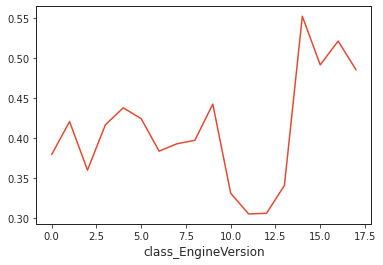

In [ ]:
(explore_cat_values(df, 'class_EngineVersion')).sort_values(by='class_EngineVersion')['pct_detected'].plot()

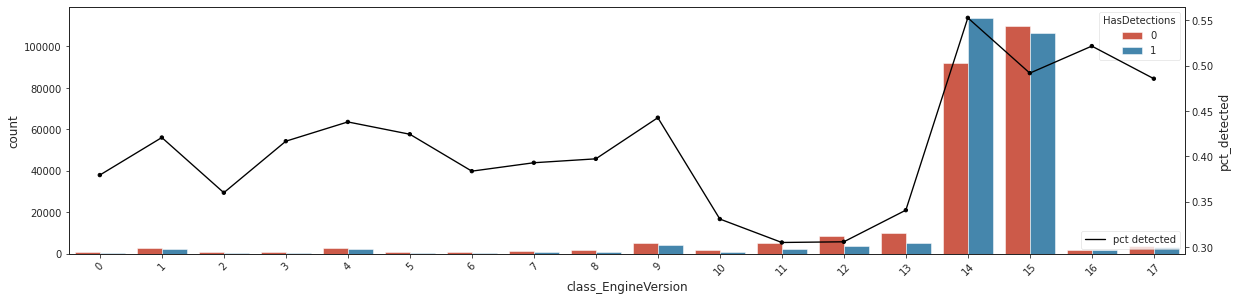

In [ ]:
plot_cat_values_sort(df, 'class_EngineVersion', 'class_EngineVersion')

#### ProductName

In [ ]:
df['ProductName'].value_counts()

win8defender     494603
mse                5395
mseprerelease         1
Name: ProductName, dtype: int64

In [ ]:
explore_cat_values(df, 'ProductName')

n_rows  1-HasDet  0-HasDet  pct_detected
ProductName                                            
win8defender   494603    247367    247236      0.500132
mse              5395      2586      2809      0.479333
mseprerelease       1         0         1      0.000000

In [ ]:
# Se puede observar que tanto para mse como win8defender, ambos tienen un 50% de muestras con virus y sin.
# Como solo existe una muestra con un valor diferente (mseprerelease), la vamos a pasar a mse ya que no distorsionará la variable y tiene más relación que con win8defender
# transformaremos la columna en una 1/0 --> iswin8defender

In [ ]:
# así todo lo que no sea win8defender será un 0
df['ProductName'] = (df['ProductName'] == 'win8defender').astype(int)

In [ ]:
df['ProductName'].value_counts()

1    494603
0      5396
Name: ProductName, dtype: int64

#### AppVersion

In [ ]:
# al ser un versionado investigaremos también su orden

In [ ]:
explore_cat_values(df, 'AppVersion').head(10)

n_rows  1-HasDet  0-HasDet  pct_detected
AppVersion                                                
4.13.17604.1000        1         1         0      1.000000
4.18.1807.18070        1         1         0      1.000000
4.9.10586.456          1         1         0      1.000000
4.15.17650.1001        1         1         0      1.000000
4.18.1806.20033        1         1         0      1.000000
4.13.17618.1000        1         1         0      1.000000
4.17.17685.20082       4         3         1      0.750000
4.8.10240.17914       84        63        21      0.750000
4.10.14393.726        16        11         5      0.687500
4.8.10240.17533        3         2         1      0.666667

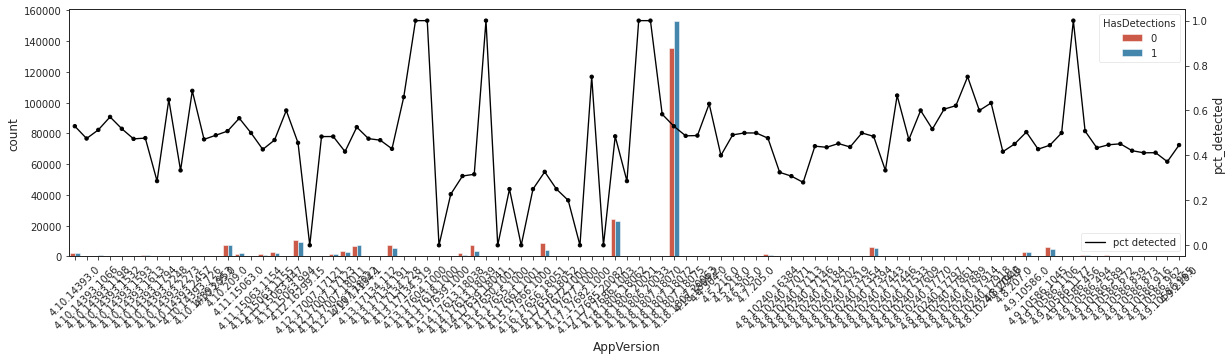

In [ ]:
plot_cat_values_sort(df, 'AppVersion', 'AppVersion')

In [ ]:
# vemos que al ordenarlo a-z y 0-9, coge 10 antes que 4,5,6, etc. así que añadiremos una nueva columna de orden para reordenar correcatamente las versiones y poder aplicar la función de 
# encoding por label orden

In [ ]:
df_appversion = (explore_cat_values(df, 'AppVersion')).sort_values(by='AppVersion')
df_appversion['order'] = 0

df_appvers1 = df_appversion[54:]
df_appvers2 = df_appversion[:54]

In [ ]:
df_appversion = df_appvers1.append(df_appvers2)

df_appversion['order'] = np.arange(len(df_appversion))

In [ ]:
df_appversion

n_rows  1-HasDet  0-HasDet  pct_detected  order
AppVersion                                                       
4.4.304.0             27        17        10      0.629630      0
4.5.216.0             10         4         6      0.400000      1
4.5.218.0            116        57        59      0.491379      2
4.6.305.0             44        22        22      0.500000      3
4.7.205.0             46        23        23      0.500000      4
4.8.10240.16384     2617      1248      1369      0.476882      5
4.8.10240.17071       77        25        52      0.324675      6
4.8.10240.17113       13         4         9      0.307692      7
4.8.10240.17146       50        14        36      0.280000      8
4.8.10240.17184       34        15        19      0.441176      9
4.8.10240.17202       94        41        53      0.436170     10
4.8.10240.17319       53        24        29      0.452830     11
4.8.10240.17354       48        21        27      0.437500     12
4.8.10240.17394       74        37        37      0.500000     13
4.8.10240.17443    11385      5520      5865      0.484848     14
4.8.10240.17446        3         1         2      0.333333     15
4.8.10240.17533        3         2         1      0.666667     16
4.8.10240.17609       17         8         9      0.470588     17
4.8.10240.17770        5         3         2      0.600000     18
4.8.10240.17797       29        15        14      0.517241     19
4.8.10240.17861       33        20        13      0.606061     20
4.8.10240.17889      103        64        39      0.621359     21
4.8.10240.17914       84        63        21      0.750000     22
4.8.10240.17918       25        15        10      0.600000     23
4.8.10240.17946      262       166        96      0.633588     24
4.8.204.0             96        40        56      0.416667     25
4.8.207.0            204        92       112      0.450980     26
4.9.10586.0         6213      3131      3082      0.503943     27
4.9.10586.1045       617       264       353      0.427877     28
4.9.10586.1106     11432      5091      6341      0.445329     29
4.9.10586.1177         2         1         1      0.500000     30
4.9.10586.456          1         1         0      1.000000     31
4.9.10586.494       1383       703       680      0.508315     32
4.9.10586.589        761       330       431      0.433640     33
4.9.10586.672       1198       536       662      0.447412     34
4.9.10586.839        248       112       136      0.451613     35
4.9.10586.873        228        96       132      0.421053     36
4.9.10586.916        311       128       183      0.411576     37
4.9.10586.962        262       108       154      0.412214     38
4.9.10586.965        266        99       167      0.372180     39
4.9.218.0            334       149       185      0.446108     40
4.10.14393.0        4399      2332      2067      0.530120     41
4.10.14393.1066      404       192       212      0.475248     42
4.10.14393.1198     1271       653       618      0.513769     43
4.10.14393.1532        7         4         3      0.571429     44
4.10.14393.1593      536       278       258      0.518657     45
4.10.14393.1613      760       360       400      0.473684     46
4.10.14393.1794     2425      1157      1268      0.477113     47
4.10.14393.2248       14         4        10      0.285714     48
4.10.14393.2273       54        35        19      0.648148     49
4.10.14393.2457        3         1         2      0.333333     50
4.10.14393.726        16        11         5      0.687500     51
4.10.14393.953       403       190       213      0.471464     52
4.10.205.0            49        24        25      0.489796     53
4.10.209.0         15292      7771      7521      0.508174     54
4.11.15063.0        3874      2191      1683      0.565565     55
4.11.15063.1154        2         1         1      0.500000     56
4.11.15063.1155     2477      1057      1420      0.426726     57
4.11.15063.447      5100      2389      2711      0.468431

In [ ]:
pd.DataFrame(df_appversion['order'])

order
AppVersion             
4.4.304.0             0
4.5.216.0             1
4.5.218.0             2
4.6.305.0             3
4.7.205.0             4
4.8.10240.16384       5
4.8.10240.17071       6
4.8.10240.17113       7
4.8.10240.17146       8
4.8.10240.17184       9
4.8.10240.17202      10
4.8.10240.17319      11
4.8.10240.17354      12
4.8.10240.17394      13
4.8.10240.17443      14
4.8.10240.17446      15
4.8.10240.17533      16
4.8.10240.17609      17
4.8.10240.17770      18
4.8.10240.17797      19
4.8.10240.17861      20
4.8.10240.17889      21
4.8.10240.17914      22
4.8.10240.17918      23
4.8.10240.17946      24
4.8.204.0            25
4.8.207.0            26
4.9.10586.0          27
4.9.10586.1045       28
4.9.10586.1106       29
4.9.10586.1177       30
4.9.10586.456        31
4.9.10586.494        32
4.9.10586.589        33
4.9.10586.672        34
4.9.10586.839        35
4.9.10586.873        36
4.9.10586.916        37
4.9.10586.962        38
4.9.10586.965        39
4.9.218.0            40
4.10.14393.0         41
4.10.14393.1066      42
4.10.14393.1198      43
4.10.14393.1532      44
4.10.14393.1593      45
4.10.14393.1613      46
4.10.14393.1794      47
4.10.14393.2248      48
4.10.14393.2273      49
4.10.14393.2457      50
4.10.14393.726       51
4.10.14393.953       52
4.10.205.0           53
4.10.209.0           54
4.11.15063.0         55
4.11.15063.1154      56
4.11.15063.1155      57
4.11.15063.447       58
4.11.15063.994       59
4.12.16299.15        60
4.12.17007.17121     61
4.12.17007.17123     62
4.12.17007.18011     63
4.12.17007.18022     64
4.13.17134.1         65
4.13.17134.112       66
4.13.17134.191       67
4.13.17134.228       68
4.13.17134.319       69
4.13.17604.1000      70
4.13.17618.1000      71
4.13.17639.1000      72
4.14.17613.18038     73
4.14.17613.18039     74
4.14.17639.18041     75
4.15.17650.1001      76
4.15.17655.1000      77
4.15.17661.1001      78
4.15.17666.1000      79
4.16.17656.18051     80
4.16.17656.18052     81
4.17.17672.1000      82
4.17.17677.1000      83
4.17.17682.1000      84
4.17.17685.20082     85
4.17.17686.1003      86
4.18.1806.18062      87
4.18.1806.20021      88
4.18.1806.20033      89
4.18.1807.18070      90
4.18.1807.18072      91
4.18.1807.18075      92
4.18.1807.20063      93
4.18.1809.2          94

In [ ]:
def merge_by_map(dataframe, df_ext, col_ext, column):          # indicar la columna del df_ext que contiene el nuevo valor que se quiere imputar en el dataframe general
  df_map = pd.DataFrame(df_ext[col_ext])
  df_merged = dataframe.merge(df_map, right_index=True, left_on=column)
  df_merged.rename(columns={column : 'original_'+column}, inplace=True)
  df_merged.rename(columns={col_ext : column}, inplace=True)
  return df_merged.drop('original_'+column, axis=1)

In [ ]:
df = merge_by_map(df, df_appversion, 'order','AppVersion')

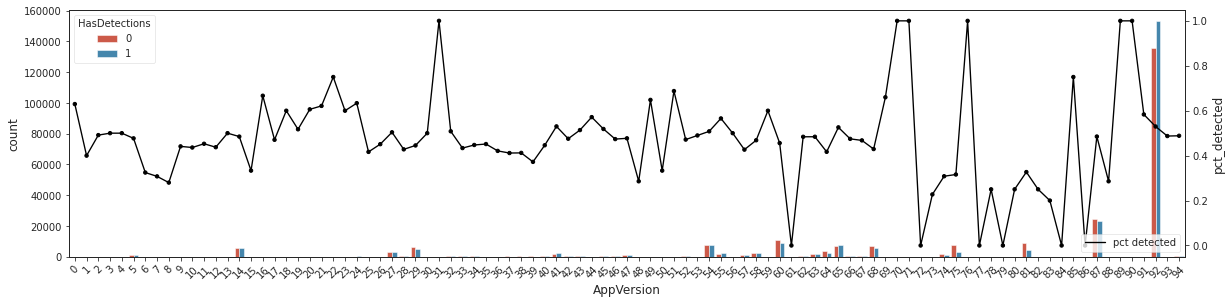

In [ ]:
plot_cat_values_sort(df, 'AppVersion', 'AppVersion')

In [ ]:
# encoding agrupando con la función encode_group_ordered

In [ ]:
df = encode_group_ordered(df, 'AppVersion', 5000)

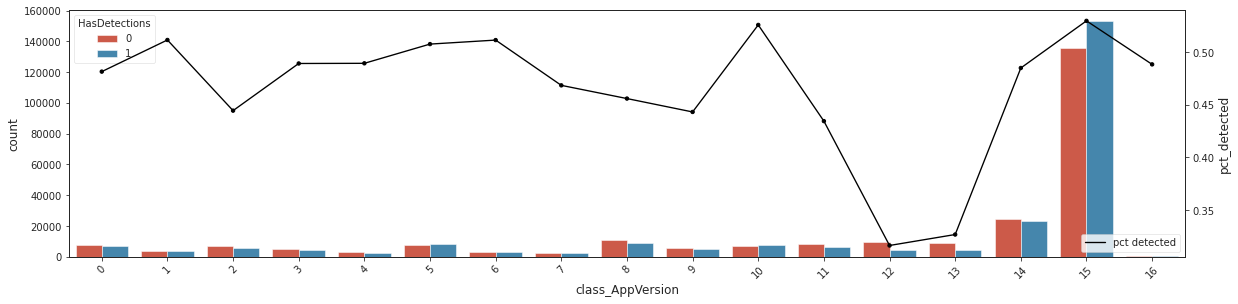

In [ ]:
plot_cat_values_sort(df, 'class_AppVersion', 'class_AppVersion')

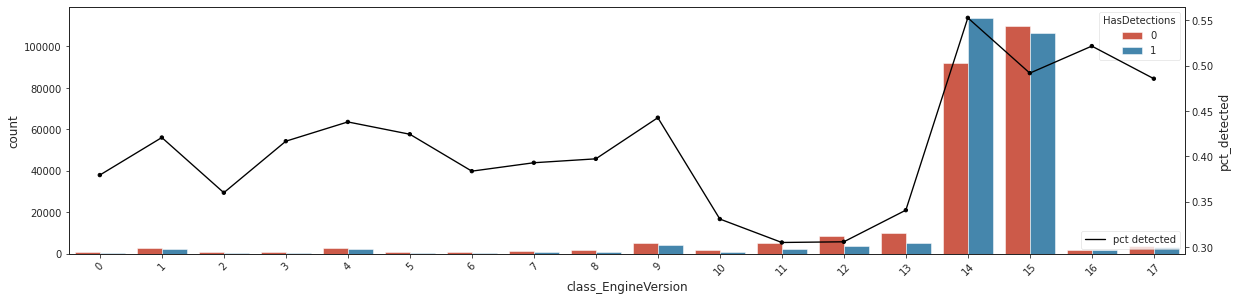

In [ ]:
plot_cat_values_sort(df, 'class_EngineVersion', 'class_EngineVersion')

In [ ]:
# vemos que con una agrupación de minimo 5000 filas, las dos variables son bastante parecidas en comportamiento

In [ ]:
df['class_AppVersion'].corr(df['class_EngineVersion'])

0.34016527428534593

In [ ]:
# aunque visualmente parece evidente, por correlación no obtiene un valor alto así que mantenemos las dos

#### AvSigVersion

In [ ]:
pd.DataFrame(df['AvSigVersion'].value_counts()).sort_index().head(20)

AvSigVersion
0.0.0.0                  4
1.169.55.0               1
1.199.1615.0             3
1.207.1891.0             1
1.207.2950.0             6
1.213.2558.0             1
1.217.1180.0             1
1.217.1286.0             1
1.217.1446.0             1
1.219.115.0              1
1.221.14.0              36
1.221.390.0              1
1.221.439.0              1
1.221.570.0              1
1.223.1196.0             1
1.223.1384.0             1
1.223.1400.0             1
1.223.1429.0             1
1.223.1473.0             1
1.223.1538.0             1

In [ ]:
# muchísimas versiones con solo 1 solo valor, usaremos el encoding para agrupar clases directamente, ya que está bien ordenado

In [ ]:
df = encode_group_ordered(df, 'AvSigVersion', 500)

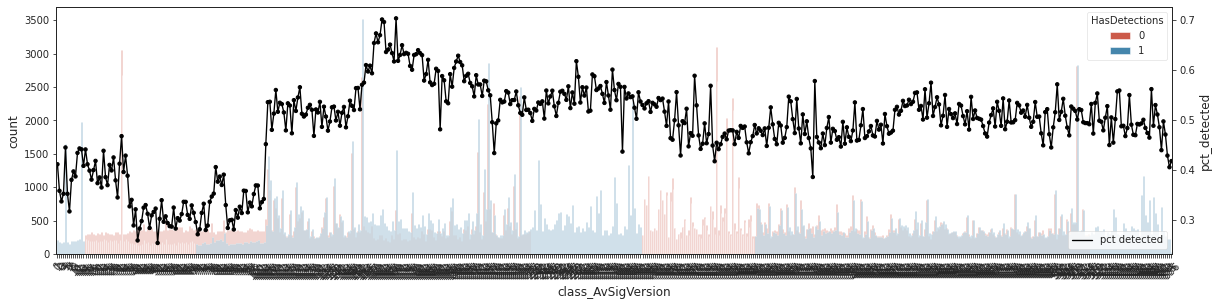

In [ ]:
plot_cat_values_sort(df, 'class_AvSigVersion', 'class_AvSigVersion')

#### OsVer

In [ ]:
explore_cat_values(df, 'OsVer')

n_rows  1-HasDet  0-HasDet  pct_detected
OsVer                                               
10.0.7.0         1         1         0      1.000000
10.0.32.0        1         1         0      1.000000
10.0.8.0         1         1         0      1.000000
10.0.0.1         2         2         0      1.000000
10.0.5.0         1         1         0      1.000000
6.3.7.0          1         1         0      1.000000
10.0.2.0         1         1         0      1.000000
10.0.0.112       1         1         0      1.000000
10.0.3.0        12         9         3      0.750000
10.0.1.0         7         5         2      0.714286
6.3.0.0      10818      5612      5206      0.518765
6.3.1.0          2         1         1      0.500000
10.0.0.0    483829    241755    242074      0.499670
6.1.1.0       5281      2552      2729      0.483242
6.1.0.0         33        10        23      0.303030
10.0.32.72       2         0         2      0.000000
10.0.4.0         1         0         1      0.000000
10.0.80.0        1         0         1      0.000000
6.3.3.0          2         0         2      0.000000
6.3.32.72        1         0         1      0.000000
6.3.5.0          1         0         1      0.000000

In [ ]:
# al existir tan pocas clases y con tan poca variabilidad, eliminaos este atributo

In [ ]:
df.drop('OsVer', axis=1, inplace=True)

#### Census_OSVersion

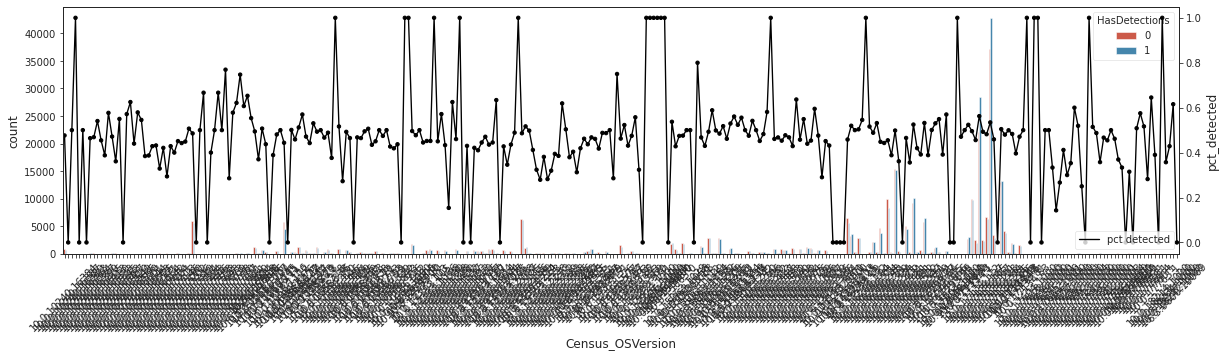

In [ ]:
plot_cat_values_sort(df, 'Census_OSVersion', 'Census_OSVersion')

In [ ]:
# aunque hay algunas versiones mal ordenadas, la mayoría están en orden y al agruparlas, las diferencias se alisarán

In [ ]:
df = encode_group_ordered(df, 'Census_OSVersion', 2000)

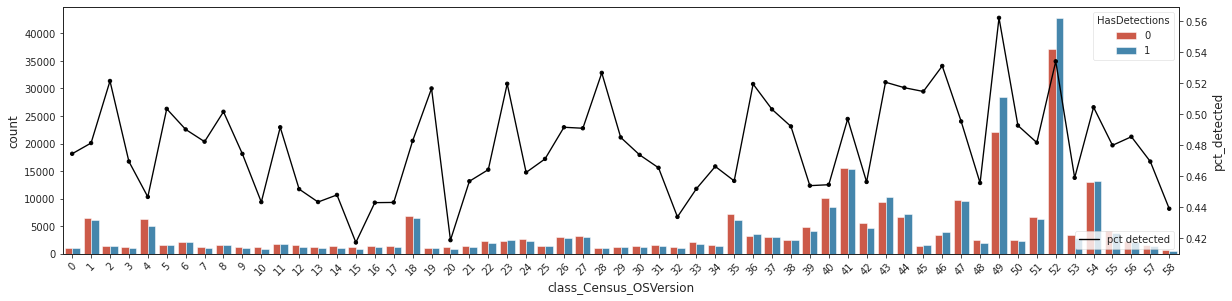

In [ ]:
plot_cat_values_sort(df, 'class_Census_OSVersion', 'class_Census_OSVersion')

#### Census_OSEdition

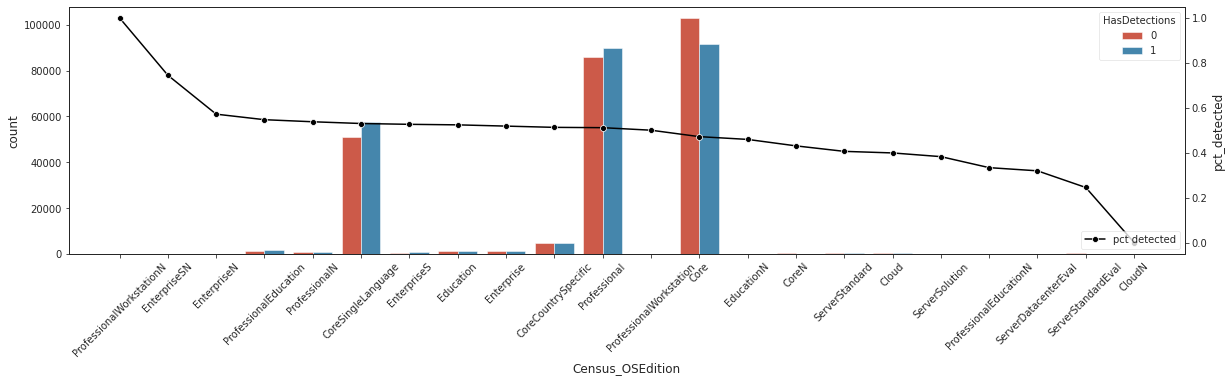

In [ ]:
plot_cat_values(df, 'Census_OSEdition')

In [ ]:
df['Census_OSEdition'].value_counts()

Core                        194469
Professional                175807
CoreSingleLanguage          108696
CoreCountrySpecific           9275
ProfessionalEducation         3100
Education                     2310
Enterprise                    2055
ProfessionalN                 1624
EnterpriseS                   1108
ServerStandard                 584
Cloud                          336
CoreN                          251
ServerStandardEval             151
EducationN                      61
EnterpriseSN                    47
ServerDatacenterEval            47
ServerSolution                  34
EnterpriseN                     28
ProfessionalEducationN          12
ProfessionalWorkstation          2
CloudN                           1
ProfessionalWorkstationN         1
Name: Census_OSEdition, dtype: int64

In [ ]:
# Hacemos un setothers para posterior OHE

In [ ]:
df['Census_OSEdition'] = setOthers(df, 'Census_OSEdition', 13)

In [ ]:
df['Census_OSEdition'].value_counts()

Core                     194469
Professional             175807
CoreSingleLanguage       108696
CoreCountrySpecific        9275
ProfessionalEducation      3100
Education                  2310
Enterprise                 2055
ProfessionalN              1624
EnterpriseS                1108
ServerStandard              584
Cloud                       336
CoreN                       251
Others                      233
ServerStandardEval          151
Name: Census_OSEdition, dtype: int64

#### Processor

In [ ]:
explore_cat_values(df, 'Processor')

n_rows  1-HasDet  0-HasDet  pct_detected
Processor                                          
x64        454422    232321    222101      0.511245
x86         45563     17632     27931      0.386981
arm64          14         0        14      0.000000

In [ ]:
df['Processor'] = df['Processor'].replace('arm64', 'x64')

In [ ]:
explore_cat_values(df, 'Processor')

n_rows  1-HasDet  0-HasDet  pct_detected
Processor                                          
x64        454436    232321    222115      0.511229
x86         45563     17632     27931      0.386981

In [ ]:
# OHE por hacer

#### OsPlatformSubRelease

In [ ]:
explore_cat_values(df, 'OsPlatformSubRelease')

n_rows  1-HasDet  0-HasDet  pct_detected
OsPlatformSubRelease                                          
rs4                   220778    114996    105782      0.520867
windows8.1             10825      5614      5211      0.518614
rs3                   139901     68735     71166      0.491312
th1                    15014      7309      7705      0.486812
windows7                5314      2562      2752      0.482123
rs2                    43352     20778     22574      0.479286
rs1                    40717     18848     21869      0.462902
th2                    22955     10608     12347      0.462122
prers5                  1143       503       640      0.440070

In [ ]:
order = ['windows7', 'windows8.1','th1', 'th2','rs1', 'rs2', 'rs3', 'rs4', 'prers5']
# https://support.lenovo.com/us/en/solutions/ht502786-how-to-identify-your-windows-10-version-a-list-of-windows-10-versions

In [ ]:
df = LE_list(df, 'OsPlatformSubRelease', order)

In [ ]:
df['class_OsPlatformSubRelease'].value_counts()

7    220778
6    139901
5     43352
4     40717
3     22955
2     15014
1     10825
0      5314
8      1143
Name: class_OsPlatformSubRelease, dtype: int64

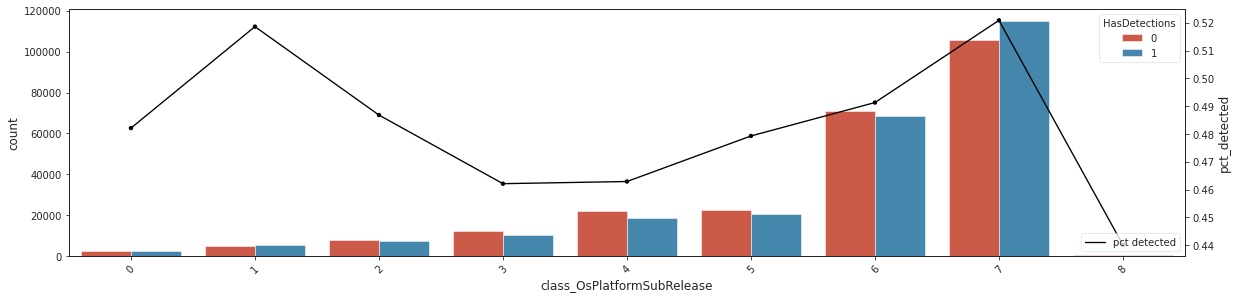

In [ ]:
plot_cat_values_sort(df, 'class_OsPlatformSubRelease', 'class_OsPlatformSubRelease')

#### SkuEdition

In [ ]:
explore_cat_values(df, 'SkuEdition')

n_rows  1-HasDet  0-HasDet  pct_detected
SkuEdition                                               
Enterprise LTSB    1141       614       527      0.538124
Education          2321      1202      1119      0.517880
Enterprise         1999      1035       964      0.517759
Pro              181041     92853     88188      0.512884
Home             308567    152007    156560      0.492622
Invalid            4423      2069      2354      0.467782
Cloud               309       121       188      0.391586
Server              198        52       146      0.262626

In [ ]:
df['SkuEdition'] = setOthers(df, 'SkuEdition', 8)

#### SmartScreen

In [ ]:
# tiene NaNs!

In [ ]:
explore_cat_values(df, 'SmartScreen')

n_rows  1-HasDet  0-HasDet  pct_detected
SmartScreen                                           
ExistsNotSet   58497     47115     11382      0.805426
On                53        36        17      0.679245
off               75        43        32      0.573333
Warn            7530      4306      3224      0.571846
&#x02;            20        11         9      0.550000
Block           1274       640       634      0.502355
on                 8         4         4      0.500000
Off            10388      5055      5333      0.486619
Prompt          1950       928      1022      0.475897
RequireAdmin  241593    105890    135703      0.438299
&#x01;            14         6         8      0.428571
requireadmin       1         0         1      0.000000

In [ ]:
df['SmartScreen'] = df['SmartScreen'].replace('requireadmin', 'RequireAdmin')
df['SmartScreen'] = df['SmartScreen'].replace('on', 'On')
df['SmartScreen'] = df['SmartScreen'].replace('off', 'Off')

In [ ]:
dummy_explore(df, 'SmartScreen')

n_rows  1-HasDet  0-HasDet  pct_detected
SmartScreen                                           
ExistsNotSet   58497     47115     11382      0.805426
On                61        40        21      0.655738
Warn            7530      4306      3224      0.571846
&#x02;            20        11         9      0.550000
Block           1274       640       634      0.502355
Off            10463      5098      5365      0.487241
dummy         178596     85919     92677      0.481080
Prompt          1950       928      1022      0.475897
RequireAdmin  241594    105890    135704      0.438297
&#x01;            14         6         8      0.428571

In [ ]:
# pasaremos los dummies (antiguos nans) a Off ya que coincide tanto por pct_detected como por el sentido de la varible (off=0)

In [ ]:
df['SmartScreen'] = df['SmartScreen'].replace('dummy', 'Off')

In [ ]:
df['SmartScreen'] = setOthers(df, 'SmartScreen', 6)

In [ ]:
explore_cat_values(df, 'SmartScreen')

n_rows  1-HasDet  0-HasDet  pct_detected
SmartScreen                                           
ExistsNotSet   58497     47115     11382      0.805426
Others            95        57        38      0.600000
Warn            7530      4306      3224      0.571846
Block           1274       640       634      0.502355
Off           189059     91017     98042      0.481421
Prompt          1950       928      1022      0.475897
RequireAdmin  241594    105890    135704      0.438297

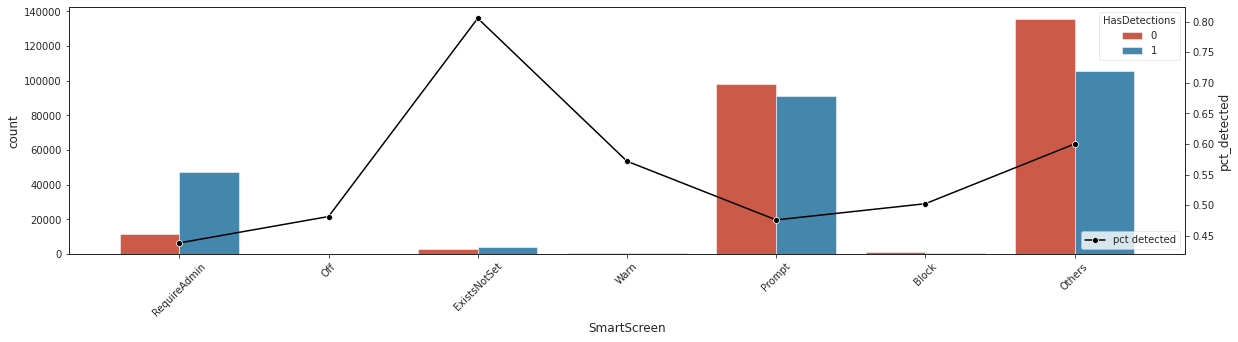

In [ ]:
plot_cat_values(df, 'SmartScreen')

#### Census_MDC2FormFactor

In [ ]:
explore_cat_values(df, 'Census_MDC2FormFactor')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_MDC2FormFactor                                          
Desktop                109526     57306     52220      0.523218
AllInOne                16372      8384      7988      0.512094
Notebook               320948    161411    159537      0.502919
Convertible             22369     11025     11344      0.492870
PCOther                  7800      3715      4085      0.476282
SmallServer               496       191       305      0.385081
Detachable              16802      6351     10451      0.377991
MediumServer              192        62       130      0.322917
LargeTablet              3645      1138      2507      0.312209
SmallTablet              1797       360      1437      0.200334
LargeServer                50        10        40      0.200000
ServerOther                 2         0         2      0.000000

In [ ]:
df['Census_MDC2FormFactor'] = setOthers(df, 'Census_MDC2FormFactor', 9)

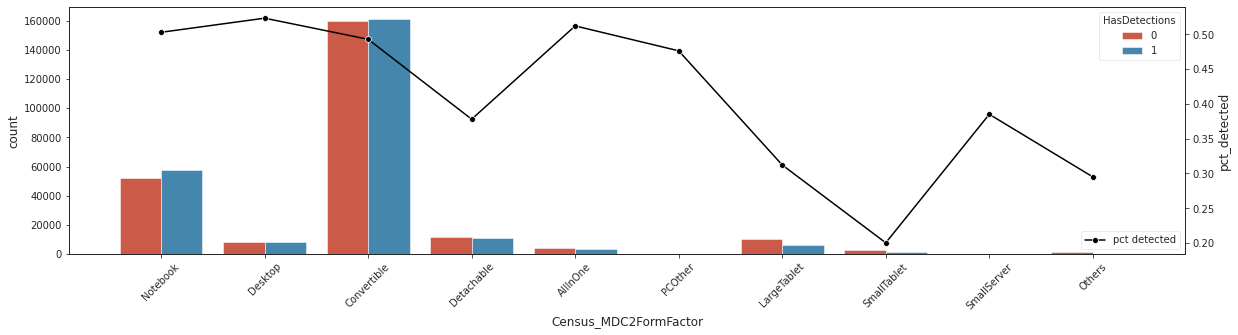

In [ ]:
plot_cat_values(df, 'Census_MDC2FormFactor')

#### Census_DeviceFamily

In [ ]:
explore_cat_values(df, 'Census_DeviceFamily')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_DeviceFamily                                          
Windows.Desktop      499182    249651    249531      0.500120
Windows.Server          816       302       514      0.370098
Windows                   1         0         1      0.000000

In [ ]:
# lo pasaremos a desktop ya que al ser de un censo, entendemos que la persona que responde simplemente Windows es porque no concibe que haya diferentes tipos.
# por tanto se estará refiriendo al genérico de desktop

In [ ]:
df['Census_DeviceFamily'] = df['Census_DeviceFamily'].replace('Windows', 'Windows.Desktop')

In [ ]:
# lo pasaremos a una variable booleana ya que solo hay 2 clases

In [ ]:
df['Census_DeviceFamily'] = df['Census_DeviceFamily'].replace('Windows.Desktop', 1)
df['Census_DeviceFamily'] = df['Census_DeviceFamily'].replace('Windows.Server', 0)

In [ ]:
explore_cat_values(df, 'Census_DeviceFamily')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_DeviceFamily                                          
1                    499183    249651    249532      0.500119
0                       816       302       514      0.370098

#### Census_ProcessorClass

In [ ]:
dummy_explore(df, 'Census_ProcessorClass')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_ProcessorClass                                          
high                      340       211       129      0.620588
mid                      1196       679       517      0.567726
low                       546       287       259      0.525641
dummy                  497917    248776    249141      0.499633

In [ ]:
l = ['low', 'mid', 'high', 'dummy']

In [ ]:
df =LE_list(df, 'Census_ProcessorClass', l)

In [ ]:
explore_cat_values(df, 'class_Census_ProcessorClass')

n_rows  1-HasDet  0-HasDet  pct_detected
class_Census_ProcessorClass                                          
2                               340       211       129      0.620588
1                              1196       679       517      0.567726
0                               546       287       259      0.525641
3                            497917    248776    249141      0.499633

In [ ]:
# pasaremos las dummy/nans a un valor extremo para poder mantener el orden y aislar los dummies

In [ ]:
df['class_Census_ProcessorClass'] = df['class_Census_ProcessorClass'].replace(3, -1)

#### Census_PrimaryDiskTypeName

In [ ]:
df['Census_PrimaryDiskTypeName'].value_counts(dropna=False)

HDD            325429
SSD            138155
UNKNOWN         20082
Unspecified     15624
NaN               709
Name: Census_PrimaryDiskTypeName, dtype: int64

In [ ]:
dummy_explore(df, 'Census_PrimaryDiskTypeName')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_PrimaryDiskTypeName                                          
HDD                         325429    164762    160667      0.506292
SSD                         138155     68821     69334      0.498143
dummy                          709       351       358      0.495063
UNKNOWN                      20082      9019     11063      0.449109
Unspecified                  15624      7000      8624      0.448029

In [ ]:
df['Census_PrimaryDiskTypeName'] = setOthers(df, 'Census_PrimaryDiskTypeName', 2)

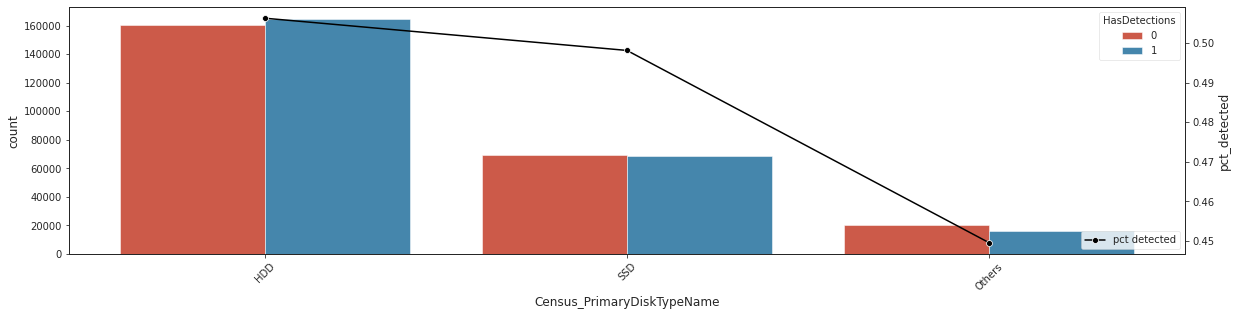

In [ ]:
plot_cat_values(df, 'Census_PrimaryDiskTypeName')

#### Census_ChassisTypeName

In [ ]:
dummy_explore(df, 'Census_ChassisTypeName')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_ChassisTypeName                                          
31                           2         2         0      1.000000
32                           1         1         0      1.000000
MiniTower                 4849      2597      2252      0.535574
Desktop                 104978     55150     49828      0.525348
Tower                      692       362       330      0.523121
LowProfileDesktop         2878      1481      1397      0.514593
AllinOne                 11407      5831      5576      0.511177
Notebook                294232    147270    146962      0.500523
SubChassis                   2         1         1      0.500000
Laptop                   38261     18864     19397      0.493035
Convertible               4685      2252      2433      0.480683
Portable                 20181      9696     10485      0.480452
SpaceSaving               1689       807       882      0.477798
dummy                       37        17        20      0.459459
LunchBox                   224       102       122      0.455357
MainServerChassis          512       228       284      0.445312
UNKNOWN                   3695      1636      2059      0.442760
Unknown                    575       247       328      0.429565
0                            5         2         3      0.400000
BusExpansionChassis         38        15        23      0.394737
SubNotebook                 47        17        30      0.361702
Tablet                     730       263       467      0.360274
Detachable                2930      1020      1910      0.348123
MiniPC                     261        89       172      0.340996
35                           3         1         2      0.333333
MultisystemChassis           3         1         2      0.333333
PizzaBox                     3         1         2      0.333333
RackMountChassis           189        62       127      0.328042
HandHeld                  2652       784      1868      0.295626
Other                     4215      1151      3064      0.273072
30                          11         3         8      0.272727
StickPC                      7         0         7      0.000000
Blade                        3         0         3      0.000000
25                           1         0         1      0.000000
ExpansionChassis             1         0         1      0.000000

In [ ]:
df['Census_ChassisTypeName'] = setOthersHeadTail(df, 'Census_ChassisTypeName', 500, 5)

In [ ]:
explore_cat_values(df, 'Census_ChassisTypeName')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_ChassisTypeName                                          
MiniTower                 4849      2597      2252      0.535574
Desktop                 104978     55150     49828      0.525348
Tower                      692       362       330      0.523121
LowProfileDesktop         2878      1481      1397      0.514593
AllinOne                 11407      5831      5576      0.511177
Others                  364093    181067    183026      0.497310
Unknown                    575       247       328      0.429565
Tablet                     730       263       467      0.360274
Detachable                2930      1020      1910      0.348123
HandHeld                  2652       784      1868      0.295626
Other                     4215      1151      3064      0.273072

#### Census_PowerPlatformRoleName

In [ ]:
dummy_explore(df, 'Census_PowerPlatformRoleName')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_PowerPlatformRoleName                                          
PerformanceServer                  4         3         1      0.750000
Desktop                       116053     60942     55111      0.525122
Workstation                     6235      3198      3037      0.512911
Mobile                        346378    173910    172468      0.502082
SOHOServer                      2062      1024      1038      0.496605
UNKNOWN                         1172       571       601      0.487201
EnterpriseServer                 406       177       229      0.435961
Slate                          27475     10082     17393      0.366952
AppliancePC                      212        46       166      0.216981
dummy                              2         0         2      0.000000

In [ ]:
df['Census_PowerPlatformRoleName'] = setOthers(df, 'Census_PowerPlatformRoleName', 7)

In [ ]:
explore_cat_values(df, 'Census_PowerPlatformRoleName')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_PowerPlatformRoleName                                          
Desktop                       116053     60942     55111      0.525122
Workstation                     6235      3198      3037      0.512911
Mobile                        346378    173910    172468      0.502082
SOHOServer                      2062      1024      1038      0.496605
UNKNOWN                         1172       571       601      0.487201
EnterpriseServer                 406       177       229      0.435961
Slate                          27475     10082     17393      0.366952
Others                           218        49       169      0.224771

#### Census_InternalBatteryType

In [ ]:
dummy_explore(df, 'Census_InternalBatteryType')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_InternalBatteryType                                          
icp3                             1         1         0      1.000000
lgl0                             1         1         0      1.000000
li-l                             1         1         0      1.000000
lipp                             3         2         1      0.666667
lgi0                            29        17        12      0.586207
unkn                            19        11         8      0.578947
lip                           3326      1791      1535      0.538485
real                           162        85        77      0.524691
#                            10175      5321      4854      0.522948
dummy                       355603    179829    175774      0.505702
a132                             2         1         1      0.500000
pbac                           130        65        65      0.500000
li-i                         13855      6718      7137      0.484879
lion                        113500     54715     58785      0.482070
li p                           466       218       248      0.467811
lipo                            13         6         7      0.461538
liio                          1814       830       984      0.457552
nimh                           272       118       154      0.433824
li                             356       154       202      0.432584
lhp0                            12         4         8      0.333333
bad                              3         1         2      0.333333
ithi                             7         2         5      0.285714
bq20                           143        38       105      0.265734
vbox                            89        22        67      0.247191
ram                              5         1         4      0.200000
4cel                             6         1         5      0.166667
3ion                             1         0         1      0.000000
batt                             3         0         3      0.000000
virt                             2         0         2      0.000000

In [ ]:
df['Census_InternalBatteryType'] = setOthersHeadTail(df, 'Census_InternalBatteryType', 100, 6)

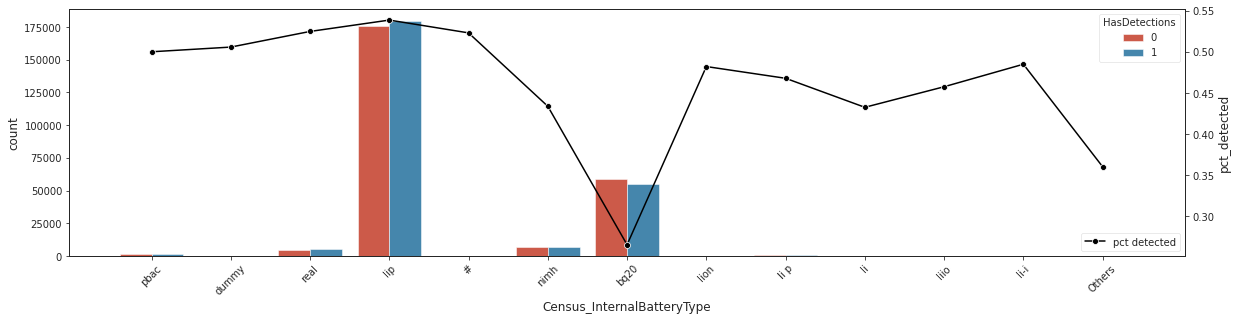

In [ ]:
plot_cat_values(df, 'Census_InternalBatteryType')

#### Census_OSArchitecture

In [ ]:
explore_cat_values(df, 'Census_OSArchitecture')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_OSArchitecture                                          
amd64                  454434    232267    222167      0.511113
x86                     45551     17686     27865      0.388268
arm64                      14         0        14      0.000000

In [ ]:
# ARM64, also known as ARMv8-A, is the 64-bit version of the advanced risc machine (ARM) architecture primarily designed for smartphones and interconnected devices.
# AMD64 is the 64-bit extension of the popular x86 architecture which was originally developed by Intel. It was later extended to 64-bit by AMD (hence the AMD64 name, 
# also called x86-64) and is the de-facto architecture for personal computers and servers.

# así que pasamos la arm64 a x86

In [ ]:
df['Census_OSArchitecture'] = df['Census_OSArchitecture'].replace('arm64', 'x86')

In [ ]:
df['Census_OSArchitecture'] = df['Census_OSArchitecture'].replace('amd64', 1)
df['Census_OSArchitecture'] = df['Census_OSArchitecture'].replace('x86', 0)

In [ ]:
explore_cat_values(df, 'Census_OSArchitecture')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_OSArchitecture                                          
1                      454434    232267    222167      0.511113
0                       45565     17686     27879      0.388149

#### Census_OSBranch

In [ ]:
explore_cat_values(df, 'Census_OSBranch')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_OSBranch                                                    
rs_prerelease_flt             132        69        63      0.522727
rs4_release                226000    118008    107992      0.522159
rs3_release_svc_escrow      67027     34572     32455      0.515792
th1_st1                     10822      5451      5371      0.503696
th2_release                 18298      9022      9276      0.493059
rs2_release                 44264     21230     23034      0.479622
rs1_release                 43705     20322     23383      0.464981
rs3_release                 69216     32176     37040      0.464864
th2_release_sec             14895      6638      8257      0.445653
th1                          4284      1892      2392      0.441643
rs5_release                   839       364       475      0.433850
rs_prerelease                 184        76       108      0.413043
rs3_release_svc_escrow_im     329       132       197      0.401216
rs5_release_sigma               3         1         2      0.333333
winblue_ltsb_escrow             1         0         1      0.000000

In [ ]:
df['Census_OSBranch'] = df['Census_OSBranch'].replace('rs5_release_sigma', 'rs5_release')
df['Census_OSBranch'] = df['Census_OSBranch'].replace('winblue_ltsb_escrow', 'th1')
df['Census_OSBranch'] = df['Census_OSBranch'].replace('rs_prerelease_flt', 'rs_prerelease')
df['Census_OSBranch'] = df['Census_OSBranch'].replace('rs3_release_svc_escrow_im', 'rs3_release_svc_escrow')
df['Census_OSBranch'] = df['Census_OSBranch'].replace('th1_st1', 'th1')

In [ ]:
# Windows 11 Build 22458 (RS_PRERELEASE) 

In [ ]:
order = ['th1', 'th2_release', 'th2_release_sec', 'rs1_release', 'rs2_release','rs3_release', 'rs3_release_svc_escrow', 'rs4_release', 'rs5_release', 'rs_prerelease' ]

In [ ]:
df = LE_list(df, 'Census_OSBranch', order)

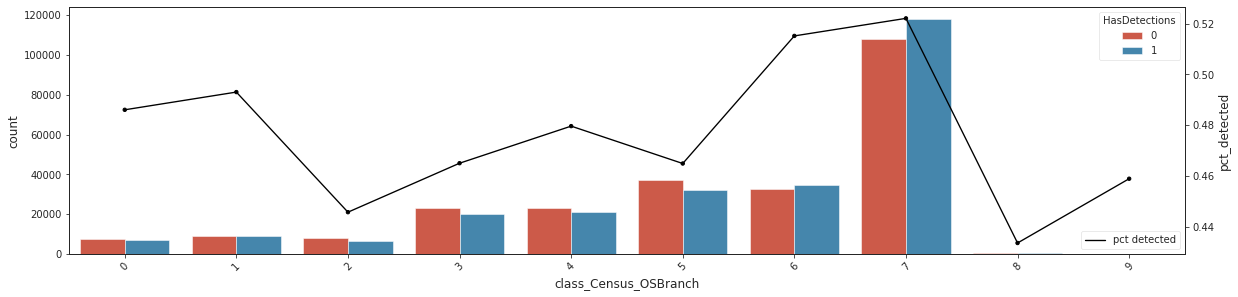

In [ ]:
plot_cat_values_sort(df, 'class_Census_OSBranch', 'class_Census_OSBranch')

#### Census_OSSkuName

In [ ]:
explore_cat_values(df, 'Census_OSSkuName')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_OSSkuName                                                      
UNLICENSED                         1         1         0      1.000000
PRO_WORKSTATION_N                  1         1         0      1.000000
ENTERPRISE_S_N                    48        35        13      0.729167
ENTERPRISE_N                      28        16        12      0.571429
PROFESSIONAL_N                  1634       875       759      0.535496
CORE_SINGLELANGUAGE           108674     57578     51096      0.529823
ENTERPRISE_S                    1107       583       524      0.526649
EDUCATION                       2313      1213      1100      0.524427
ENTERPRISE                      2063      1067       996      0.517208
CORE_COUNTRYSPECIFIC            9257      4743      4514      0.512369
PROFESSIONAL                  178946     91603     87343      0.511903
PRO_WORKSTATION                    2         1         1      0.500000
CORE                          194464     91666    102798      0.471378
EDUCATION_N                       61        28        33      0.459016
CORE_N                           251       108       143      0.430279
STANDARD_SERVER                  584       237       347      0.405822
CLOUD                            332       133       199      0.400602
SB_SOLUTION_SERVER                34        13        21      0.382353
DATACENTER_EVALUATION_SERVER      47        15        32      0.319149
STANDARD_EVALUATION_SERVER       151        37       114      0.245033
CLOUDN                             1         0         1      0.000000

In [ ]:
df['Census_OSSkuName'] = setOthersHeadTail(df, 'Census_OSSkuName', 100, 6)

In [ ]:
explore_cat_values(df, 'Census_OSSkuName')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_OSSkuName                                                    
PROFESSIONAL_N                1634       875       759      0.535496
CORE_SINGLELANGUAGE         108674     57578     51096      0.529823
ENTERPRISE_S                  1107       583       524      0.526649
EDUCATION                     2313      1213      1100      0.524427
ENTERPRISE                    2063      1067       996      0.517208
CORE_COUNTRYSPECIFIC          9257      4743      4514      0.512369
PROFESSIONAL                178946     91603     87343      0.511903
Others                         223       110       113      0.493274
CORE                        194464     91666    102798      0.471378
CORE_N                         251       108       143      0.430279
STANDARD_SERVER                584       237       347      0.405822
CLOUD                          332       133       199      0.400602
STANDARD_EVALUATION_SERVER     151        37       114      0.245033

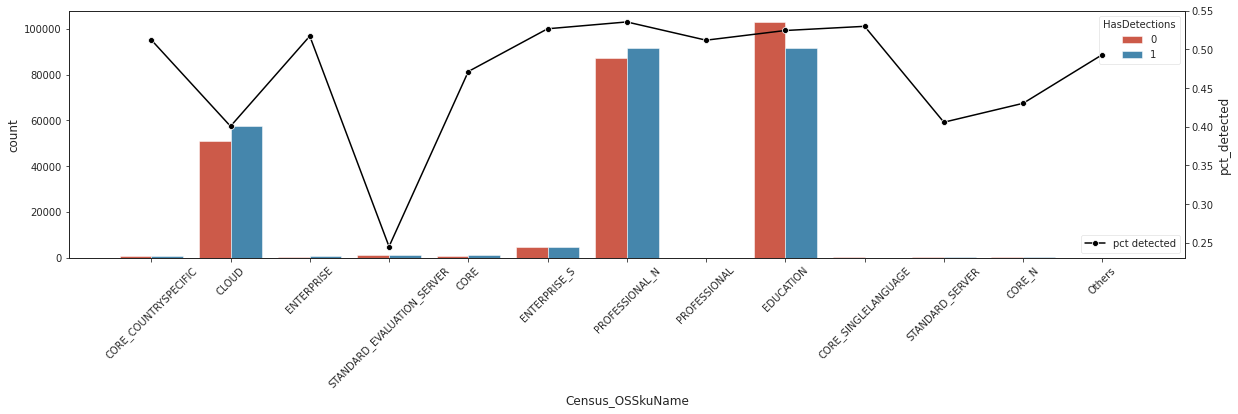

In [ ]:
plot_cat_values(df, 'Census_OSSkuName')

#### Census_OSInstallTypeName

In [ ]:
explore_cat_values(df, 'Census_OSInstallTypeName')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_OSInstallTypeName                                          
UUPUpgrade                146780     77129     69651      0.525473
Clean                       3885      2032      1853      0.523037
IBSClean                   92403     48304     44099      0.522754
Reset                      36510     17605     18905      0.482197
Update                     88891     42499     46392      0.478102
Other                      46960     22409     24551      0.477193
Upgrade                    70013     33254     36759      0.474969
CleanPCRefresh              3017      1395      1622      0.462380
Refresh                    11540      5326      6214      0.461525

In [ ]:
# OHE directo

#### Census_OSWUAutoUpdateOptionsName

In [ ]:
explore_cat_values(df, 'Census_OSWUAutoUpdateOptionsName')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_OSWUAutoUpdateOptionsName                                               
FullAuto                               222481    114807    107674      0.516031
UNKNOWN                                140961     70190     70771      0.497939
Off                                      1506       732       774      0.486056
AutoInstallAndRebootAtMaintenanceTime   20731     10056     10675      0.485071
Notify                                 113507     53867     59640      0.474570
DownloadNotify                            813       301       512      0.370234

In [ ]:
# OHE directo

#### Census_GenuineStateName

In [ ]:
explore_cat_values(df, 'Census_GenuineStateName')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_GenuineStateName                                          
OFFLINE                   12834      6994      5840      0.544959
IS_GENUINE               441401    220477    220924      0.499494
INVALID_LICENSE           44990     22236     22754      0.494243
UNKNOWN                     774       246       528      0.317829

In [ ]:
# OHE directo

#### Census_ActivationChannel

In [ ]:
explore_cat_values(df, 'Census_ActivationChannel')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_ActivationChannel                                          
Volume:GVLK                25108     14963     10145      0.595946
OEM:NONSLP                 17943      9314      8629      0.519088
OEM:DM                    191350     94880     96470      0.495845
Retail                    264932    130532    134400      0.492700
Volume:MAK                   468       212       256      0.452991
Retail:TB:Eval               198        52       146      0.262626

In [ ]:
# OHE directo

#### Census_FlightRing

In [ ]:
explore_cat_values(df, 'Census_FlightRing')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_FlightRing                                          
RP                    583       299       284      0.512864
Retail             468298    234693    233605      0.501162
NOT_SET             16044      7980      8064      0.497382
Unknown             13701      6378      7323      0.465513
WIF                   549       253       296      0.460838
Disabled              217       100       117      0.460829
WIS                   606       250       356      0.412541
OSG                     1         0         1      0.000000

In [ ]:
df['Census_FlightRing'] = df['Census_FlightRing'].replace('OSG', 'Unknown')

In [ ]:
# OHE 

## Numéricas

### Variables correlacionadas

#### OsBuild vs Census_OSBuildNumber

In [ ]:
df['OsBuild'].corr(df['Census_OSBuildNumber'])

0.9376599660732158

In [ ]:
df['OsBuild']

MachineIdentifier
f1cd864e97bae82bdf96523e1a539121    17134
f045ba8adeb047ad57e477f413465428    17134
77b631464f8cea84272190b77e9412bb    17134
40145ca0d172feec790ff99f33439111    17134
7f497d8907751e5870a855d84bdfd280    17134
                                    ...  
c529adef1e501f26b836c6f1a77d0751    16299
b81d9011b8967cfaddf4904d6c9ab300    10240
5196f04b32b11003b1dae5b1eab8e711     9600
6fd529ae4fabc541a2f22a07188f6539    10240
0e599d21562743799e185f00173d22ee     9600
Name: OsBuild, Length: 499999, dtype: int64

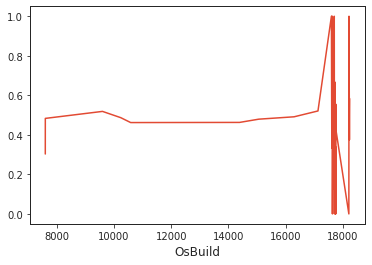

In [ ]:
explore_cat_values(df, 'OsBuild').sort_index(ascending=False)['pct_detected'].plot()

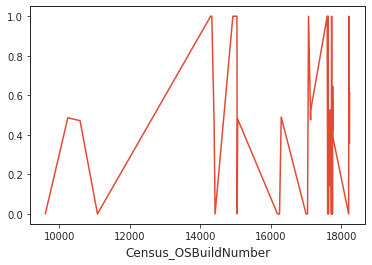

In [ ]:
explore_cat_values(df, 'Census_OSBuildNumber').sort_index(ascending=False)['pct_detected'].plot()

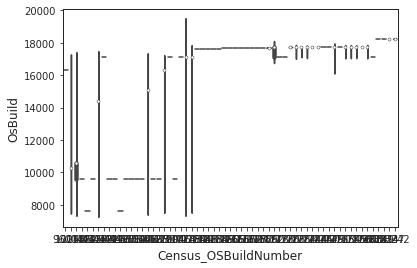

In [ ]:
sns.violinplot(data=df, x='Census_OSBuildNumber', y='OsBuild')

In [ ]:
# nos quedamos con Census_OSBuildNumber ya que tiene más valores únicos y más variabilidad

df.drop('OsBuild', axis=1, inplace=True)

#### Census_ProcessorManufacturerIdentifier vs Census_ProcessorModelIdentifier

In [ ]:
df['Census_ProcessorManufacturerIdentifier'].corr(df['Census_ProcessorModelIdentifier'])

0.7991077905527135

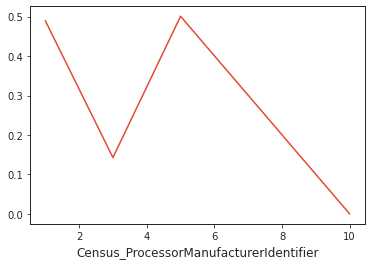

In [ ]:
explore_cat_values(df, 'Census_ProcessorManufacturerIdentifier').sort_index(ascending=False)['pct_detected'].plot()

In [ ]:
explore_cat_values(df, 'Census_ProcessorManufacturerIdentifier')

n_rows  ...  pct_detected
Census_ProcessorManufacturerIdentifier          ...              
5.0                                     439028  ...      0.500989
1.0                                      58603  ...      0.489702
3.0                                          7  ...      0.142857
10.0                                        14  ...      0.000000

[4 rows x 4 columns]

In [ ]:
# muy poca variabilidad entre las clases que tienen datos suficientes
df.drop('Census_ProcessorManufacturerIdentifier', axis=1, inplace=True)

In [ ]:
explore_cat_values(df, 'Census_ProcessorModelIdentifier').sort_index(ascending=False)

n_rows  1-HasDet  0-HasDet  pct_detected
Census_ProcessorModelIdentifier                                          
4472.0                                3         0         3      0.000000
4471.0                                1         0         1      0.000000
4469.0                                9         2         7      0.222222
4468.0                                7         2         5      0.285714
4441.0                                1         0         1      0.000000
...                                 ...       ...       ...           ...
27.0                                  2         1         1      0.500000
25.0                                 12         9         3      0.750000
23.0                                 11         7         4      0.636364
19.0                                 58        36        22      0.620690
3.0                                   1         0         1      0.000000

[2243 rows x 4 columns]

In [ ]:
# rellenamos los nans con -1 para que sea un valor extremo

In [ ]:
df['Census_ProcessorModelIdentifier'].fillna(-1, inplace=True)

In [ ]:
df['Census_ProcessorModelIdentifier'] = df['Census_ProcessorModelIdentifier'].astype(int)

#### Census_PrimaryDiskTotalCapacity vs Census_SystemVolumeTotalCapacity

In [ ]:
df['Census_PrimaryDiskTotalCapacity'].corr(df['Census_SystemVolumeTotalCapacity'])

0.778406865503732

In [ ]:
# meter los nans a un valor extremo ya que usaremos decission trees

In [ ]:
df['Census_PrimaryDiskTotalCapacity'].fillna(-1, inplace=True)
df['Census_SystemVolumeTotalCapacity'].fillna(-1, inplace=True)

In [ ]:
df['Census_PrimaryDiskTotalCapacity'].value_counts()

476940.0    158683
953869.0    122183
305245.0     26687
122104.0     26444
244198.0     25159
             ...  
51352.0          1
51312.0          1
410357.0         1
102571.0         1
110073.0         1
Name: Census_PrimaryDiskTotalCapacity, Length: 1104, dtype: int64

In [ ]:
expl = (explore_cat_values(df, 'Census_PrimaryDiskTotalCapacity').sort_index(ascending=False)['pct_detected']).to_frame()

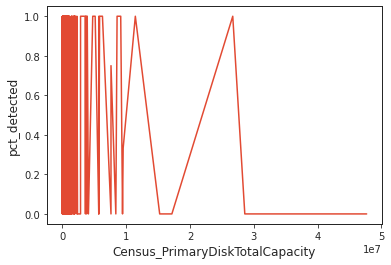

In [ ]:
sns.lineplot(data=expl, x=expl.index, y='pct_detected')

In [ ]:
# dejaremos las dos como integers y palante

In [ ]:
df['Census_PrimaryDiskTotalCapacity'] = df['Census_PrimaryDiskTotalCapacity'].astype(int)
df['Census_SystemVolumeTotalCapacity'] = df['Census_SystemVolumeTotalCapacity'].astype(int)

#### Census_InternalPrimaryDisplayResolutionHorizontal vs Census_InternalPrimaryDisplayResolutionVertical

In [ ]:
df['Census_InternalPrimaryDisplayResolutionHorizontal'].corr(df['Census_InternalPrimaryDisplayResolutionVertical'])

0.8982501582698903

In [ ]:
explore_cat_values(df, 'Census_InternalPrimaryDisplayResolutionHorizontal').sort_index()['pct_detected']

Census_InternalPrimaryDisplayResolutionHorizontal
-1.0        0.250000
 320.0      1.000000
 360.0      0.000000
 400.0      0.000000
 480.0      0.714286
              ...   
 6016.0     0.000000
 6048.0     1.000000
 7680.0     0.500000
 10320.0    0.000000
 11520.0    0.000000
Name: pct_detected, Length: 474, dtype: float64

In [ ]:
explore_cat_values(df, 'Census_InternalPrimaryDisplayResolutionVertical').sort_index()['pct_detected']

Census_InternalPrimaryDisplayResolutionVertical
-1.0       0.250000
 200.0     1.000000
 300.0     0.000000
 360.0     0.000000
 400.0     0.333333
             ...   
 3240.0    0.000000
 3270.0    0.000000
 3384.0    0.000000
 3840.0    0.111111
 4320.0    1.000000
Name: pct_detected, Length: 514, dtype: float64

In [ ]:
# al tener ya un -1 ponemos los nulos como -1 para que sea un valor extremo y así el decision tree pueda cortar si es necesario

In [ ]:
df['Census_InternalPrimaryDisplayResolutionHorizontal'].fillna(-2, inplace=True)
df['Census_InternalPrimaryDisplayResolutionVertical'].fillna(-2, inplace=True)

In [ ]:
df['Census_InternalPrimaryDisplayResolutionHorizontal'] = df['Census_InternalPrimaryDisplayResolutionHorizontal'].astype(int)
df['Census_InternalPrimaryDisplayResolutionVertical'] = df['Census_InternalPrimaryDisplayResolutionVertical'].astype(int)

In [ ]:
df['ratio_DisplayResolution'] = df['Census_InternalPrimaryDisplayResolutionHorizontal'] / df['Census_InternalPrimaryDisplayResolutionVertical']

In [ ]:
df.drop('Census_InternalPrimaryDisplayResolutionHorizontal', axis=1, inplace=True)
df.drop('Census_InternalPrimaryDisplayResolutionVertical', axis=1, inplace=True)

#### Census_OSInstallLanguageIdentifier vs Census_OSUILocaleIdentifier

In [ ]:
df['Census_OSInstallLanguageIdentifier'].corr(df['Census_OSUILocaleIdentifier'])

0.988487819819832

In [ ]:
explore_cat_values(df, 'Census_OSInstallLanguageIdentifier')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_OSInstallLanguageIdentifier                                          
36.0                                   846       520       326      0.614657
2.0                                   1096       639       457      0.583029
34.0                                   584       320       264      0.547945
10.0                                 20268     10888      9380      0.537201
17.0                                  4695      2517      2178      0.536102
37.0                                 22635     11842     10793      0.523172
35.0                                 11497      6011      5486      0.522832
31.0                                  1213       629       584      0.518549
9.0                                  58012     29788     28224      0.513480
26.0                                 18520      9470      9050      0.511339
29.0                                 27669     14142     13527      0.511114
15.0                                  2311      1170      1141      0.506274
8.0                                 178405     90135     88270      0.505227
21.0                                   413       208       205      0.503632
39.0                                 11221      5597      5624      0.498797
27.0                                  5956      2942      3014      0.493956
7.0                                  28766     14097     14669      0.490058
20.0                                  9512      4653      4859      0.489172
16.0                                   837       406       431      0.485066
18.0                                 10600      5139      5461      0.484811
1.0                                   4516      2156      2360      0.477414
6.0                                   2881      1369      1512      0.475182
24.0                                  8127      3837      4290      0.472130
25.0                                  7502      3541      3961      0.472007
14.0                                 24191     11379     12812      0.470382
13.0                                   581       269       312      0.462995
3.0                                   4067      1849      2218      0.454635
5.0                                  14085      6289      7796      0.446503
38.0                                   185        82       103      0.443243
11.0                                   197        87       110      0.441624
28.0                                   713       312       401      0.437588
30.0                                  1793       777      1016      0.433352
19.0                                  4775      2026      2749      0.424293
32.0                                   246       102       144      0.414634
4.0                                   1996       825      1171      0.413327
33.0                                  2807      1148      1659      0.408978
22.0                                   178        72       106      0.404494
23.0                                  1652       646      1006      0.391041
12.0                                  1119       412       707      0.368186

In [ ]:
# eliminamos Census_OSUILocaleIdentifier ya que tiene muchos identificadores con pocos valores y el Census_OSInstallLanguageIdentifier es más limpio aunque tenga nulos

In [ ]:
df.drop('Census_OSUILocaleIdentifier', axis=1, inplace=True)

In [ ]:
df['Census_OSInstallLanguageIdentifier'].fillna('ZZZ', inplace=True)

In [ ]:
# como todas categorías ya son >100 registros, haremos OHE directamente

In [ ]:
df['Census_OSInstallLanguageIdentifier'].fillna('ZZZ', inplace=True)

### Identifiers

In [ ]:
# al ser identificadores los acabaremos pasando todos a OHE y tratando ahora como categóricas
# Hace falta revisar nulos y si aplicar set others

#### DefaultBrowsersIdentifier

In [ ]:
# plot_cat_values_sort(df, 'DefaultBrowsersIdentifier', 'pct_detected')

In [ ]:
explore_cat_values(df, 'DefaultBrowsersIdentifier')

n_rows  1-HasDet  0-HasDet  pct_detected
DefaultBrowsersIdentifier                                          
1733.0                          1         1         0           1.0
1817.0                          1         1         0           1.0
1515.0                          1         1         0           1.0
1539.0                          1         1         0           1.0
1563.0                          2         2         0           1.0
...                           ...       ...       ...           ...
243.0                           2         0         2           0.0
2563.0                          1         0         1           0.0
1966.0                          1         0         1           0.0
1949.0                          1         0         1           0.0
820.0                           1         0         1           0.0

[554 rows x 4 columns]

In [ ]:
#poner los nulos en valores extremos, podría ser un -1 o un zzz ya

In [ ]:
df['DefaultBrowsersIdentifier'].fillna('-1', inplace=True)

In [ ]:
df['DefaultBrowsersIdentifier'] = df['DefaultBrowsersIdentifier'].astype(int)

In [ ]:
df['DefaultBrowsersIdentifier'].value_counts()

-1       475938
 239       2589
 3195      2423
 1632      1601
 3176      1313
          ...  
 649          1
 1929         1
 906          1
 1418         1
 1024         1
Name: DefaultBrowsersIdentifier, Length: 555, dtype: int64

In [ ]:
# haremos el setothers por arriba y abajo para coger los browsers más variables en cuanto al target

In [ ]:
df['DefaultBrowsersIdentifier'] = setOthersHeadTail(df, 'DefaultBrowsersIdentifier', 100, 20)

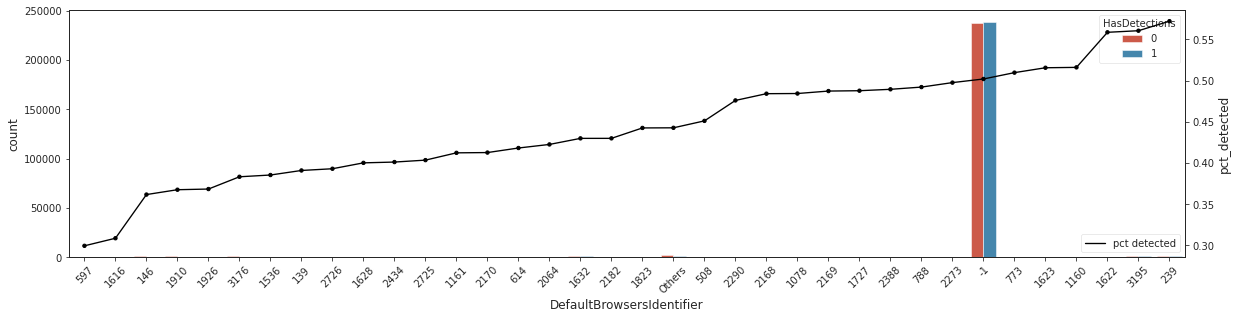

In [ ]:
plot_cat_values_sort(df, 'DefaultBrowsersIdentifier', 'pct_detected')

In [ ]:
# Haremos un OHE

#### AVProductStatesIdentifier

In [ ]:
explore_cat_values(df, 'AVProductStatesIdentifier').sort_values(by='n_rows')

n_rows  1-HasDet  0-HasDet  pct_detected
AVProductStatesIdentifier                                          
3.0                             1         1         0      1.000000
57546.0                         1         0         1      0.000000
57594.0                         1         0         1      0.000000
57804.0                         1         0         1      0.000000
57642.0                         1         0         1      0.000000
...                           ...       ...       ...           ...
46413.0                      6343      3109      3234      0.490147
62773.0                     14931      5672      9259      0.379881
47238.0                     18436      8525      9911      0.462411
7945.0                      26642      9356     17286      0.351175
53447.0                    326462    181517    144945      0.556013

[5516 rows x 4 columns]

In [ ]:
# hay más de 5k registros. Así que inputaremos nulos, haremos el setOthers y OHE


In [ ]:
def clean_identifier(df, column, value_to_fillna, final_type, min_rows, top_n):
  df[column].fillna(value_to_fillna, inplace=True)
  df[column] = df[column].astype(final_type)
  df[column] = setOthersHeadTail(df, column, min_rows, top_n)
  return plot_cat_values_sort(df, column, 'pct_detected')

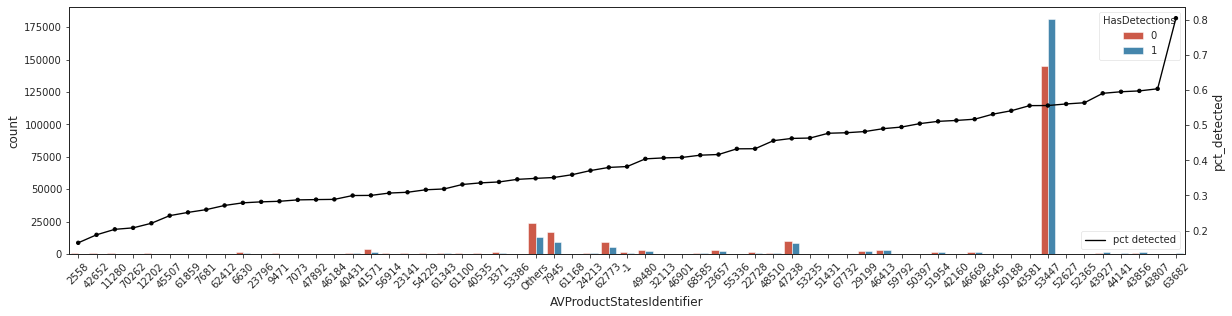

In [ ]:
clean_identifier(df, 'AVProductStatesIdentifier', -1, int, 300, 30)

#### CountryIdentifier

In [ ]:
explore_cat_values(df, 'CountryIdentifier')

n_rows  1-HasDet  0-HasDet  pct_detected
CountryIdentifier                                          
105                    32        22        10      0.687500
139                   325       214       111      0.658462
197                    52        34        18      0.653846
104                  1584       999       585      0.630682
131                   987       621       366      0.629179
...                   ...       ...       ...           ...
92                     90        24        66      0.266667
213                    73        19        54      0.260274
114                    23         5        18      0.217391
98                     75        16        59      0.213333
74                     44         9        35      0.204545

[222 rows x 4 columns]

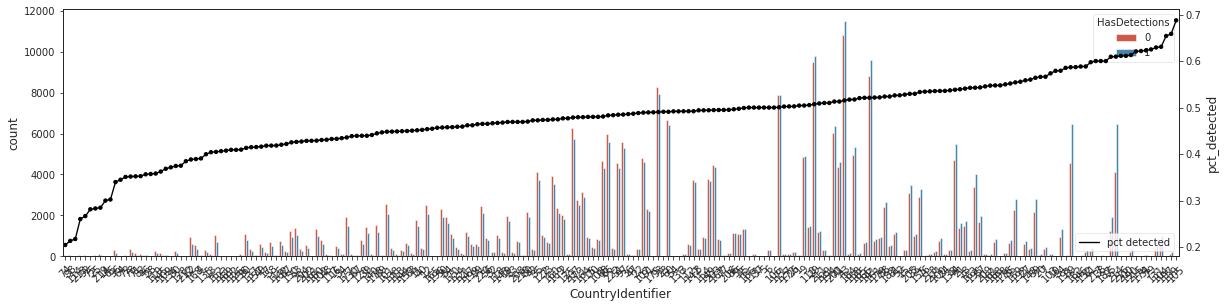

In [ ]:
plot_cat_values_sort(df, 'CountryIdentifier', 'pct_detected')

In [ ]:
# vemos que la mayoría de clases con un gran nombre de registros están cerca del 50% así que volveremos a aplicar el setothers por arriba y abajo

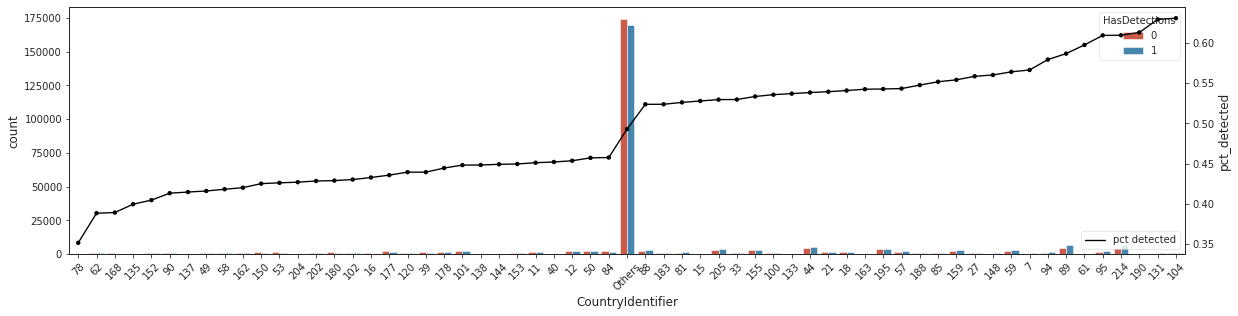

In [ ]:
clean_identifier(df, 'CountryIdentifier', -1, int, 500, 30)

#### CityIdentifier

In [ ]:
explore_cat_values(df, 'CityIdentifier').sort_values('n_rows')

n_rows  1-HasDet  0-HasDet  pct_detected
CityIdentifier                                          
7.0                  1         1         0      1.000000
114699.0             1         0         1      0.000000
115045.0             1         0         1      0.000000
14306.0              1         0         1      0.000000
115079.0             1         0         1      0.000000
...                ...       ...       ...           ...
61668.0           3724      2288      1436      0.614393
10222.0           4011      2114      1897      0.527051
82373.0           4649      2444      2205      0.525704
16668.0           4747      2490      2257      0.524542
130775.0          5271      2633      2638      0.499526

[37157 rows x 4 columns]

In [ ]:
# muchísimos valores

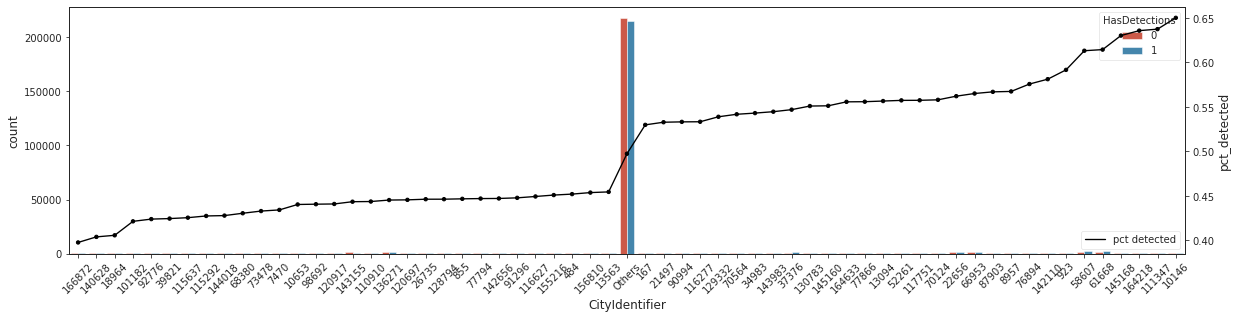

In [ ]:
clean_identifier(df,'CityIdentifier', -1, int, 500, 30)

#### OrganizationIdentifier

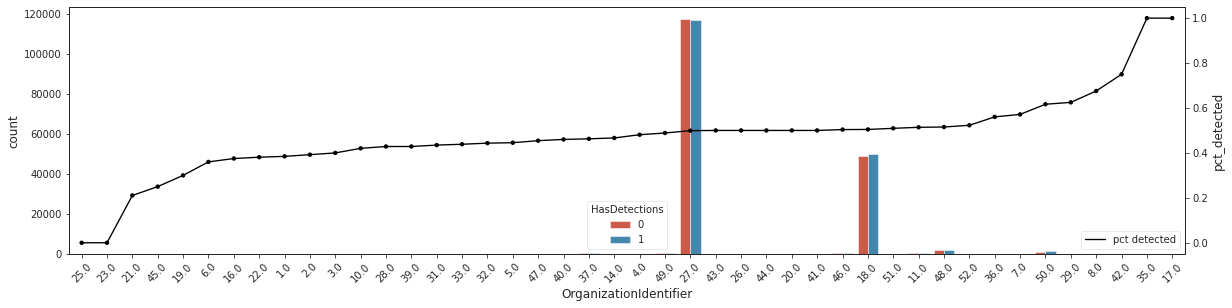

In [ ]:
plot_cat_values_sort(df, 'OrganizationIdentifier', 'pct_detected')

In [ ]:
explore_cat_values(df, 'OrganizationIdentifier')

n_rows  1-HasDet  0-HasDet  pct_detected
OrganizationIdentifier                                          
17.0                         1         1         0      1.000000
35.0                         2         2         0      1.000000
42.0                         8         6         2      0.750000
8.0                         37        25        12      0.675676
29.0                         8         5         3      0.625000
50.0                      2538      1565       973      0.616627
7.0                          7         4         3      0.571429
36.0                       207       116        91      0.560386
52.0                       174        91        83      0.522989
48.0                      3658      1885      1773      0.515309
11.0                      1037       533       504      0.513983
51.0                        53        27        26      0.509434
18.0                     98842     49863     48979      0.504472
46.0                       641       323       318      0.503900
41.0                         2         1         1      0.500000
43.0                         4         2         2      0.500000
26.0                         6         3         3      0.500000
20.0                        38        19        19      0.500000
44.0                         6         3         3      0.500000
27.0                    234884    117224    117660      0.499072
49.0                       747       365       382      0.488621
4.0                         79        38        41      0.481013
14.0                       255       119       136      0.466667
37.0                      1048       485       563      0.462786
40.0                       100        46        54      0.460000
47.0                        22        10        12      0.454545
5.0                        110        49        61      0.445455
32.0                       230       102       128      0.443478
33.0                       171        75        96      0.438596
31.0                        23        10        13      0.434783
28.0                        98        42        56      0.428571
39.0                        21         9        12      0.428571
10.0                        69        29        40      0.420290
3.0                         20         8        12      0.400000
2.0                        153        60        93      0.392157
1.0                         39        15        24      0.384615
22.0                        21         8        13      0.380952
16.0                        16         6        10      0.375000
6.0                         25         9        16      0.360000
19.0                        10         3         7      0.300000
45.0                         4         1         3      0.250000
21.0                        19         4        15      0.210526
25.0                         1         0         1      0.000000
23.0                         2         0         2      0.000000

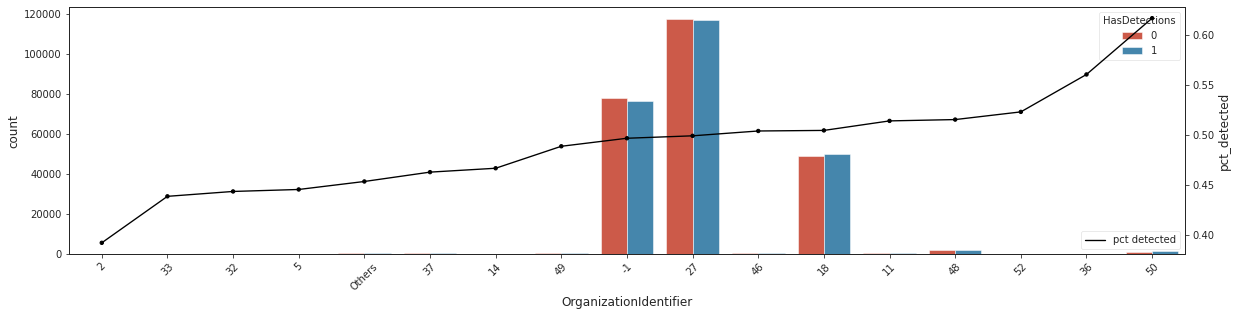

In [ ]:
clean_identifier(df, 'OrganizationIdentifier', -1, int, 100, 20)

In [ ]:
explore_cat_values(df, 'OrganizationIdentifier')

n_rows  1-HasDet  0-HasDet  pct_detected
OrganizationIdentifier                                          
50                        2538      1565       973      0.616627
36                         207       116        91      0.560386
52                         174        91        83      0.522989
48                        3658      1885      1773      0.515309
11                        1037       533       504      0.513983
18                       98842     49863     48979      0.504472
46                         641       323       318      0.503900
27                      234884    117224    117660      0.499072
-1                      154563     76762     77801      0.496639
49                         747       365       382      0.488621
14                         255       119       136      0.466667
37                        1048       485       563      0.462786
Others                     741       336       405      0.453441
5                          110        49        61      0.445455
32                         230       102       128      0.443478
33                         171        75        96      0.438596
2                          153        60        93      0.392157

#### GeoNameIdentifier

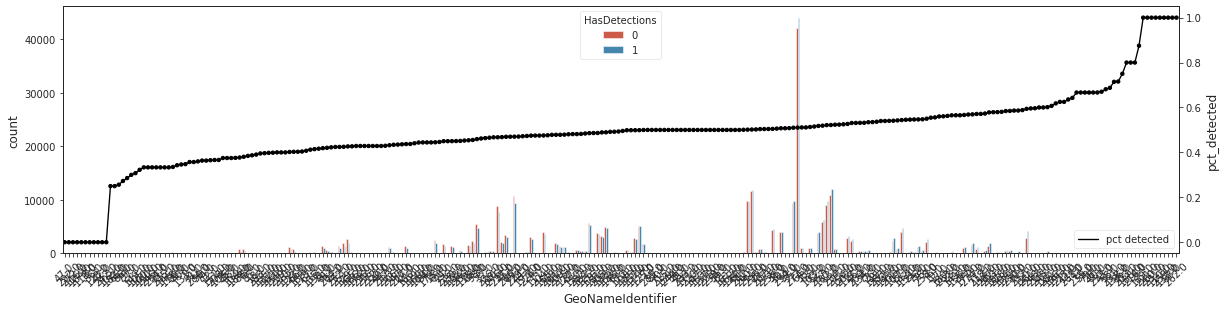

In [ ]:
plot_cat_values_sort(df, 'GeoNameIdentifier', 'pct_detected')

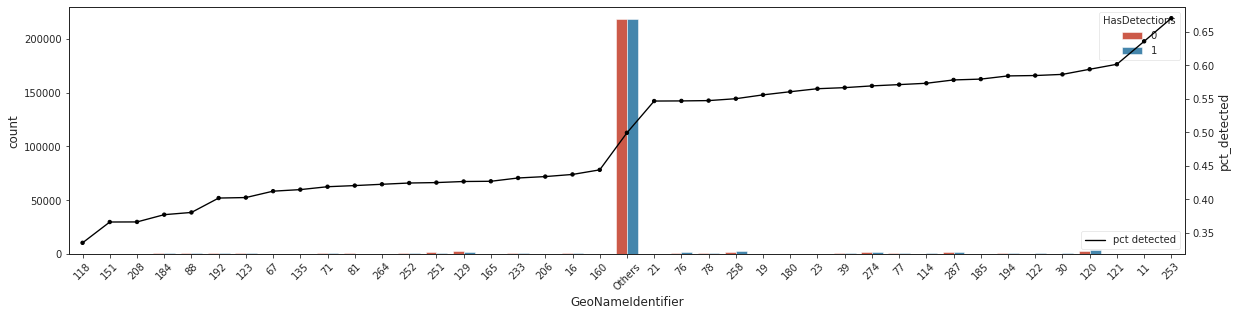

In [ ]:
clean_identifier(df, 'GeoNameIdentifier', -1, int, 200, 20)

#### LocaleEnglishNameIdentifier

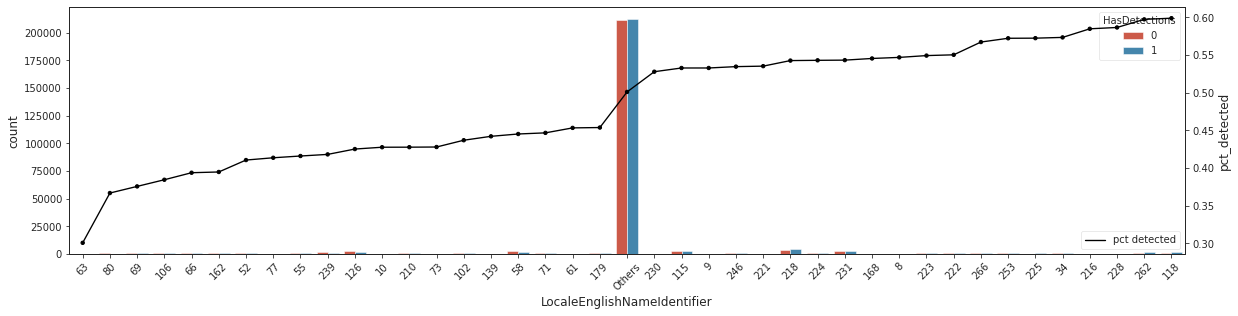

In [ ]:
clean_identifier(df, 'LocaleEnglishNameIdentifier', -1, int, 300, 20)

#### IeVerIdentifier

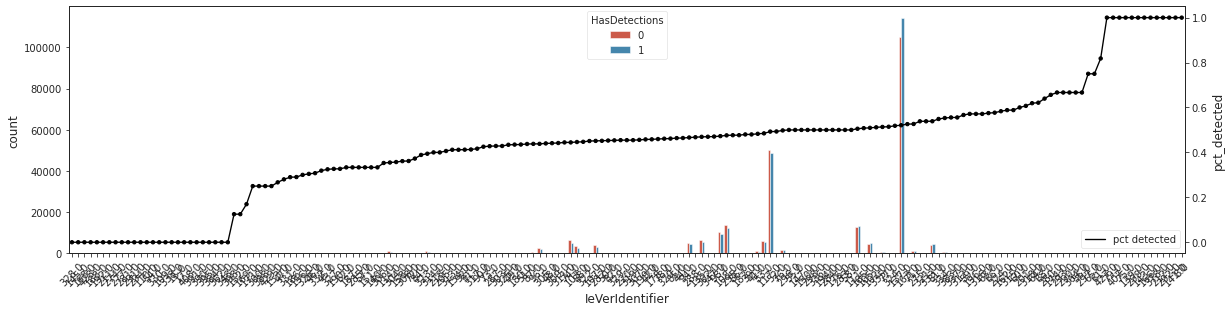

In [ ]:
plot_cat_values_sort(df,'IeVerIdentifier', 'pct_detected')

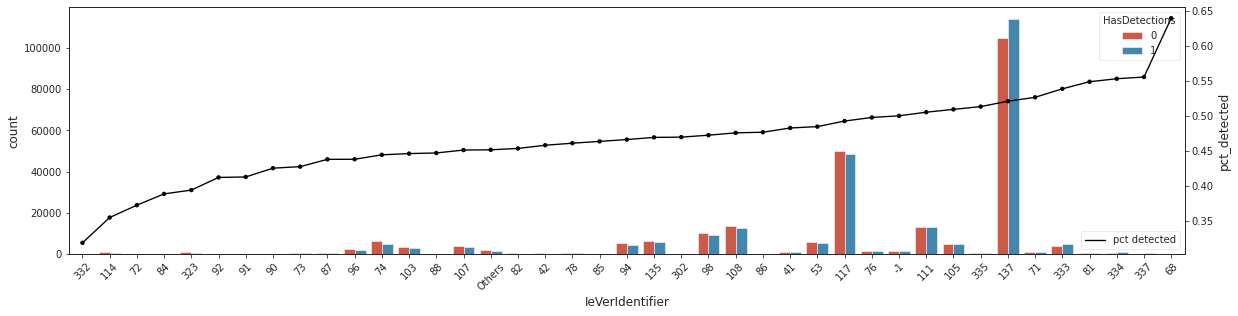

In [ ]:
clean_identifier(df, 'IeVerIdentifier', -1, int, 200, 20)

#### Census_OEMNameIdentifier

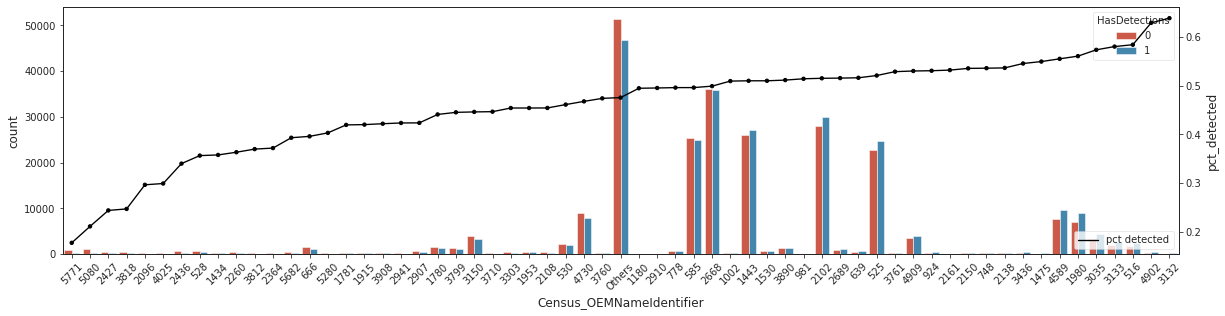

In [ ]:
clean_identifier(df, 'Census_OEMNameIdentifier', -1, int, 200, 30)

#### Census_OEMModelIdentifier

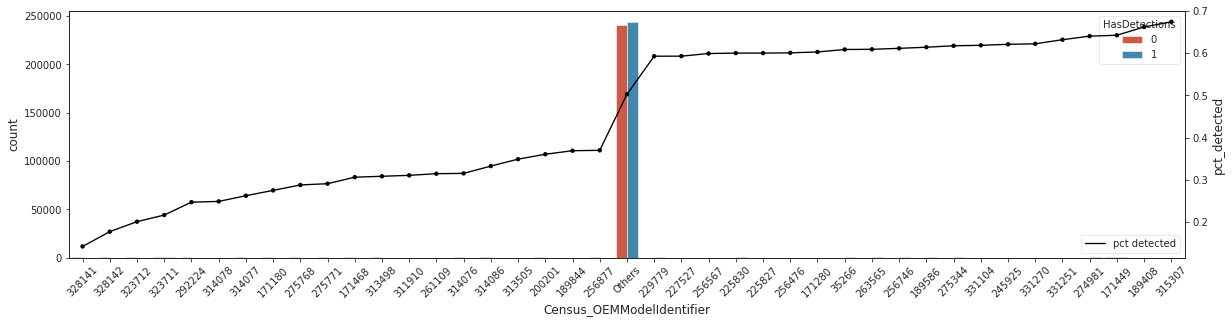

In [ ]:
clean_identifier(df, 'Census_OEMModelIdentifier', -1, int, 200, 20)

#### Census_FirmwareManufacturerIdentifier

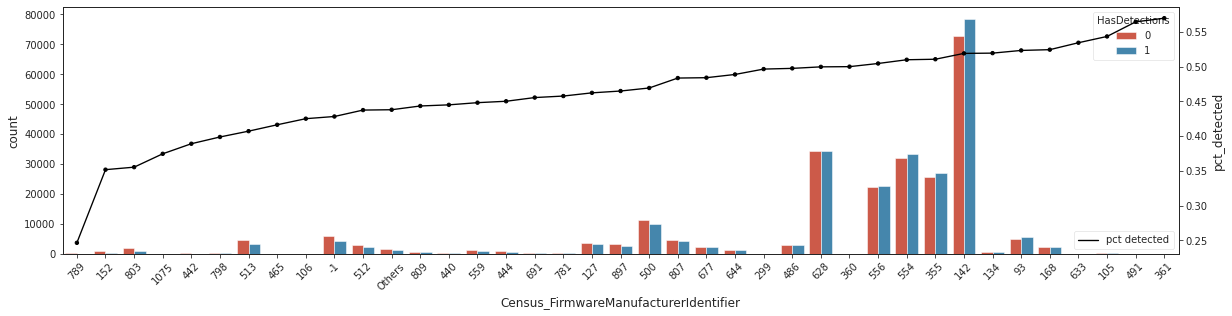

In [ ]:
clean_identifier(df, 'Census_FirmwareManufacturerIdentifier', -1, int, 200, 20)

#### Census_FirmwareVersionIdentifier

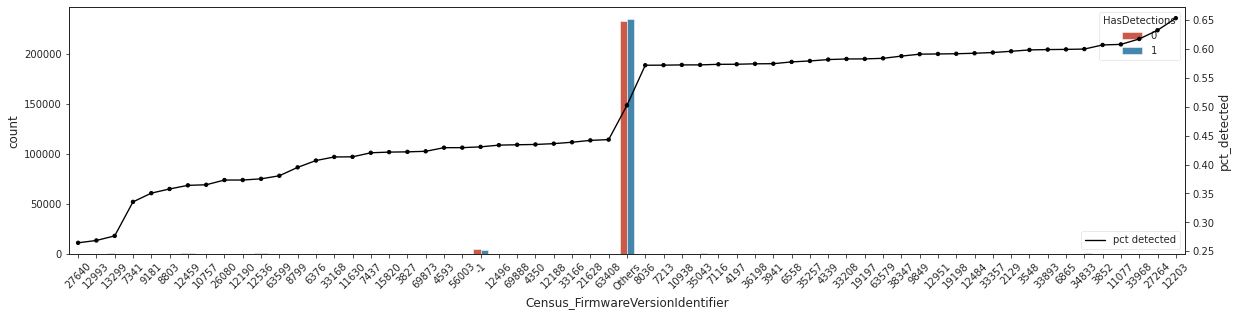

In [ ]:
clean_identifier(df, 'Census_FirmwareVersionIdentifier', -1, int, 200, 30)

#### Wdft_RegionIdentifier

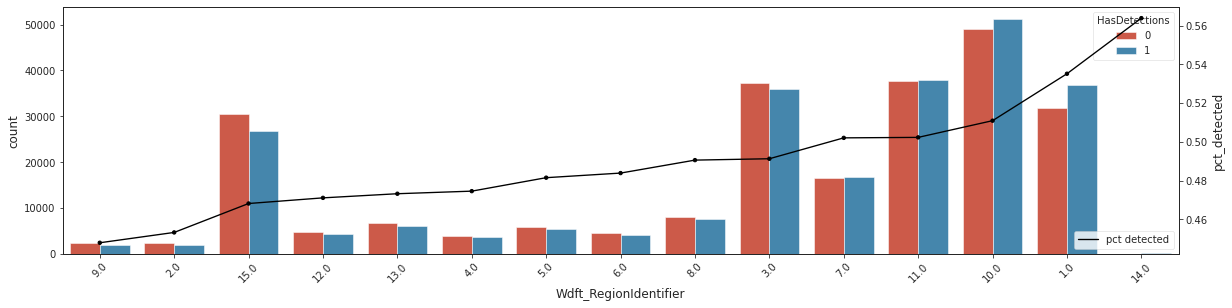

In [ ]:
plot_cat_values_sort(df, 'Wdft_RegionIdentifier', 'pct_detected')

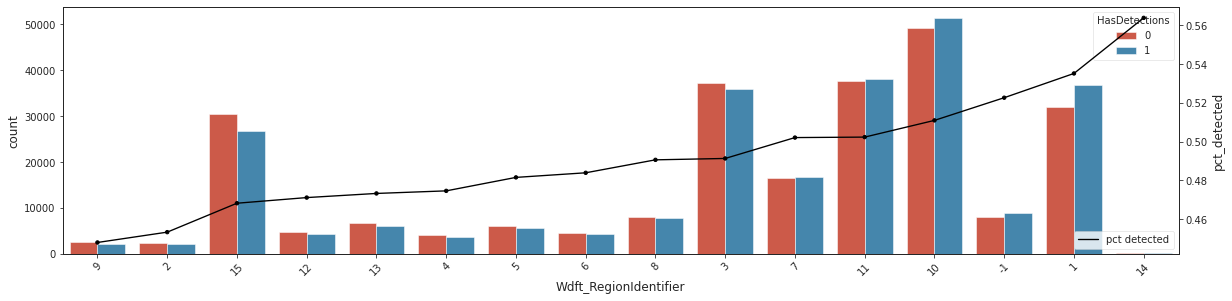

In [ ]:
df['Wdft_RegionIdentifier'].fillna(-1, inplace=True)
df['Wdft_RegionIdentifier'] = df['Wdft_RegionIdentifier'].astype(int)
plot_cat_values_sort(df, 'Wdft_RegionIdentifier', 'pct_detected')

In [ ]:
df['Wdft_RegionIdentifier'].value_counts(dropna=False)

 10    100391
 11     75612
 3      73069
 1      68692
 15     57346
 7      33362
-1      16950
 8      15761
 13     12681
 5      11466
 12      9115
 6       8750
 4       7586
 9       4521
 2       4470
 14       227
Name: Wdft_RegionIdentifier, dtype: int64

In [ ]:
df['Wdft_RegionIdentifier'] = df['Wdft_RegionIdentifier'].astype(object)


### Otros

#### RtpStateBitfield

In [ ]:
explore_cat_values(df, 'RtpStateBitfield')
# sabemos que hay nulos pero no se muestra, pivot table no tiene la opción de dropna, hay un issue abierto en github

n_rows  1-HasDet  0-HasDet  pct_detected
RtpStateBitfield                                          
35.0                   1         1         0      1.000000
8.0                 1277       978       299      0.765857
7.0               484840    243855    240985      0.502960
0.0                10610      4043      6567      0.381056
1.0                  105        34        71      0.323810
3.0                  176        49       127      0.278409
5.0                 1158       175       983      0.151123

In [ ]:
df['RtpStateBitfield'] = df['RtpStateBitfield'].fillna('-1')
#les cambio el valor para poder aplicar la función de explore y ver las métricas

In [ ]:
df['RtpStateBitfield'] = df['RtpStateBitfield'].astype(int)

In [ ]:
explore_cat_values(df, 'RtpStateBitfield').sort_index()

n_rows  1-HasDet  0-HasDet  pct_detected
RtpStateBitfield                                          
-1                  1832       818      1014      0.446507
 0                 10610      4043      6567      0.381056
 1                   105        34        71      0.323810
 3                   176        49       127      0.278409
 5                  1158       175       983      0.151123
 7                484840    243855    240985      0.502960
 8                  1277       978       299      0.765857
 35                    1         1         0      1.000000

In [ ]:
# las pasaremos a integer ya que son incrementales, tienen un orden
# pasaremos los nulos a -1 para que sean un valor extremo
# pasaremos el valor de 35 a la categoría más próxima que es el 8, y por relación con el target encaja

In [ ]:
# vemos que a partir de 7 bitfields el % aumenta con creces.
# tiene una forma de parábola, con el mínimo en la clase 5 con un 15%.

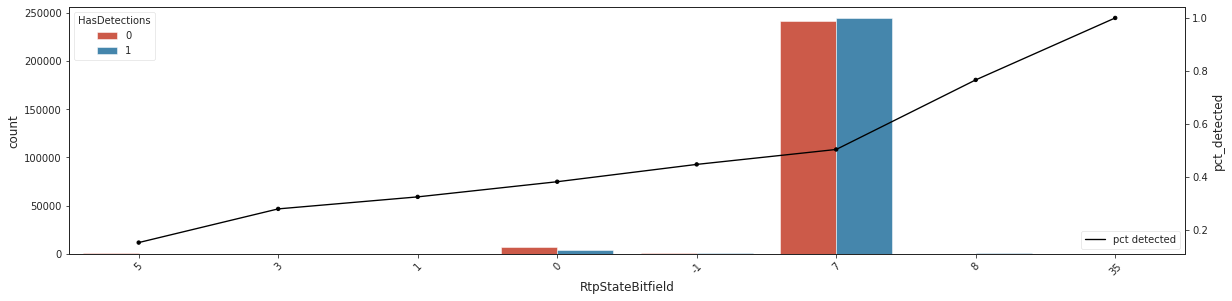

In [ ]:
plot_cat_values_sort(df, 'RtpStateBitfield', 'pct_detected')

#### AVProductsInstalled

In [ ]:
explore_cat_values(df, 'AVProductsInstalled')

n_rows  1-HasDet  0-HasDet  pct_detected
AVProductsInstalled                                          
1.0                  348045    190800    157245      0.548205
2.0                  137856     54902     82954      0.398256
3.0                   11617      3378      8239      0.290781
4.0                     514       128       386      0.249027
5.0                      29         4        25      0.137931

In [ ]:
df['AVProductsInstalled'].fillna(-1, inplace=True)

In [ ]:
df['AVProductsInstalled'] = df['AVProductsInstalled'].astype(int)

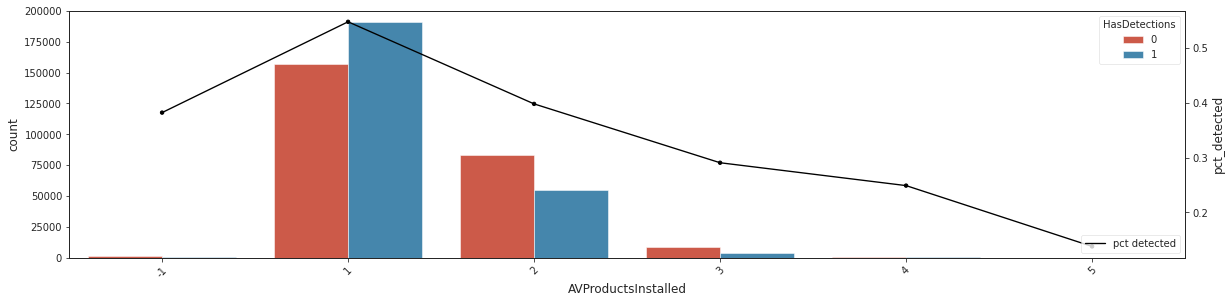

In [ ]:
plot_cat_values_sort(df, 'AVProductsInstalled', 'AVProductsInstalled')

In [ ]:
#vemos que también hay relación, por tanto la dejamos así


#### AVProductsEnabled

In [ ]:
explore_cat_values(df, 'AVProductsEnabled')

n_rows  1-HasDet  0-HasDet  pct_detected
AVProductsEnabled                                          
1.0                485178    244821    240357      0.504600
0.0                  1467       544       923      0.370825
3.0                   316       111       205      0.351266
2.0                 11074      3732      7342      0.337006
4.0                    26         4        22      0.153846

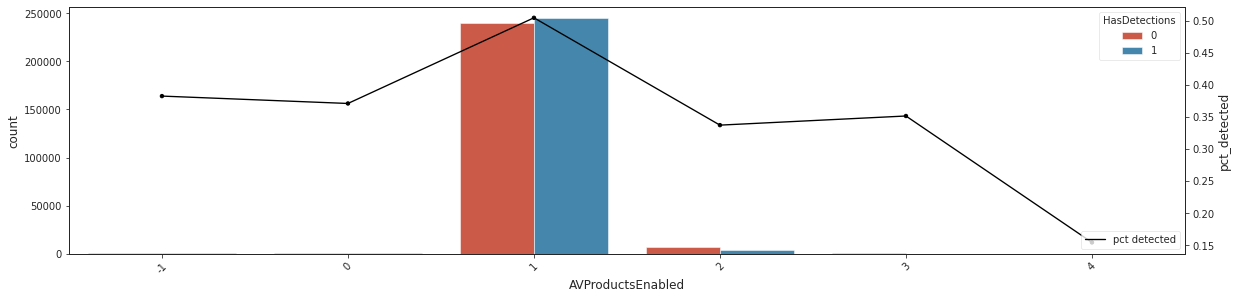

In [ ]:
df['AVProductsEnabled'].fillna(-1, inplace=True)
df['AVProductsEnabled'] = df['AVProductsEnabled'].astype(int)
plot_cat_values_sort(df, 'AVProductsEnabled', 'AVProductsEnabled')

#### OsSuite

In [ ]:
explore_cat_values(df, 'OsSuite')

n_rows  1-HasDet  0-HasDet  pct_detected
OsSuite                                          
18            1         1         0      1.000000
16           53        33        20      0.622642
256      187950     96463     91487      0.513238
274           2         1         1      0.500000
768      311226    153185    158041      0.492199
784          10         4         6      0.400000
305          33        13        20      0.393939
272         677       238       439      0.351551
400          47        15        32      0.319149

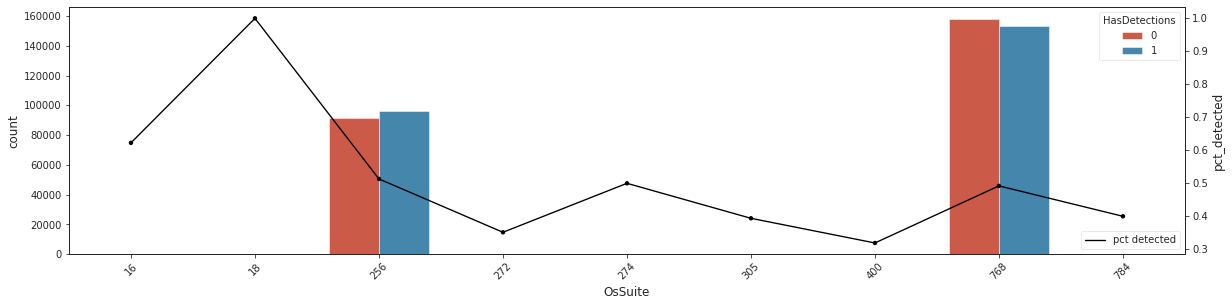

In [ ]:
df['OsSuite'].fillna(-1, inplace=True)
df['OsSuite'] = df['OsSuite'].astype(int)
plot_cat_values_sort(df, 'OsSuite', 'OsSuite')

#### UacLuaenable

In [ ]:
explore_cat_values(df, 'UacLuaenable')

n_rows  1-HasDet  0-HasDet  pct_detected
UacLuaenable                                          
2.0                1         1         0      1.000000
6357062.0          1         1         0      1.000000
48.0              13        10         3      0.769231
1.0           496275    248115    248160      0.499955
0.0             3086      1496      1590      0.484770

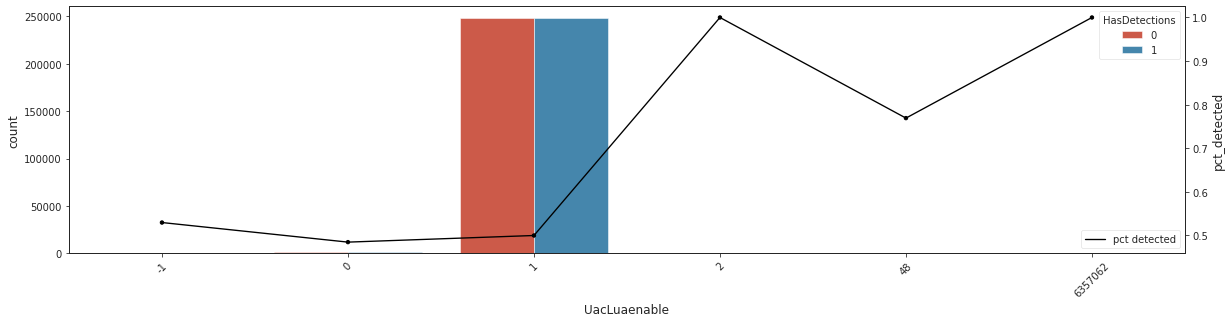

In [ ]:
df['UacLuaenable'].fillna(-1, inplace=True)
df['UacLuaenable'] = df['UacLuaenable'].astype(int)
plot_cat_values_sort(df, 'UacLuaenable', 'UacLuaenable')

#### Census_ProcessorCoreCount

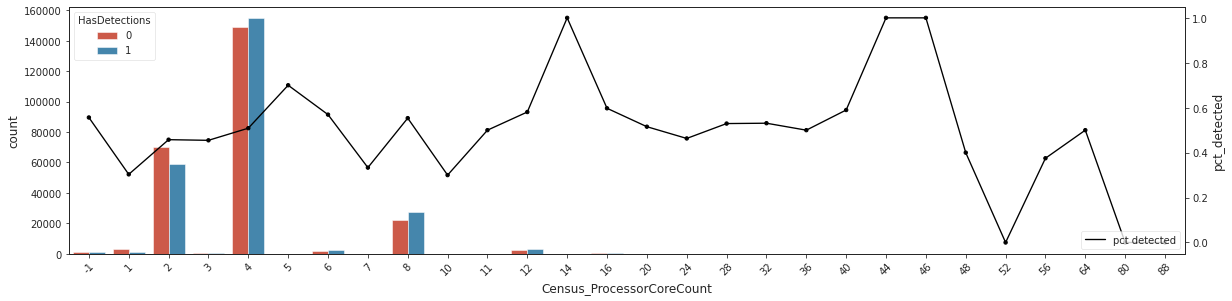

In [ ]:
df['Census_ProcessorCoreCount'].fillna(-1, inplace=True)
df['Census_ProcessorCoreCount'] = df['Census_ProcessorCoreCount'].astype(int)
plot_cat_values_sort(df, 'Census_ProcessorCoreCount', 'Census_ProcessorCoreCount')

#### Census_TotalPhysicalRAM

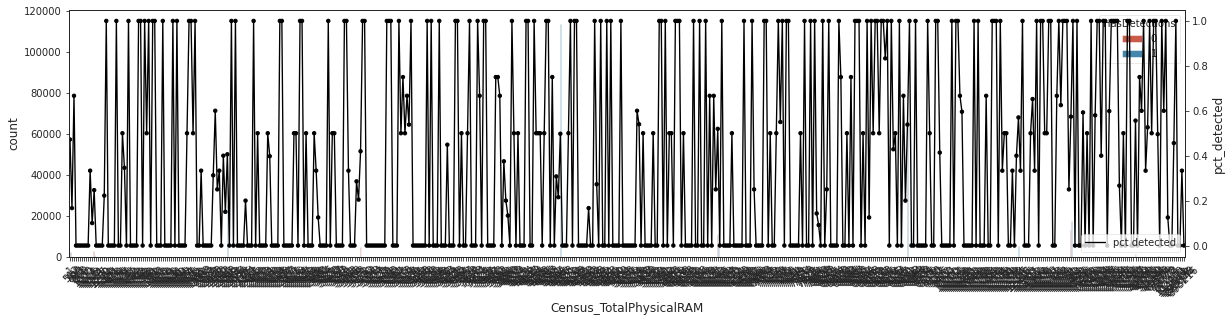

In [ ]:
df['Census_TotalPhysicalRAM'].fillna(-1, inplace=True)
df['Census_TotalPhysicalRAM'] = df['Census_TotalPhysicalRAM'].astype(int)
plot_cat_values_sort(df, 'Census_TotalPhysicalRAM', 'Census_TotalPhysicalRAM')

In [ ]:
explore_cat_values(df, 'Census_TotalPhysicalRAM').sort_values('n_rows')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_TotalPhysicalRAM                                          
11038                         1         1         0      1.000000
2524                          1         0         1      0.000000
2551                          1         0         1      0.000000
2569                          1         0         1      0.000000
2619                          1         0         1      0.000000
...                         ...       ...       ...           ...
6144                      22349     11612     10737      0.519576
16384                     30179     17319     12860      0.573876
2048                      61694     25059     36635      0.406182
8192                     123174     66325     56849      0.538466
4096                     228677    113824    114853      0.497750

[553 rows x 4 columns]

In [ ]:
df = encode_group_ordered(df, 'Census_TotalPhysicalRAM', 200)

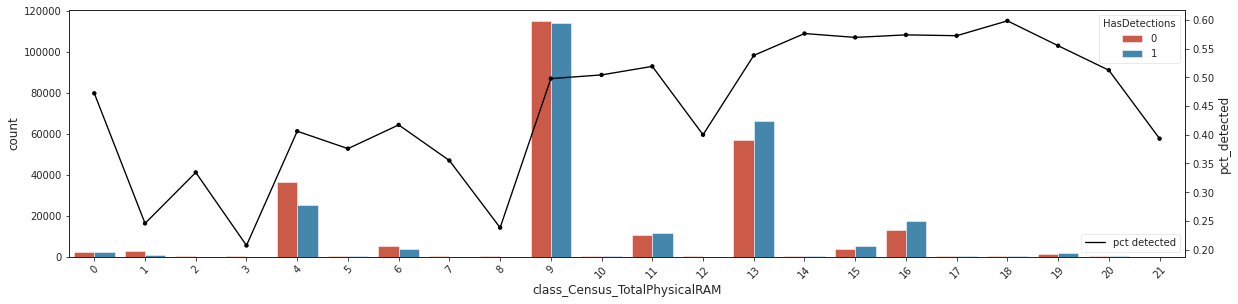

In [ ]:
plot_cat_values_sort(df, 'class_Census_TotalPhysicalRAM', 'class_Census_TotalPhysicalRAM')

#### Census_InternalPrimaryDiagonalDisplaySizeInInches

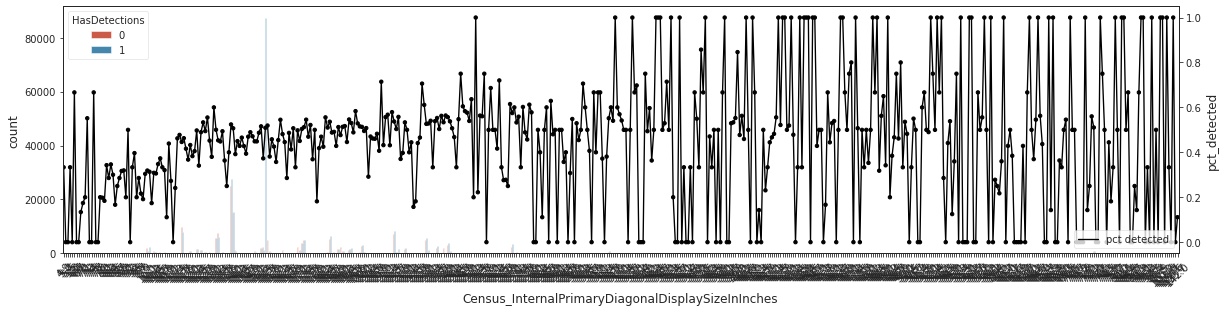

In [ ]:
plot_cat_values_sort(df, 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDiagonalDisplaySizeInInches')

In [ ]:
df['Census_InternalPrimaryDiagonalDisplaySizeInInches'].isnull().sum()

2654

In [ ]:
df['Census_InternalPrimaryDiagonalDisplaySizeInInches'].fillna(-1, inplace=True)

In [ ]:
df = encode_group_ordered(df, 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 200)

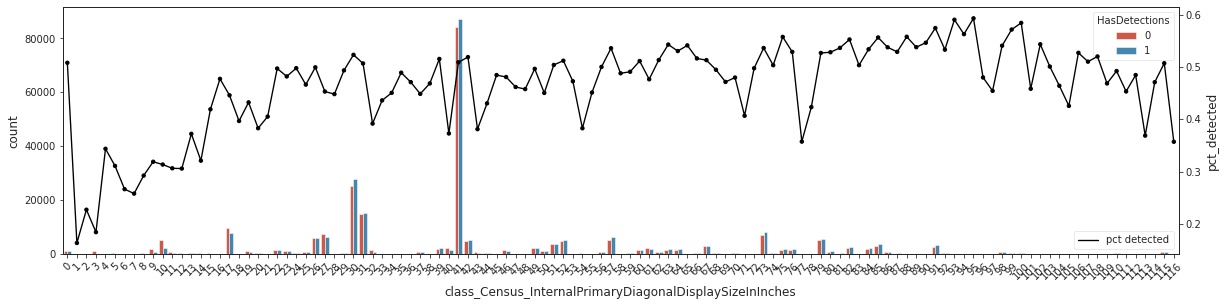

In [ ]:
plot_cat_values_sort(df, 'class_Census_InternalPrimaryDiagonalDisplaySizeInInches', 'class_Census_InternalPrimaryDiagonalDisplaySizeInInches')

In [ ]:
df['class_Census_InternalPrimaryDiagonalDisplaySizeInInches'].isnull().sum()

0

#### Census_InternalBatteryNumberOfCharges

In [ ]:
explore_cat_values(df, 'Census_InternalBatteryNumberOfCharges').sort_index()

n_rows  1-HasDet  0-HasDet  pct_detected
Census_InternalBatteryNumberOfCharges                                          
0.000000e+00                           283189    140772    142417      0.497096
1.000000e+00                             2955      1235      1720      0.417936
2.000000e+00                             1503       628       875      0.417831
3.000000e+00                             1212       510       702      0.420792
4.000000e+00                             1020       411       609      0.402941
...                                       ...       ...       ...           ...
6.549700e+04                                1         1         0      1.000000
6.550400e+04                                1         1         0      1.000000
6.553500e+04                                6         4         2      0.666667
4.294967e+09                              660       329       331      0.498485
4.294967e+09                           126435     65208     61227      0.515743

[5248 rows x 4 columns]

In [ ]:
df['Census_InternalBatteryNumberOfCharges'].fillna(-1, inplace=True)

In [ ]:
df['Census_InternalBatteryNumberOfCharges'] = df['Census_InternalBatteryNumberOfCharges'].astype(int)

In [ ]:
explore_cat_values(df, 'Census_InternalBatteryNumberOfCharges').sort_index()

n_rows  1-HasDet  0-HasDet  pct_detected
Census_InternalBatteryNumberOfCharges                                          
-1                                      15038      8012      7026      0.532784
 0                                     283189    140772    142417      0.497096
 1                                       2955      1235      1720      0.417936
 2                                       1503       628       875      0.417831
 3                                       1212       510       702      0.420792
...                                       ...       ...       ...           ...
 65497                                      1         1         0      1.000000
 65504                                      1         1         0      1.000000
 65535                                      6         4         2      0.666667
 4294967294                               660       329       331      0.498485
 4294967295                            126435     65208     61227      0.515743

[5249 rows x 4 columns]

In [ ]:
# se queda como está

#### Census_OSBuildRevision

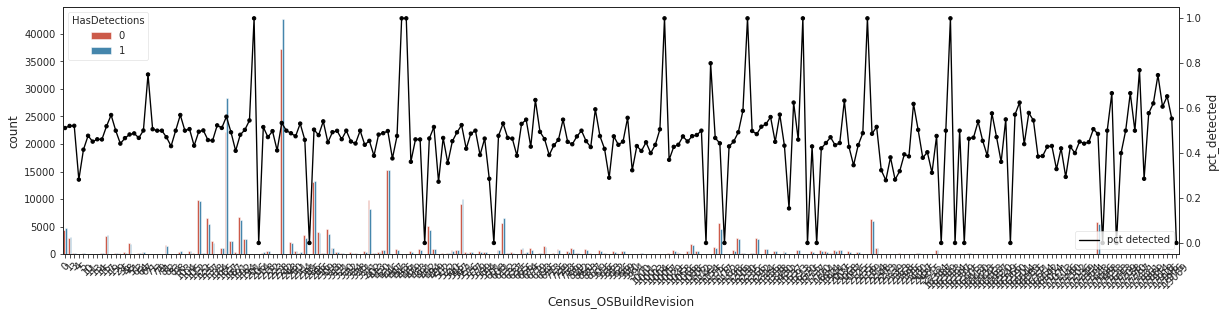

In [ ]:
plot_cat_values_sort(df, 'Census_OSBuildRevision', 'Census_OSBuildRevision')

In [ ]:
explore_cat_values(df, 'Census_OSBuildRevision')

n_rows  1-HasDet  0-HasDet  pct_detected
Census_OSBuildRevision                                          
1005                         1         1         0           1.0
456                          1         1         0           1.0
448                          1         1         0           1.0
1230                         1         1         0           1.0
1613                         2         2         0           1.0
...                        ...       ...       ...           ...
1177                         1         0         1           0.0
16399                        1         0         1           0.0
16394                        3         0         3           0.0
16387                        2         0         2           0.0
19069                        1         0         1           0.0

[242 rows x 4 columns]

In [ ]:
# se queda como está

#DATA PREPARATION

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499999 entries, f1cd864e97bae82bdf96523e1a539121 to 7cc4722dc4f4ac0af774736aa7a6e519
Data columns (total 65 columns):
 #   Column                                                   Non-Null Count   Dtype   
---  ------                                                   --------------   -----   
 0   ProductName                                              499999 non-null  int64   
 1   RtpStateBitfield                                         499999 non-null  int64   
 2   IsSxsPassiveMode                                         499999 non-null  int64   
 3   DefaultBrowsersIdentifier                                499999 non-null  category
 4   AVProductStatesIdentifier                                499999 non-null  category
 5   AVProductsInstalled                                      499999 non-null  int64   
 6   AVProductsEnabled                                        499999 non-null  int64   
 7   CountryIdentifier                       

In [ ]:
# no quedan nulos por imputar

## Limpieza atributos

1. Ajuste de tipos
2. Imputación de valores nulos (cero, media, moda, valor fijo, etc.) o eliminación de registros que los contengan
3. Corrección de valores atípicos o eliminación de registros que los contengan
4. Eliminación de atributos de baja varianza o con elevada correlación con otros

In [ ]:
# todo esto se ha realizado en los puntos anteriores del notebook

## Transformación atributos

* Var. categóricas: OHE, label encoding, agrupación..
* Var. num: escalado (minmax, estand), categorizaión
* Var. fecha: conversión, agregación, diferencias
* var textuales:  numerización, extraer patrones, palabras clave

In [ ]:
df.select_dtypes(include = ['object', 'category']).describe().T

count unique           top    freq
DefaultBrowsersIdentifier              499999     36            -1  475938
AVProductStatesIdentifier              499999     61         53447  326462
CountryIdentifier                      499999     61        Others  343854
CityIdentifier                         499999     61        Others  432631
OrganizationIdentifier                 499999     17            27  234884
GeoNameIdentifier                      499999     41        Others  436886
LocaleEnglishNameIdentifier            499999     41        Others  424305
Processor                              499999      2           x64  454436
SkuEdition                             499999      8          Home  308567
IeVerIdentifier                        499999     41           137  219141
SmartScreen                            499999      7  RequireAdmin  241594
Census_MDC2FormFactor                  499999     10      Notebook  320948
Census_OEMNameIdentifier               499999     61        Others   98172
Census_OEMModelIdentifier              499999     41        Others  484646
Census_PrimaryDiskTypeName             499999      3           HDD  325429
Census_ChassisTypeName                 499999     11        Others  364093
Census_PowerPlatformRoleName           499999      8        Mobile  346378
Census_InternalBatteryType             499999     13         dummy  355603
Census_OSEdition                       499999     14          Core  194469
Census_OSSkuName                       499999     13          CORE  194464
Census_OSInstallTypeName               499999      9    UUPUpgrade  146780
Census_OSInstallLanguageIdentifier     499999     40             8  178405
Census_OSWUAutoUpdateOptionsName       499999      6      FullAuto  222481
Census_GenuineStateName                499999      4    IS_GENUINE  441401
Census_ActivationChannel               499999      6        Retail  264932
Census_FlightRing                      499999      7        Retail  468298
Census_FirmwareManufacturerIdentifier  499999     39           142  151373
Census_FirmwareVersionIdentifier       499999     61        Others  467440
Wdft_RegionIdentifier                  499999     16            10  100391

In [ ]:
list_OHE = df.describe(include = ['object', 'category']).columns
list_OHE

Index(['DefaultBrowsersIdentifier', 'AVProductStatesIdentifier',
       'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier',
       'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Processor',
       'SkuEdition', 'IeVerIdentifier', 'SmartScreen', 'Census_MDC2FormFactor',
       'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier',
       'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName',
       'Census_PowerPlatformRoleName', 'Census_InternalBatteryType',
       'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName',
       'Census_OSInstallLanguageIdentifier',
       'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName',
       'Census_ActivationChannel', 'Census_FlightRing',
       'Census_FirmwareManufacturerIdentifier',
       'Census_FirmwareVersionIdentifier', 'Wdft_RegionIdentifier'],
      dtype='object')

### OHE

In [ ]:
# creamos función para hacer el OneHotEncoding a todos los atributos detectados anteriormente

In [ ]:
def OHE(dataframe, column_name):
  dummy_df = pd.get_dummies(dataframe[column_name], prefix = column_name)
  dataframe = pd.concat([dataframe, dummy_df], axis=1)
  return dataframe.drop(column_name, axis=1)

In [ ]:
for column in list_OHE:
  df= OHE(df, column)

In [ ]:
df

ProductName  ...  Wdft_RegionIdentifier_15
MachineIdentifier                              ...                          
f1cd864e97bae82bdf96523e1a539121            1  ...                         0
14585ce7d48d6f66272c1dd73f057244            1  ...                         0
d2f9c910121d82696a4a22b21993feb0            1  ...                         0
406f5d928a1eb593963af6614f64124f            1  ...                         0
ecf8de85ee9dc2eec06bc9f776946542            1  ...                         1
...                                       ...  ...                       ...
d31f277c99e50c41fd275805a11192b8            1  ...                         0
4e72be99c049b4f69eb9d611c34d3d50            1  ...                         0
48e42422aee56547be1b008f2d6bb9b6            1  ...                         1
f13ac1ba3bc2611094ffbdb60c1ab19f            1  ...                         0
7cc4722dc4f4ac0af774736aa7a6e519            1  ...                         1

[499999 rows x 775 columns]

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 499999 entries, f1cd864e97bae82bdf96523e1a539121 to 7cc4722dc4f4ac0af774736aa7a6e519
Data columns (total 775 columns):
 #   Column                                                                  Dtype  
---  ------                                                                  -----  
 0   ProductName                                                             int64  
 1   RtpStateBitfield                                                        int64  
 2   IsSxsPassiveMode                                                        int64  
 3   AVProductsInstalled                                                     int64  
 4   AVProductsEnabled                                                       int64  
 5   OsSuite                                                                 int64  
 6   IsProtected                                                             int64  
 7   SMode                                                             

## Generación atributos

1. Generación de atributos por combinación de variables
2. “Añade una variable aleatoria al

In [ ]:
# se ha creado el atributo de inches vertical / horizontal
# df['ratio_DisplayResolution']

In [ ]:
df['ratio_DisplayResolution'].corr(df['class_Census_InternalPrimaryDiagonalDisplaySizeInInches'])

0.12735345662248604

# MODELING / EVALUATION

## Partición y muestreo del dataset

In [ ]:
df.pivot_table(index = ['Build_year', 'Build_month'], values = TARGET, aggfunc=[len, sum, np.mean])

len           sum          mean
                       HasDetections HasDetections HasDetections
Build_year Build_month                                          
2009       7                      10             3      0.300000
2010       11                      5             5      1.000000
2011       4                      10             5      0.500000
           6                       1             0      0.000000
2012       3                       1             0      0.000000
           8                       1             0      0.000000
2013       3                       1             1      1.000000
           8                      14             5      0.357143
           10                      1             0      0.000000
2014       3                      38            23      0.605263
           7                      26            11      0.423077
           8                       3             1      0.333333
           10                     22            13      0.590909
           12                      1             1      1.000000
2015       1                      12             6      0.500000
           2                       1             1      1.000000
           3                      36            14      0.388889
           4                       1             0      0.000000
           5                      11             7      0.636364
           7                    1995           962      0.482206
           8                     358           168      0.469274
           9                      94            41      0.436170
           10                   1747           924      0.528907
           11                    821           405      0.493301
           12                      9             6      0.666667
2016       1                     841           447      0.531510
           2                    1373           694      0.505462
           3                     468           224      0.478632
           4                     806           365      0.452854
           5                     704           329      0.467330
           6                     881           479      0.543700
           7                    3539          1813      0.512292
           8                    1009           433      0.429138
           9                    1223           476      0.389207
           10                   2758          1220      0.442350
           11                   1425           665      0.466667
           12                   2826          1260      0.445860
2017       1                      43            22      0.511628
           2                      84            38      0.452381
           3                   45800         21854      0.477162
           4                    1621           726      0.447872
           5                      56            24      0.428571
           6                   12725          6113      0.480393
           7                    3329          1469      0.441274
           8                      82            39      0.475610
           9                   81275         37503      0.461433
           10                    933           421      0.451233
           11                   1634           727      0.444920
           12                   1532           677      0.441906
2018       1                     322           136      0.422360
           2                    1196           521      0.435619
           3                   14447          6853      0.474355
           4                  224426        116644      0.519744
           5                   71236         36574      0.513420
           6                    5335          2997      0.561762
           7                    3582          1964      0.548297
           8                    6994          3503      0.500858
           9                     275           141      0.512727

In [ ]:
# partimos por el mes 5 de 2018 ya que sinó los sets de dev y validación no estarían bien representados

In [ ]:
dev_df = df[  (df['Build_year'] == 2018)  |  (df['Build_month'] < 5)  ] 
val_df = df[  (df['Build_year'] == 2018)  &  (df['Build_month'] >= 5) ]

In [ ]:
dev_df.shape, val_df.shape

((378949, 775), (87422, 775))

In [ ]:
val_df.shape[0] / dev_df.shape[0]     # vemos que el set de validación contiene un 25% de los datos

0.23069595117021024

### Partir dev en train y test

In [ ]:
from sklearn import model_selection
from sklearn import metrics

In [ ]:
X_dev = dev_df.drop(TARGET, axis=1)
y_dev = dev_df[[TARGET]]

X_val = val_df.drop(TARGET, axis=1)
y_val = val_df[[TARGET]]

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_dev,
    y_dev,
    test_size = 0.2,
    random_state= 42
)

In [ ]:
X_train.shape, X_test.shape

((303159, 774), (75790, 774))

In [ ]:
X_test.shape[0] / X_train.shape[0] 

0.25000082464977125

## Entrenamiento modelo 

### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(max_depth=4, random_state= 42, min_samples_split=500 )

In [ ]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_split=500, random_state=42)

In [ ]:
graph_data = export_graphviz(
    dt,
    out_file = None,
    feature_names = X_train.columns,
    class_names = ['No virus', 'Sí virus'],

    impurity = True,
    proportion = True,
    rotate = False,
    rounded = True
)

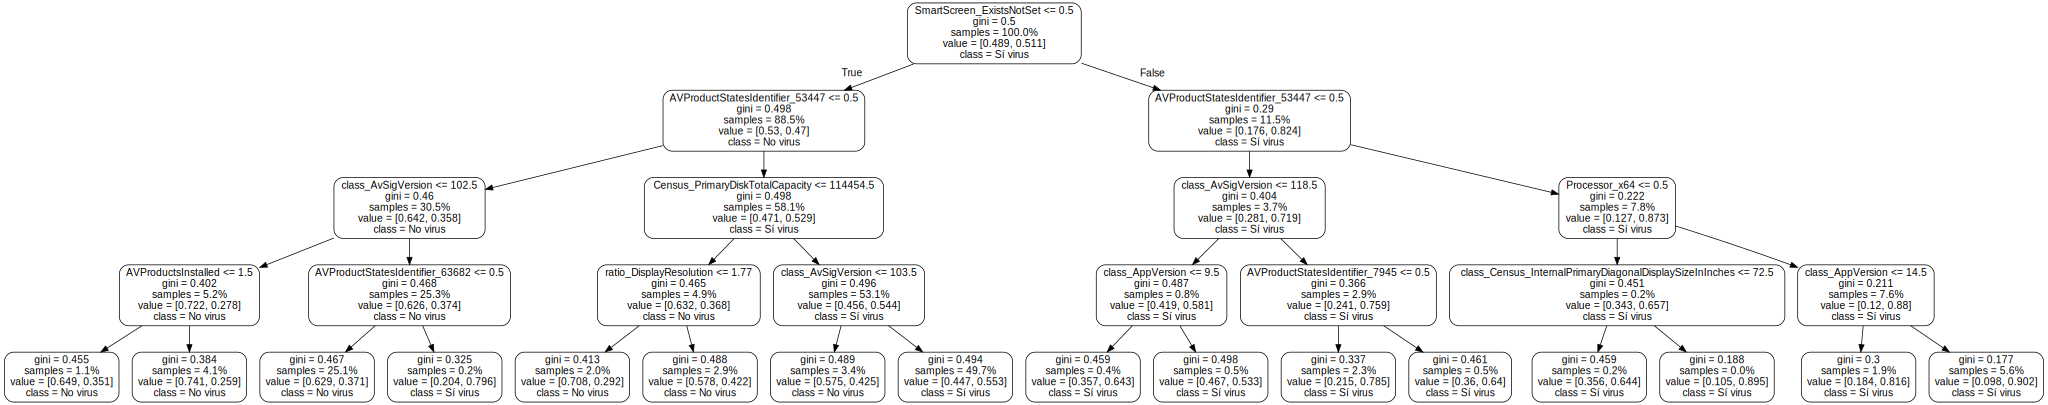

In [ ]:
graphviz.Source(graph_data)

In [ ]:
dt.predict(X_test)

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
# crear dataframe de predicciones y resultados

In [ ]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index= y_test.index, columns = ['Pred_Virus_Detection'])
y_test_pred

Pred_Virus_Detection
MachineIdentifier                                     
5609390e6e6b7a514ae186a9efff5096                     1
26906715dc66ec6522594b89a9f0b50a                     0
cc51f426315b72f83cd2186a81f86009                     1
04550ba1442d5802c51597d9e6b723cf                     1
e8c20c84f32eaaa993a6ef817d8f6cd8                     1
...                                                ...
7cd415e2ad20473e8f9af9a9f238a752                     1
9450a6f50871f172f0096cff08b9cf13                     1
4e6b7bac8eb315bf9292ef486f56d42c                     0
893e8eda63e6898376a0fe9a88d8cdf0                     1
425e7b1d15f8ebbafa3c4f7b8f7fbb8d                     1

[75790 rows x 1 columns]

In [ ]:
results_df = y_test.join(y_test_pred)
results_df

HasDetections  Pred_Virus_Detection
MachineIdentifier                                                    
5609390e6e6b7a514ae186a9efff5096              1                     1
26906715dc66ec6522594b89a9f0b50a              0                     0
cc51f426315b72f83cd2186a81f86009              0                     1
04550ba1442d5802c51597d9e6b723cf              1                     1
e8c20c84f32eaaa993a6ef817d8f6cd8              1                     1
...                                         ...                   ...
7cd415e2ad20473e8f9af9a9f238a752              0                     1
9450a6f50871f172f0096cff08b9cf13              1                     1
4e6b7bac8eb315bf9292ef486f56d42c              0                     0
893e8eda63e6898376a0fe9a88d8cdf0              0                     1
425e7b1d15f8ebbafa3c4f7b8f7fbb8d              0                     1

[75790 rows x 2 columns]

In [ ]:
results_df['Acierto'] = (results_df[TARGET] == results_df['Pred_Virus_Detection']).astype(int)

In [ ]:
results_df

HasDetections  Pred_Virus_Detection  Acierto
MachineIdentifier                                                             
5609390e6e6b7a514ae186a9efff5096              1                     1        1
26906715dc66ec6522594b89a9f0b50a              0                     0        1
cc51f426315b72f83cd2186a81f86009              0                     1        0
04550ba1442d5802c51597d9e6b723cf              1                     1        1
e8c20c84f32eaaa993a6ef817d8f6cd8              1                     1        1
...                                         ...                   ...      ...
7cd415e2ad20473e8f9af9a9f238a752              0                     1        0
9450a6f50871f172f0096cff08b9cf13              1                     1        1
4e6b7bac8eb315bf9292ef486f56d42c              0                     0        1
893e8eda63e6898376a0fe9a88d8cdf0              0                     1        0
425e7b1d15f8ebbafa3c4f7b8f7fbb8d              0                     1        0

[75790 rows x 3 columns]

#### Accuracy

In [ ]:
results_df['Acierto'].mean()

0.6169019659585697

In [ ]:
dt.score(X_test, y_test)

0.6169019659585697

In [ ]:
results_df['Build_year'] = X_test['Build_year']
results_df['Build_month'] = X_test['Build_month']

In [ ]:
results_df

HasDetections  ...  Build_month
MachineIdentifier                                ...             
5609390e6e6b7a514ae186a9efff5096              1  ...            4
26906715dc66ec6522594b89a9f0b50a              0  ...            4
cc51f426315b72f83cd2186a81f86009              0  ...            4
04550ba1442d5802c51597d9e6b723cf              1  ...            4
e8c20c84f32eaaa993a6ef817d8f6cd8              1  ...            4
...                                         ...  ...          ...
7cd415e2ad20473e8f9af9a9f238a752              0  ...            4
9450a6f50871f172f0096cff08b9cf13              1  ...            4
4e6b7bac8eb315bf9292ef486f56d42c              0  ...            4
893e8eda63e6898376a0fe9a88d8cdf0              0  ...            6
425e7b1d15f8ebbafa3c4f7b8f7fbb8d              0  ...            4

[75790 rows x 5 columns]

In [ ]:
results_df.pivot_table(index=['Build_year', 'Build_month'], values='Acierto', aggfunc=[len, sum, np.mean])

len     sum      mean
                       Acierto Acierto   Acierto
Build_year Build_month                          
2011       4                 3       2  0.666667
2014       3                 8       6  0.750000
2015       1                 2       1  0.500000
           3                 4       2  0.500000
2016       1               194     125  0.644330
           2               295     173  0.586441
           3                88      56  0.636364
           4               147      89  0.605442
2017       1                 8       3  0.375000
           2                20      15  0.750000
           3              9148    5528  0.604285
           4               310     178  0.574194
2018       1                70      43  0.614286
           2               237     147  0.620253
           3              2810    1659  0.590391
           4             45129   27959  0.619535
           5             14191    8896  0.626876
           6              1043     625  0.599233
           7               667     419  0.628186
           8              1358     796  0.586156
           9                58      33  0.568966

In [ ]:
# podemos observar que en 2015 las predicciones no son buenas, son del 50% de acierto, y en 2017 en el mes 1 es de 37,5 %.

#### Confusion Matrix

In [ ]:
conf_matrix = pd.crosstab(results_df[TARGET], results_df['Pred_Virus_Detection'])
conf_matrix

Pred_Virus_Detection      0      1
HasDetections                     
0                     18435  18488
1                     10547  28320

In [ ]:
# De los 0, detecta en igual proporción que sean 0 o 1
# Los 1s los detecta mucho mejor 

In [ ]:
dt.predict_proba(X_test)

array([[0.44743146, 0.55256854],
       [0.62912453, 0.37087547],
       [0.44743146, 0.55256854],
       ...,
       [0.62912453, 0.37087547],
       [0.44743146, 0.55256854],
       [0.44743146, 0.55256854]])

In [ ]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index = y_test.index, columns = ['Virus_Score'])
y_score

Virus_Score
MachineIdentifier                            
5609390e6e6b7a514ae186a9efff5096     0.552569
26906715dc66ec6522594b89a9f0b50a     0.370875
cc51f426315b72f83cd2186a81f86009     0.552569
04550ba1442d5802c51597d9e6b723cf     0.552569
e8c20c84f32eaaa993a6ef817d8f6cd8     0.816340
...                                       ...
7cd415e2ad20473e8f9af9a9f238a752     0.552569
9450a6f50871f172f0096cff08b9cf13     0.552569
4e6b7bac8eb315bf9292ef486f56d42c     0.370875
893e8eda63e6898376a0fe9a88d8cdf0     0.552569
425e7b1d15f8ebbafa3c4f7b8f7fbb8d     0.552569

[75790 rows x 1 columns]

In [ ]:
results_df = results_df.join(y_score)

In [ ]:
results_df

HasDetections  ...  Virus_Score
MachineIdentifier                                ...             
5609390e6e6b7a514ae186a9efff5096              1  ...     0.552569
26906715dc66ec6522594b89a9f0b50a              0  ...     0.370875
cc51f426315b72f83cd2186a81f86009              0  ...     0.552569
04550ba1442d5802c51597d9e6b723cf              1  ...     0.552569
e8c20c84f32eaaa993a6ef817d8f6cd8              1  ...     0.816340
...                                         ...  ...          ...
7cd415e2ad20473e8f9af9a9f238a752              0  ...     0.552569
9450a6f50871f172f0096cff08b9cf13              1  ...     0.552569
4e6b7bac8eb315bf9292ef486f56d42c              0  ...     0.370875
893e8eda63e6898376a0fe9a88d8cdf0              0  ...     0.552569
425e7b1d15f8ebbafa3c4f7b8f7fbb8d              0  ...     0.552569

[75790 rows x 6 columns]

#### F1 Score

In [ ]:
metrics.f1_score(y_test, y_test_pred)

0.6611030055442076

#### AUC

In [ ]:
# on test

In [ ]:
metrics.roc_auc_score(results_df[TARGET], results_df['Virus_Score'])

0.653255925474377

In [ ]:
print(metrics.roc_auc_score(y_test, dt.predict_proba(X_test)[:,1]))

0.653255925474377


In [ ]:
fpr, tpr, th = metrics.roc_curve(results_df[TARGET], results_df['Virus_Score'])

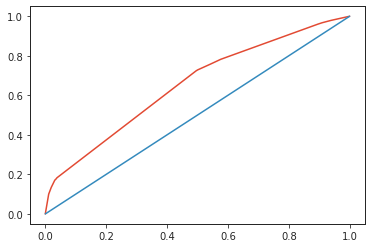

In [ ]:
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])

In [ ]:
top_features_dt = pd.Series(dt.feature_importances_, index = X_train.columns).sort_values(ascending=False)
top_features_dt.head(30)

SmartScreen_ExistsNotSet                                   0.560011
AVProductStatesIdentifier_53447                            0.285918
Census_PrimaryDiskTotalCapacity                            0.061744
class_AvSigVersion                                         0.049455
AVProductStatesIdentifier_63682                            0.015484
ratio_DisplayResolution                                    0.008935
class_AppVersion                                           0.005771
Processor_x64                                              0.005208
AVProductStatesIdentifier_7945                             0.003924
AVProductsInstalled                                        0.003219
class_Census_InternalPrimaryDiagonalDisplaySizeInInches    0.000330
OrganizationIdentifier_37                                  0.000000
OrganizationIdentifier_49                                  0.000000
OrganizationIdentifier_48                                  0.000000
OrganizationIdentifier_46                       

In [ ]:
# vemos que el atributo SmartScreen_ExistsNotSet tiene el 56% de la relevancia e todas las variables

### Best DT

In [ ]:
for i in range(1,15):
  dt_overfit = DecisionTreeClassifier(max_depth= i, random_state=42)

  dt_overfit.fit(X_train, y_train)

  acc_test = dt_overfit.score(X_test, y_test)
  acc_train = dt_overfit.score(X_train, y_train)

  print(f'El modelo se entrena con un depth de {i} preguntas')
  print(f'La accuracy del model en train es {np.round(acc_train,4)}, en test es {np.round(acc_test,4)}')
  print(f'La diferencia es de {np.round(acc_train-acc_test,4)}')
  print('____________________________________________________________')

El modelo se entrena con un depth de 1 preguntas
La accuracy del model en train es 0.5634, en test es 0.561
La diferencia es de 0.0024
____________________________________________________________
El modelo se entrena con un depth de 2 preguntas
La accuracy del model en train es 0.5975, en test es 0.5982
La diferencia es de -0.0006
____________________________________________________________
El modelo se entrena con un depth de 3 preguntas
La accuracy del model en train es 0.6105, en test es 0.6104
La diferencia es de 0.0001
____________________________________________________________
El modelo se entrena con un depth de 4 preguntas
La accuracy del model en train es 0.6168, en test es 0.6169
La diferencia es de -0.0001
____________________________________________________________
El modelo se entrena con un depth de 5 preguntas
La accuracy del model en train es 0.6176, en test es 0.6177
La diferencia es de -0.0001
____________________________________________________________
El modelo se 

In [ ]:
# el arbol acaba overfitteando, aplicaremos el min_samples_leaf o samples para podar algunas ramas

In [ ]:
for i in range(1,12):
  dt_overfit = DecisionTreeClassifier(max_depth= i, random_state=42, min_samples_split= 500)

  dt_overfit.fit(X_train, y_train)

  acc_test = dt_overfit.score(X_test, y_test)
  acc_train = dt_overfit.score(X_train, y_train)

  print(f'El modelo se entrena con un depth de {i} preguntas')
  print(f'La accuracy del model en train es {np.round(acc_train,4)}, en test es {np.round(acc_test,4)}')
  print(f'La diferencia es de {np.round(acc_train-acc_test,4)}')
  print('____________________________________________________________')

El modelo se entrena con un depth de 1 preguntas
La accuracy del model en train es 0.5634, en test es 0.561
La diferencia es de 0.0024
____________________________________________________________
El modelo se entrena con un depth de 2 preguntas
La accuracy del model en train es 0.5975, en test es 0.5982
La diferencia es de -0.0006
____________________________________________________________
El modelo se entrena con un depth de 3 preguntas
La accuracy del model en train es 0.6105, en test es 0.6104
La diferencia es de 0.0001
____________________________________________________________
El modelo se entrena con un depth de 4 preguntas
La accuracy del model en train es 0.6168, en test es 0.6169
La diferencia es de -0.0001
____________________________________________________________
El modelo se entrena con un depth de 5 preguntas
La accuracy del model en train es 0.6176, en test es 0.6177
La diferencia es de -0.0001
____________________________________________________________
El modelo se 

In [ ]:
# cogemos el de profundidad 8 ya que la diferencia entre train y test aún es pequeña y proporciona buenas métricas de accuracy

In [ ]:
best_model = DecisionTreeClassifier(max_depth=8, random_state=42, min_samples_split= 500)

In [ ]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_split=500, random_state=42)

In [ ]:
top_features_bm = pd.Series(best_model.feature_importances_, index = X_train.columns).sort_values(ascending=False)
top_features_bm.head(30)

SmartScreen_ExistsNotSet                                   0.447833
AVProductStatesIdentifier_53447                            0.228644
class_AvSigVersion                                         0.082411
Census_PrimaryDiskTotalCapacity                            0.051448
class_AppVersion                                           0.029788
class_Census_InternalPrimaryDiagonalDisplaySizeInInches    0.015269
Census_OSInstallTypeName_UUPUpgrade                        0.013732
AVProductStatesIdentifier_63682                            0.012905
class_Census_TotalPhysicalRAM                              0.012737
AVProductStatesIdentifier_47238                            0.011537
AVProductStatesIdentifier_46413                            0.007953
Census_OSInstallLanguageIdentifier_29.0                    0.007719
ratio_DisplayResolution                                    0.007145
AVProductStatesIdentifier_7945                             0.006304
Census_IsVirtualDevice                          

#### Scores Train

In [ ]:
best_model.score(X_train, y_train)

0.6293694068129265

In [ ]:
dtAUCtrain = (metrics.roc_auc_score(y_train, best_model.predict_proba(X_train)[:,1]))
dtAUCtrain

0.6842800250211999

#### Scores test

In [ ]:
best_model.score(X_test, y_test)

0.6257157936403219

In [ ]:
dtAUCtest = (metrics.roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]))
dtAUCtest

0.6791271730964912

In [ ]:
# Hay muy poco overfitting entre train y test para AUC --> DIFERENCIA DE: 
(dtAUCtrain - dtAUCtest)

0.005152851924708712

## Optimización de modelos

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(max_depth=8, random_state=42, n_estimators=50, min_samples_split=500)

In [ ]:
rf.fit(
    X = X_train,
    y = np.ravel(y_train)
)

RandomForestClassifier(max_depth=8, min_samples_split=500, n_estimators=50,
                       random_state=42)

In [ ]:
top_features_rf = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
top_features_rf

SmartScreen_ExistsNotSet                                   0.216059
AVProductStatesIdentifier_53447                            0.135150
AVProductsInstalled                                        0.112945
SmartScreen_RequireAdmin                                   0.044375
AVProductStatesIdentifier_Others                           0.038200
AVProductStatesIdentifier_7945                             0.030897
class_AvSigVersion                                         0.029411
class_AppVersion                                           0.022593
class_EngineVersion                                        0.020123
Census_PrimaryDiskTotalCapacity                            0.017315
class_Census_TotalPhysicalRAM                              0.016651
Processor_x86                                              0.015941
SmartScreen_Off                                            0.013744
AVProductStatesIdentifier_41571                            0.012980
Census_IsVirtualDevice                          

In [ ]:
# vemos que el atributo SmartScreen_ExistsNotSet sigue siendo el más relevante, pero en un % mucho menor que el primer DT

#### Scores Train

In [ ]:
rf.score(X_train, y_train)

0.6230690825606365

In [ ]:
rfAUCtrain = (metrics.roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
rfAUCtrain

0.6838127851538287

#### Scores test

In [ ]:
rf.score(X_test, y_test)

0.6202533315740862

In [ ]:
rfAUCtest = (metrics.roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
rfAUCtest

0.679037329367023

In [ ]:
# Hay muy poco overfitting entre train y test --> DIFERENCIA DE: 
(rfAUCtrain - rfAUCtest)

0.004775455786805716

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb = GradientBoostingClassifier(n_estimators=50, max_depth=8, min_samples_split=500, random_state=42)

In [ ]:
gb.fit(
    X_train,
    np.ravel(y_train)
    )

GradientBoostingClassifier(max_depth=8, min_samples_split=500, n_estimators=50,
                           random_state=42)

In [ ]:
top_features_gb = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
top_features_gb

SmartScreen_ExistsNotSet                                   0.216059
AVProductStatesIdentifier_53447                            0.135150
AVProductsInstalled                                        0.112945
SmartScreen_RequireAdmin                                   0.044375
AVProductStatesIdentifier_Others                           0.038200
AVProductStatesIdentifier_7945                             0.030897
class_AvSigVersion                                         0.029411
class_AppVersion                                           0.022593
class_EngineVersion                                        0.020123
Census_PrimaryDiskTotalCapacity                            0.017315
class_Census_TotalPhysicalRAM                              0.016651
Processor_x86                                              0.015941
SmartScreen_Off                                            0.013744
AVProductStatesIdentifier_41571                            0.012980
Census_IsVirtualDevice                          

#### Scores Train

In [ ]:
gb.score(X_train, y_train)

0.6567345848218261

In [ ]:
gbAUCtrain = (metrics.roc_auc_score(y_train, gb.predict_proba(X_train)[:,1]))
gbAUCtrain

0.7239286626914987

#### Scores test

In [ ]:
gb.score(X_test, y_test)

0.6476975854334345

In [ ]:
gbAUCtest = (metrics.roc_auc_score(y_test, gb.predict_proba(X_test)[:,1]))
gbAUCtest

0.7087141625657881

In [ ]:
# diferencia entre train y test de:
gbAUCtrain - gbAUCtest

0.015214500125710573

In [ ]:
# con el gradient boosting ahora la diferencia ha aumentado

### xgboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(max_depth = 8, n_estimators=50, random_state=42)

In [ ]:
xgb.fit(
    X_train,
    np.ravel(y_train)
    )

XGBClassifier(max_depth=8, n_estimators=50, random_state=42)

In [ ]:
y_test_pred_xgb = pd.DataFrame(xgb.predict(X_test), index= y_test.index, columns = ['Pred_Virus_Detection'])

In [ ]:
results_df_xgb = y_test.join(y_test_pred_xgb)

In [ ]:
results_df_xgb['Acierto'] = (results_df[TARGET] == results_df['Pred_Virus_Detection']).astype(int)

In [ ]:
results_df_xgb

HasDetections  Pred_Virus_Detection  Acierto
MachineIdentifier                                                             
5609390e6e6b7a514ae186a9efff5096              1                     1        1
26906715dc66ec6522594b89a9f0b50a              0                     0        1
cc51f426315b72f83cd2186a81f86009              0                     1        0
04550ba1442d5802c51597d9e6b723cf              1                     1        1
e8c20c84f32eaaa993a6ef817d8f6cd8              1                     1        1
...                                         ...                   ...      ...
7cd415e2ad20473e8f9af9a9f238a752              0                     0        0
9450a6f50871f172f0096cff08b9cf13              1                     1        1
4e6b7bac8eb315bf9292ef486f56d42c              0                     0        1
893e8eda63e6898376a0fe9a88d8cdf0              0                     0        0
425e7b1d15f8ebbafa3c4f7b8f7fbb8d              0                     1        0

[75790 rows x 3 columns]

#### Scores Train

In [ ]:
xgb.score(X_train, y_train)

0.6592316243291474

In [ ]:
xgbAUCtrain = (metrics.roc_auc_score(y_train, xgb.predict_proba(X_train)[:,1]))
xgbAUCtrain

0.7285148471701187

#### Scores test

In [ ]:
xgb.score(X_test, y_test)

0.6454149623960945

In [ ]:
conf_matrix = pd.crosstab(results_df_xgb[TARGET], results_df_xgb['Pred_Virus_Detection'])
conf_matrix

Pred_Virus_Detection      0      1
HasDetections                     
0                     22415  14508
1                     12366  26501

In [ ]:
# vemos que mejora mucha la predicción de cada clase

In [ ]:
xgbAUCtest = (metrics.roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))    #0.7143420522139896
xgbAUCtest

0.7069498187739924

In [ ]:
# también mejora el AUC para test
xgbAUCtrain - xgbAUCtest

0.021565028396126285

#### Scores Val

In [ ]:
xgb.score(X_val, y_val)   #0.6865319942348608


0.6515865571595251

In [ ]:
xgbAUCval = (metrics.roc_auc_score(y_val, xgb.predict_proba(X_val)[:,1]))    #0.7594418765129125
xgbAUCval

0.7175945107328117

In [ ]:
# El

## Model selection & Evaluation

In [ ]:
RANDOM_STATE = 42
n_estimators = 50
max_depth = 8
min_samples_split=500

models = [ 
    ('DecisionTree', DecisionTreeClassifier(max_depth=max_depth, random_state=42, min_samples_split=min_samples_split)),
    ('RandomForest', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=RANDOM_STATE, min_samples_split=min_samples_split)),
    ('GradientBoosting', GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=RANDOM_STATE, min_samples_split=min_samples_split)),
    ('xgboost', XGBClassifier(max_depth = max_depth, random_state=RANDOM_STATE))]


ROC AUC Score for DecisionTree: 0.6791271730964912
ROC AUC Score for RandomForest: 0.679037329367023
ROC AUC Score for GradientBoosting: 0.7087141625657881
ROC AUC Score for xgboost: 0.7125906410944399


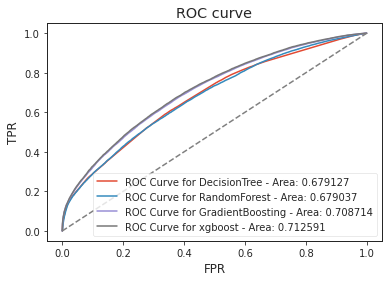

In [ ]:
plt.clf()
for model in models:
    model_name = model[0]
    model_instance = model[1]
    model_instance.fit(X_train, np.ravel(y_train))
    predictions = model_instance.predict_proba(X_test)[:,1]
    auc_score = metrics.roc_auc_score(y_test, predictions)
    print('ROC AUC Score for {}: {}'.format(model_name, auc_score))
    fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
    plt.plot(fpr, tpr, label='ROC Curve for {} - Area: {:2f}'.format(model_name, auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()

In [ ]:
kf = model_selection.KFold(n_splits=10, shuffle=False)

In [ ]:
scores_list = []
for train_index, test_index in kf.split(dev_df):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_dev.iloc[train_index], X_dev.iloc[test_index]
    y_train, y_test = y_dev.iloc[train_index], y_dev.iloc[test_index]
    xgb = XGBClassifier(max_depth = 8, n_estimators=50, random_state=42)
    xgb.fit(X_train, np.ravel(y_train))
    _score = metrics.roc_auc_score(y_test, gb.predict_proba(X_test)[:,1])
    scores_list.append(_score)
    #print(_scores)
scores_list

In [ ]:
np.mean(scores_list)

In [ ]:
np.std(scores_list)

In [ ]:
# xgboosted = XGBClassifier(max_depth = 9, random_state=42)

In [ ]:
scores_list

In [ ]:
print("AUC: %0.3f (+/- %0.3f)" % (np.mean(scores_list), np.std(scores_list) * 2))

In [ ]:
# Con el modelo de xgboost se consigue el mejor valor de AUC de los modelos provados. Aproximadamente 0.719